In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from  sklearn.preprocessing import LabelEncoder
from  sklearn.preprocessing import OneHotEncoder
import scipy 
from scipy.sparse import coo_matrix, hstack

from __future__ import division
from scipy.special import erfinv


from sklearn.model_selection import train_test_split
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression

import xgboost as xgb


In [76]:
from rgf.sklearn import RGFClassifier

In [2]:
#df_train = pd.read_csv("../data/sparse/train_new2.csv")
#df_test = pd.read_csv("../data/sparse/test_new2.csv")
df_train = pd.read_csv("../data/sparse/train_good.csv")
df_test = pd.read_csv("../data/sparse/test_good.csv")
df_labels = pd.read_csv("../data/labels_train.csv" , header = None )[1]
test_ids = pd.read_csv("../data/ids_test.csv" , header = None)[1].values
test_ids
df_train.shape

(307511, 269)

In [3]:
test_ids.shape

(48744,)

In [4]:
positive_data_indx = df_labels[ df_labels == 1 ]
positive_data = df_train.iloc[ positive_data_indx.index ]
#print( positive_data.shape )
negative_data_indx = df_labels[  df_labels == 0 ]
negative_data = df_train.iloc[  negative_data_indx.index ]
#print( negative_data.shape )
positive_ratio = float(len(positive_data)) / len(df_train)
positive_ratio

positive_data = None
negative_data = None


In [5]:
learning_rate = 0.01
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.05
num_boost_round = 10000
ncat = 43
params = {"objective": "binary",
          "boosting_type": "gbdt",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.1,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 150,
          "min_split_gain": 0.5,
          "max_depth": -1, 
         "lambda_l2": 100 , 
          "min_gain_to_split" : 0.5 ,
          "bagging_freq" : 1 , 
          "subsample" : 0.9 , 
          "categorical_feature" : range(ncat)
}

In [6]:
learning_rate = 0.01
num_leaves = 15
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 10000
params_xgb = {"booster": "gbtree",
         "eta" : learning_rate , 
          "max_depth" : 5 , 
          "colsample_bytree" : feature_fraction , 
          "lambda" : 100 , 
           "tree_method" : "hist" , 
          "max_bin" : 256 , 
          "rate_drop": 0.01 , 
          'objective': 'binary:logistic' , 
          "eval_metric" : "auc"
}

In [8]:
NFOLDS = 5
ncat = 43
#X = features_train_t.values
XX_test = df_test.values

XX_train = df_train.values
labels_full = df_labels.values
# for xgb 
dtest = xgb.DMatrix( X_test )
dtrain_full = xgb.DMatrix( df_train.values )

labels_train = df_labels.values
final_cv_train = np.zeros(len( labels_train ))

final_cv_pred = np.zeros(len( test_ids ))

x_score = []
x_score_xgb = []

best_trees = []
fold_scores = []
N = 16

oof_train_full = []
oof_test_full = [] 


for s in range(N):
    
    
    params['seed'] = s
    
    #x_train , x_val , y_train , y_val = train_test_split( df_train , df_labels , test_size = 0.2 , random_state=s)

    # split the entire data set in k-folds
    kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf = kfold.split( df_train , df_labels )
    
    oof_train = np.zeros((len(df_train),))
    
    
    oof_test = np.zeros((len(df_test),))
    oof_test_skf = np.empty((NFOLDS, len(df_test)))

    for i , (train_fold , validate ) in enumerate( kf ):
        
        X_train, X_validate, label_train, label_validate = XX_train[train_fold, :], XX_train[validate, :], labels_full[train_fold],labels_full[validate]

        positive_indx = y_train[ y_train == 1 ]
        positive_data = x_train.loc[ positive_indx.index.values  ]


        negative_indx = y_train[ y_train == 0 ]
        negative_data = x_train.loc[  negative_indx.index.values  ]
        
        negative_data = negative_data.sample( frac= positive_ratio / (1 - positive_ratio), random_state=s*5 )

        print(positive_data.shape)
        print(negative_data.shape )

        labels = [ 0 for x in range( negative_data.shape[0]) ] + [ 1 for x in range( positive_data.shape[0]) ]

        x_train_sampled = pd.concat( [ negative_data , positive_data] , axis = 0 )
        x_train_sampled["y"] = labels
        x_train_sampled = x_train_sampled.sample(frac = 1 ,random_state = s )
        labels_sampled = x_train_sampled["y"].values
    
        x_train_sampled = x_train_sampled.drop( ["y"] , axis = 1 ).values
    
        kfold = KFold(n_splits=NFOLDS, shuffle=True, random_state=s)
        kf2 = kfold.split( x_train_sampled.values , labels_sampled.values  )
        best_trees = []
        fold_scores = []
        
        
        preds_validate_full = np.zeros_like( label_validate )
        
        
        for k  ,( train_fold2 , validate2 ) in enumerate( kf2):
            
            x_tr = x_train_sampled[ train_fold2 ]
            y_tr = labels_sampled[train_fold2]
            
            x_valid = x_train_sampled[ validate2 ]
            y_valid = labels_sampled[ validate2]
            
            dtrain = lgb.Dataset( x_tr , y_tr , categorical_feature = range(ncat)  )
            dvalid = lgb.Dataset(  x_valid  , y_valid , reference=dtrain , categorical_feature = range(ncat) )
            bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 300 , early_stopping_rounds = 100 ) 
        
            # predictiosn for the out of fold in whole set
            preds_validate_full += bst.predict( X_validate )
            oof_test_skf[ k , : ] = bst.predict( XX_test )
            
        
        preds_validate_full /= NFOLDS 
        oof_train[ validate ] = preds_validate_full
        
        oof_test_parcial = oof_test_skf.mean( axis = 0 ) 
        oof_test += oof_test_parcial

    oof_test /= NFOLDS  
    
    
    oof_train_full.append( oof_train )
    oof_test_full.append( oof_test )
    
    

(19970, 269)
(19850, 269)
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.639564	valid_0's auc: 0.720463
[600]	valid_0's binary_logloss: 0.616387	valid_0's auc: 0.73768
[900]	valid_0's binary_logloss: 0.60415	valid_0's auc: 0.746265
[1200]	valid_0's binary_logloss: 0.597397	valid_0's auc: 0.750696
[1500]	valid_0's binary_logloss: 0.59184	valid_0's auc: 0.754705
[1800]	valid_0's binary_logloss: 0.587909	valid_0's auc: 0.757588
[2100]	valid_0's binary_logloss: 0.585601	valid_0's auc: 0.759236
[2400]	valid_0's binary_logloss: 0.583618	valid_0's auc: 0.760687
[2700]	valid_0's binary_logloss: 0.582194	valid_0's auc: 0.761695
[3000]	valid_0's binary_logloss: 0.581275	valid_0's auc: 0.762333
[3300]	valid_0's binary_logloss: 0.580441	valid_0's auc: 0.76295
[3600]	valid_0's binary_logloss: 0.579865	valid_0's auc: 0.763404
[3900]	valid_0's binary_logloss: 0.579262	valid_0's auc: 0.763903
Early stopping, best iteration is:
[4035]	valid_0's binary_l

[1800]	valid_0's binary_logloss: 0.58243	valid_0's auc: 0.76814
[2100]	valid_0's binary_logloss: 0.579345	valid_0's auc: 0.770055
[2400]	valid_0's binary_logloss: 0.577208	valid_0's auc: 0.771416
[2700]	valid_0's binary_logloss: 0.575749	valid_0's auc: 0.772264
[3000]	valid_0's binary_logloss: 0.574405	valid_0's auc: 0.773105
[3300]	valid_0's binary_logloss: 0.573386	valid_0's auc: 0.773706
[3600]	valid_0's binary_logloss: 0.572545	valid_0's auc: 0.774173
Early stopping, best iteration is:
[3697]	valid_0's binary_logloss: 0.572256	valid_0's auc: 0.774374
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.638341	valid_0's auc: 0.726221
[600]	valid_0's binary_logloss: 0.614262	valid_0's auc: 0.743386
[900]	valid_0's binary_logloss: 0.601252	valid_0's auc: 0.752821
[1200]	valid_0's binary_logloss: 0.592721	valid_0's auc: 0.758993
[1500]	valid_0's binary_logloss: 0.587	valid_0's auc: 0.763011
[1800]	valid_0's binary_logloss: 0.58343	valid_0's a

[300]	valid_0's binary_logloss: 0.637708	valid_0's auc: 0.724286
[600]	valid_0's binary_logloss: 0.614459	valid_0's auc: 0.740985
[900]	valid_0's binary_logloss: 0.60109	valid_0's auc: 0.751206
[1200]	valid_0's binary_logloss: 0.593036	valid_0's auc: 0.757117
[1500]	valid_0's binary_logloss: 0.587403	valid_0's auc: 0.761523
[1800]	valid_0's binary_logloss: 0.583231	valid_0's auc: 0.764608
[2100]	valid_0's binary_logloss: 0.580092	valid_0's auc: 0.767075
[2400]	valid_0's binary_logloss: 0.577404	valid_0's auc: 0.769276
[2700]	valid_0's binary_logloss: 0.57567	valid_0's auc: 0.770573
[3000]	valid_0's binary_logloss: 0.574489	valid_0's auc: 0.771415
[3300]	valid_0's binary_logloss: 0.573572	valid_0's auc: 0.77211
[3600]	valid_0's binary_logloss: 0.57283	valid_0's auc: 0.772612
[3900]	valid_0's binary_logloss: 0.572208	valid_0's auc: 0.773018
[4200]	valid_0's binary_logloss: 0.571843	valid_0's auc: 0.773204
[4500]	valid_0's binary_logloss: 0.57139	valid_0's auc: 0.773591
[4800]	valid_0's b

[3300]	valid_0's binary_logloss: 0.57279	valid_0's auc: 0.773227
Early stopping, best iteration is:
[3361]	valid_0's binary_logloss: 0.572633	valid_0's auc: 0.773312
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.635052	valid_0's auc: 0.737057
[600]	valid_0's binary_logloss: 0.61216	valid_0's auc: 0.750068
[900]	valid_0's binary_logloss: 0.598648	valid_0's auc: 0.758461
[1200]	valid_0's binary_logloss: 0.589911	valid_0's auc: 0.763672
[1500]	valid_0's binary_logloss: 0.584107	valid_0's auc: 0.767275
[1800]	valid_0's binary_logloss: 0.580306	valid_0's auc: 0.769478
[2100]	valid_0's binary_logloss: 0.577855	valid_0's auc: 0.770875
[2400]	valid_0's binary_logloss: 0.57586	valid_0's auc: 0.771889
[2700]	valid_0's binary_logloss: 0.57419	valid_0's auc: 0.77281
[3000]	valid_0's binary_logloss: 0.572973	valid_0's auc: 0.773381
[3300]	valid_0's binary_logloss: 0.572056	valid_0's auc: 0.773862
[3600]	valid_0's binary_logloss: 0.571492	valid_0's 

[2100]	valid_0's binary_logloss: 0.581359	valid_0's auc: 0.765077
[2400]	valid_0's binary_logloss: 0.579171	valid_0's auc: 0.766611
[2700]	valid_0's binary_logloss: 0.577542	valid_0's auc: 0.76775
[3000]	valid_0's binary_logloss: 0.576417	valid_0's auc: 0.768457
[3300]	valid_0's binary_logloss: 0.575478	valid_0's auc: 0.769066
[3600]	valid_0's binary_logloss: 0.57481	valid_0's auc: 0.769564
[3900]	valid_0's binary_logloss: 0.574311	valid_0's auc: 0.769881
[4200]	valid_0's binary_logloss: 0.573859	valid_0's auc: 0.770097
[4500]	valid_0's binary_logloss: 0.57357	valid_0's auc: 0.770263
[4800]	valid_0's binary_logloss: 0.573301	valid_0's auc: 0.770398
Early stopping, best iteration is:
[4806]	valid_0's binary_logloss: 0.573278	valid_0's auc: 0.770424
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.637668	valid_0's auc: 0.726519
[600]	valid_0's binary_logloss: 0.616008	valid_0's auc: 0.738986
[900]	valid_0's binary_logloss: 0.602618	valid_0'

[3900]	valid_0's binary_logloss: 0.578288	valid_0's auc: 0.767173
[4200]	valid_0's binary_logloss: 0.577793	valid_0's auc: 0.767552
[4500]	valid_0's binary_logloss: 0.577439	valid_0's auc: 0.76783
[4800]	valid_0's binary_logloss: 0.577141	valid_0's auc: 0.768128
[5100]	valid_0's binary_logloss: 0.57694	valid_0's auc: 0.768313
Early stopping, best iteration is:
[5125]	valid_0's binary_logloss: 0.576879	valid_0's auc: 0.768381
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.635745	valid_0's auc: 0.738098
[600]	valid_0's binary_logloss: 0.610197	valid_0's auc: 0.754834
[900]	valid_0's binary_logloss: 0.595468	valid_0's auc: 0.764622
[1200]	valid_0's binary_logloss: 0.586729	valid_0's auc: 0.770309
[1500]	valid_0's binary_logloss: 0.581413	valid_0's auc: 0.773686
[1800]	valid_0's binary_logloss: 0.576717	valid_0's auc: 0.776497
[2100]	valid_0's binary_logloss: 0.573293	valid_0's auc: 0.77848
[2400]	valid_0's binary_logloss: 0.570693	valid_0'

[2100]	valid_0's binary_logloss: 0.588518	valid_0's auc: 0.75879
[2400]	valid_0's binary_logloss: 0.586576	valid_0's auc: 0.76018
[2700]	valid_0's binary_logloss: 0.584918	valid_0's auc: 0.76142
[3000]	valid_0's binary_logloss: 0.583672	valid_0's auc: 0.762378
[3300]	valid_0's binary_logloss: 0.582694	valid_0's auc: 0.76317
[3600]	valid_0's binary_logloss: 0.581785	valid_0's auc: 0.763969
[3900]	valid_0's binary_logloss: 0.581278	valid_0's auc: 0.76443
[4200]	valid_0's binary_logloss: 0.580722	valid_0's auc: 0.764953
[4500]	valid_0's binary_logloss: 0.580218	valid_0's auc: 0.765398
[4800]	valid_0's binary_logloss: 0.579774	valid_0's auc: 0.765819
Early stopping, best iteration is:
[4976]	valid_0's binary_logloss: 0.579633	valid_0's auc: 0.765946
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.640103	valid_0's auc: 0.718439
[600]	valid_0's binary_logloss: 0.618037	valid_0's auc: 0.735734
[900]	valid_0's binary_logloss: 0.604381	valid_0's 

[300]	valid_0's binary_logloss: 0.636623	valid_0's auc: 0.732854
[600]	valid_0's binary_logloss: 0.612277	valid_0's auc: 0.748107
[900]	valid_0's binary_logloss: 0.600347	valid_0's auc: 0.755562
[1200]	valid_0's binary_logloss: 0.591584	valid_0's auc: 0.761577
[1500]	valid_0's binary_logloss: 0.585218	valid_0's auc: 0.766048
[1800]	valid_0's binary_logloss: 0.581194	valid_0's auc: 0.76874
[2100]	valid_0's binary_logloss: 0.57807	valid_0's auc: 0.770749
[2400]	valid_0's binary_logloss: 0.57564	valid_0's auc: 0.772329
[2700]	valid_0's binary_logloss: 0.574003	valid_0's auc: 0.77332
[3000]	valid_0's binary_logloss: 0.572808	valid_0's auc: 0.77405
[3300]	valid_0's binary_logloss: 0.571835	valid_0's auc: 0.774627
[3600]	valid_0's binary_logloss: 0.570896	valid_0's auc: 0.775206
[3900]	valid_0's binary_logloss: 0.570228	valid_0's auc: 0.775573
[4200]	valid_0's binary_logloss: 0.569819	valid_0's auc: 0.775847
[4500]	valid_0's binary_logloss: 0.5695	valid_0's auc: 0.775987
Early stopping, best

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.680239	valid_0's auc: 0.729297
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[36]	valid_0's binary_logloss: 0.681313	valid_0's auc: 0.705591
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[38]	valid_0's binary_logloss: 0.680606	valid_0's auc: 0.711369
[0]	eval-auc:0.698602
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.745418
[600]	eval-auc:0.75782
[900]	eval-auc:0.762995
[1200]	eval-auc:0.766021
[1500]	eval-auc:0.76774
[1800]	eval-auc:0.768718
[2100]	eval-auc:0.769412
[2400]	eval-auc:0.769933
[2700]	eval-auc:0.770118
Stopping. Best iteration:
[2622]	eval-auc:0.770132

[0]	eval-auc:0.695106
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.744063
[600]	eval-auc:0.75602
[900]	eval-auc:0.760762
[1200]	eval-a

[1500]	eval-auc:0.762604
[1800]	eval-auc:0.7638
[2100]	eval-auc:0.764581
[2400]	eval-auc:0.76504
[2700]	eval-auc:0.765363
[3000]	eval-auc:0.765511
Stopping. Best iteration:
[2938]	eval-auc:0.765531

[0]	eval-auc:0.712719
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.757481
[600]	eval-auc:0.76996
[900]	eval-auc:0.776007
[1200]	eval-auc:0.778913
[1500]	eval-auc:0.780797
[1800]	eval-auc:0.781776
[2100]	eval-auc:0.782287
[2400]	eval-auc:0.782733
[2700]	eval-auc:0.783162
[3000]	eval-auc:0.783438
[3300]	eval-auc:0.783602
Stopping. Best iteration:
[3200]	eval-auc:0.78362

[0]	eval-auc:0.698405
Will train until eval-auc hasn't improved in 100 rounds.
[300]	eval-auc:0.745033
[600]	eval-auc:0.756202
[900]	eval-auc:0.761474
[1200]	eval-auc:0.764981
[1500]	eval-auc:0.767066
[1800]	eval-auc:0.768596
[2100]	eval-auc:0.769112
[2400]	eval-auc:0.769459
[2700]	eval-auc:0.769775
[3000]	eval-auc:0.76999
Stopping. Best iteration:
[2975]	eval-auc:0.770036

('current score in fold

[4200]	valid_0's binary_logloss: 0.569259	valid_0's auc: 0.775049
Early stopping, best iteration is:
[4126]	valid_0's binary_logloss: 0.569305	valid_0's auc: 0.775096
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.635685	valid_0's auc: 0.733399
[600]	valid_0's binary_logloss: 0.612198	valid_0's auc: 0.748847
[900]	valid_0's binary_logloss: 0.598717	valid_0's auc: 0.757805
[1200]	valid_0's binary_logloss: 0.589802	valid_0's auc: 0.763784
[1500]	valid_0's binary_logloss: 0.584115	valid_0's auc: 0.767684
[1800]	valid_0's binary_logloss: 0.580147	valid_0's auc: 0.770235
[2100]	valid_0's binary_logloss: 0.577284	valid_0's auc: 0.771975
[2400]	valid_0's binary_logloss: 0.575574	valid_0's auc: 0.772979
[2700]	valid_0's binary_logloss: 0.573951	valid_0's auc: 0.773937
[3000]	valid_0's binary_logloss: 0.572711	valid_0's auc: 0.774586
[3300]	valid_0's binary_logloss: 0.57174	valid_0's auc: 0.775213
[3600]	valid_0's binary_logloss: 0.571123	valid_

[900]	valid_0's binary_logloss: 0.60073	valid_0's auc: 0.755852
[1200]	valid_0's binary_logloss: 0.593091	valid_0's auc: 0.760677
[1500]	valid_0's binary_logloss: 0.585958	valid_0's auc: 0.765715
[1800]	valid_0's binary_logloss: 0.58245	valid_0's auc: 0.767902
[2100]	valid_0's binary_logloss: 0.579349	valid_0's auc: 0.769794
[2400]	valid_0's binary_logloss: 0.576657	valid_0's auc: 0.771552
[2700]	valid_0's binary_logloss: 0.57513	valid_0's auc: 0.772507
[3000]	valid_0's binary_logloss: 0.573853	valid_0's auc: 0.773318
[3300]	valid_0's binary_logloss: 0.572686	valid_0's auc: 0.774022
[3600]	valid_0's binary_logloss: 0.57178	valid_0's auc: 0.774529
[3900]	valid_0's binary_logloss: 0.571228	valid_0's auc: 0.774727
[4200]	valid_0's binary_logloss: 0.570632	valid_0's auc: 0.775056
[4500]	valid_0's binary_logloss: 0.570193	valid_0's auc: 0.775288
[4800]	valid_0's binary_logloss: 0.569942	valid_0's auc: 0.775312
Early stopping, best iteration is:
[4724]	valid_0's binary_logloss: 0.569938	vali

[900]	valid_0's binary_logloss: 0.599814	valid_0's auc: 0.754036
[1200]	valid_0's binary_logloss: 0.591917	valid_0's auc: 0.759208
[1500]	valid_0's binary_logloss: 0.586761	valid_0's auc: 0.762633
[1800]	valid_0's binary_logloss: 0.58245	valid_0's auc: 0.7654
[2100]	valid_0's binary_logloss: 0.579448	valid_0's auc: 0.767306
[2400]	valid_0's binary_logloss: 0.577328	valid_0's auc: 0.76861
[2700]	valid_0's binary_logloss: 0.57582	valid_0's auc: 0.769575
[3000]	valid_0's binary_logloss: 0.574736	valid_0's auc: 0.770312
[3300]	valid_0's binary_logloss: 0.573993	valid_0's auc: 0.770761
[3600]	valid_0's binary_logloss: 0.573311	valid_0's auc: 0.771138
Early stopping, best iteration is:
[3630]	valid_0's binary_logloss: 0.57328	valid_0's auc: 0.771161
Training until validation scores don't improve for 100 rounds.
[300]	valid_0's binary_logloss: 0.636301	valid_0's auc: 0.736959
[600]	valid_0's binary_logloss: 0.610065	valid_0's auc: 0.75514
[900]	valid_0's binary_logloss: 0.596692	valid_0's auc

[300]	valid_0's binary_logloss: 0.637331	valid_0's auc: 0.725721
[600]	valid_0's binary_logloss: 0.615322	valid_0's auc: 0.740467
[900]	valid_0's binary_logloss: 0.603483	valid_0's auc: 0.748003
[1200]	valid_0's binary_logloss: 0.595483	valid_0's auc: 0.753689
[1500]	valid_0's binary_logloss: 0.590411	valid_0's auc: 0.757225
[1800]	valid_0's binary_logloss: 0.587025	valid_0's auc: 0.759405
[2100]	valid_0's binary_logloss: 0.584449	valid_0's auc: 0.761239
[2400]	valid_0's binary_logloss: 0.582794	valid_0's auc: 0.762295
[2700]	valid_0's binary_logloss: 0.581348	valid_0's auc: 0.763239
[3000]	valid_0's binary_logloss: 0.580349	valid_0's auc: 0.763942
[3300]	valid_0's binary_logloss: 0.579696	valid_0's auc: 0.76437
[3600]	valid_0's binary_logloss: 0.579107	valid_0's auc: 0.764727
[3900]	valid_0's binary_logloss: 0.578683	valid_0's auc: 0.764948
Early stopping, best iteration is:
[3859]	valid_0's binary_logloss: 0.578681	valid_0's auc: 0.764992
[0]	eval-auc:0.674292
Will train until eval-a

In [9]:
new_train = np.hstack( oof_train_full )
new_test = np.hstack( oof_test_full )

In [10]:
print( "SUCCES")

SUCCES


In [14]:
new_train[0]

array([0.84819875, 0.80466703, 0.8728595 , 0.83404166, 0.86932667,
       0.82281049, 0.89268032, 0.8536317 , 0.88881459, 0.8606409 ,
       0.8888993 , 0.8551568 , 0.88352699, 0.83572105, 0.87422109,
       0.82667006, 0.6543259 , 0.76724432, 0.52464258, 0.86395886,
       0.85872359, 0.81079837, 0.60254876, 0.86716409, 0.87959869,
       0.85582852, 0.89631916, 0.84787223, 0.90962619, 0.87178991,
       0.90386021, 0.86084839])

In [123]:
learning_rate = 0.01
num_leaves = 30
min_data_in_leaf = 2000
feature_fraction = 0.5
num_boost_round = 10000
params = {"objective": "binary",
          "boosting_type": "goss",
          "learning_rate": learning_rate,
          "metric":["auc" ,"binary_logloss"] , 
          "num_leaves": num_leaves,
           "max_bin": 256,
          "feature_fraction": feature_fraction,
          "verbosity": 1,
          "drop_rate": 0.01,
          "is_unbalance": False,
          "max_drop": 50,
          "min_child_samples": 20,
          "min_child_weight": 10,
          "min_split_gain": 0.5,
          "max_depth": -1, 
         "lambda_l2": 100 , 
          "lambda_l1": 100 , 
          "min_gain_to_split" : 0.5 ,
         # "bagging_freq" : 1 , 
          "subsample" : 0.9
}

# Lightgbm model with oof_preds

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339806	training's auc: 0.809665	valid_0's binary_logloss: 0.341023	valid_0's auc: 0.801819
[200]	training's binary_logloss: 0.256875	training's auc: 0.814966	valid_0's binary_logloss: 0.25907	valid_0's auc: 0.807324
[300]	training's binary_logloss: 0.234791	training's auc: 0.817216	valid_0's binary_logloss: 0.237581	valid_0's auc: 0.80951
[400]	training's binary_logloss: 0.228666	training's auc: 0.819018	valid_0's binary_logloss: 0.231911	valid_0's auc: 0.811049
[500]	training's binary_logloss: 0.22667	training's auc: 0.820105	valid_0's binary_logloss: 0.230142	valid_0's auc: 0.811741
[600]	training's binary_logloss: 0.225881	training's auc: 0.820961	valid_0's binary_logloss: 0.22948	valid_0's auc: 0.812405
[700]	training's binary_logloss: 0.225466	training's auc: 0.821647	valid_0's binary_logloss: 0.229186	valid_0's auc: 0.812806
[800]	training's binary_logloss: 0.225236	training's auc: 0

[900]	training's binary_logloss: 0.225373	training's auc: 0.821665	valid_0's binary_logloss: 0.226807	valid_0's auc: 0.818376
[1000]	training's binary_logloss: 0.225276	training's auc: 0.821875	valid_0's binary_logloss: 0.226738	valid_0's auc: 0.818535
[1100]	training's binary_logloss: 0.225179	training's auc: 0.822099	valid_0's binary_logloss: 0.226673	valid_0's auc: 0.818699
[1200]	training's binary_logloss: 0.225165	training's auc: 0.822134	valid_0's binary_logloss: 0.226662	valid_0's auc: 0.818726
Early stopping, best iteration is:
[1111]	training's binary_logloss: 0.225169	training's auc: 0.822129	valid_0's binary_logloss: 0.226664	valid_0's auc: 0.818728
fold 4  - 0.818726233289 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339992	training's auc: 0.809707	valid_0's binary_logloss: 0.340123	valid_0's auc: 0.804579
[200]	training's binary_logloss: 0.257121	training's auc: 0.814427	valid_0's binary_logloss: 0.257468	

[500]	training's binary_logloss: 0.226964	training's auc: 0.81957	valid_0's binary_logloss: 0.227583	valid_0's auc: 0.816733
[600]	training's binary_logloss: 0.226182	training's auc: 0.82037	valid_0's binary_logloss: 0.2269	valid_0's auc: 0.817348
[700]	training's binary_logloss: 0.225771	training's auc: 0.821066	valid_0's binary_logloss: 0.226602	valid_0's auc: 0.817765
[800]	training's binary_logloss: 0.225545	training's auc: 0.821513	valid_0's binary_logloss: 0.226446	valid_0's auc: 0.818019
[900]	training's binary_logloss: 0.225392	training's auc: 0.821837	valid_0's binary_logloss: 0.226357	valid_0's auc: 0.818193
[1000]	training's binary_logloss: 0.225268	training's auc: 0.822113	valid_0's binary_logloss: 0.22629	valid_0's auc: 0.818319
[1100]	training's binary_logloss: 0.22518	training's auc: 0.822324	valid_0's binary_logloss: 0.226246	valid_0's auc: 0.818424
[1200]	training's binary_logloss: 0.225136	training's auc: 0.822432	valid_0's binary_logloss: 0.226222	valid_0's auc: 0.81

Early stopping, best iteration is:
[1349]	training's binary_logloss: 0.224996	training's auc: 0.822838	valid_0's binary_logloss: 0.226181	valid_0's auc: 0.817898
fold 3  - 0.817898353182 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340027	training's auc: 0.809707	valid_0's binary_logloss: 0.340379	valid_0's auc: 0.808141
[200]	training's binary_logloss: 0.257153	training's auc: 0.814266	valid_0's binary_logloss: 0.25761	valid_0's auc: 0.811517
[300]	training's binary_logloss: 0.235022	training's auc: 0.816798	valid_0's binary_logloss: 0.235744	valid_0's auc: 0.814402
[400]	training's binary_logloss: 0.228857	training's auc: 0.818706	valid_0's binary_logloss: 0.229912	valid_0's auc: 0.815341
[500]	training's binary_logloss: 0.226843	training's auc: 0.819824	valid_0's binary_logloss: 0.228161	valid_0's auc: 0.8159
[600]	training's binary_logloss: 0.22605	training's auc: 0.820661	valid_0's binary_logloss: 0.227567	valid_0

[500]	training's binary_logloss: 0.226967	training's auc: 0.819222	valid_0's binary_logloss: 0.228004	valid_0's auc: 0.819241
[600]	training's binary_logloss: 0.226182	training's auc: 0.82003	valid_0's binary_logloss: 0.227212	valid_0's auc: 0.819894
[700]	training's binary_logloss: 0.225784	training's auc: 0.820704	valid_0's binary_logloss: 0.226843	valid_0's auc: 0.820343
[800]	training's binary_logloss: 0.22554	training's auc: 0.821199	valid_0's binary_logloss: 0.226626	valid_0's auc: 0.820676
[900]	training's binary_logloss: 0.225393	training's auc: 0.821509	valid_0's binary_logloss: 0.22649	valid_0's auc: 0.820901
[1000]	training's binary_logloss: 0.225276	training's auc: 0.821758	valid_0's binary_logloss: 0.226399	valid_0's auc: 0.82103
[1100]	training's binary_logloss: 0.225177	training's auc: 0.821998	valid_0's binary_logloss: 0.22633	valid_0's auc: 0.821155
[1200]	training's binary_logloss: 0.225105	training's auc: 0.822164	valid_0's binary_logloss: 0.226274	valid_0's auc: 0.8

/usr/local/lib/python2.7/dist-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339878	training's auc: 0.809562	valid_0's binary_logloss: 0.340552	valid_0's auc: 0.802456
[200]	training's binary_logloss: 0.256969	training's auc: 0.814818	valid_0's binary_logloss: 0.258387	valid_0's auc: 0.808224
[300]	training's binary_logloss: 0.234833	training's auc: 0.81748	valid_0's binary_logloss: 0.236891	valid_0's auc: 0.81026
[400]	training's binary_logloss: 0.228712	training's auc: 0.818892	valid_0's binary_logloss: 0.231204	valid_0's auc: 0.811579
[500]	training's binary_logloss: 0.226705	training's auc: 0.820084	valid_0's binary_logloss: 0.229498	valid_0's auc: 0.812474
[600]	training's binary_logloss: 0.225906	training's auc: 0.820939	valid_0's binary_logloss: 0.228884	valid_0's auc: 0.813016
[700]	training's binary_logloss: 0.225509	training's auc: 0.82159	valid_0's binary_logloss: 0.228581	valid_0's auc: 0.813542
[800]	training's binary_logloss: 0.225281	training's auc: 

[800]	training's binary_logloss: 0.22562	training's auc: 0.821336	valid_0's binary_logloss: 0.225317	valid_0's auc: 0.820852
[900]	training's binary_logloss: 0.225477	training's auc: 0.821622	valid_0's binary_logloss: 0.225219	valid_0's auc: 0.821036
[1000]	training's binary_logloss: 0.225375	training's auc: 0.821853	valid_0's binary_logloss: 0.225163	valid_0's auc: 0.821142
[1100]	training's binary_logloss: 0.225278	training's auc: 0.822057	valid_0's binary_logloss: 0.225118	valid_0's auc: 0.821221
[1200]	training's binary_logloss: 0.225204	training's auc: 0.822244	valid_0's binary_logloss: 0.225082	valid_0's auc: 0.821302
[1300]	training's binary_logloss: 0.225156	training's auc: 0.822355	valid_0's binary_logloss: 0.225059	valid_0's auc: 0.821355
Early stopping, best iteration is:
[1288]	training's binary_logloss: 0.225158	training's auc: 0.822351	valid_0's binary_logloss: 0.225059	valid_0's auc: 0.821357
fold 5  - 0.821355351798 
SAVING FIGURE
Training until validation scores don't 

[200]	training's binary_logloss: 0.256964	training's auc: 0.814883	valid_0's binary_logloss: 0.258631	valid_0's auc: 0.806709
[300]	training's binary_logloss: 0.234833	training's auc: 0.817469	valid_0's binary_logloss: 0.237208	valid_0's auc: 0.808675
[400]	training's binary_logloss: 0.2287	training's auc: 0.81914	valid_0's binary_logloss: 0.231591	valid_0's auc: 0.809786
[500]	training's binary_logloss: 0.226683	training's auc: 0.820282	valid_0's binary_logloss: 0.229863	valid_0's auc: 0.810504
[600]	training's binary_logloss: 0.225878	training's auc: 0.82117	valid_0's binary_logloss: 0.229286	valid_0's auc: 0.810996
[700]	training's binary_logloss: 0.225462	training's auc: 0.821851	valid_0's binary_logloss: 0.229046	valid_0's auc: 0.811308
[800]	training's binary_logloss: 0.225222	training's auc: 0.822288	valid_0's binary_logloss: 0.228928	valid_0's auc: 0.811545
[900]	training's binary_logloss: 0.22508	training's auc: 0.822587	valid_0's binary_logloss: 0.228867	valid_0's auc: 0.8116

[1000]	training's binary_logloss: 0.225444	training's auc: 0.821588	valid_0's binary_logloss: 0.224706	valid_0's auc: 0.823339
[1100]	training's binary_logloss: 0.225371	training's auc: 0.821744	valid_0's binary_logloss: 0.224674	valid_0's auc: 0.823375
Early stopping, best iteration is:
[1071]	training's binary_logloss: 0.225383	training's auc: 0.821727	valid_0's binary_logloss: 0.224681	valid_0's auc: 0.82338
fold 4  - 0.823374574116 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339979	training's auc: 0.809631	valid_0's binary_logloss: 0.340326	valid_0's auc: 0.809817
[200]	training's binary_logloss: 0.257089	training's auc: 0.814654	valid_0's binary_logloss: 0.257638	valid_0's auc: 0.813775
[300]	training's binary_logloss: 0.234983	training's auc: 0.816857	valid_0's binary_logloss: 0.235723	valid_0's auc: 0.815615
[400]	training's binary_logloss: 0.22887	training's auc: 0.818453	valid_0's binary_logloss: 0.229788	val

[300]	training's binary_logloss: 0.235161	training's auc: 0.81655	valid_0's binary_logloss: 0.234796	valid_0's auc: 0.816749
[400]	training's binary_logloss: 0.229023	training's auc: 0.818249	valid_0's binary_logloss: 0.228755	valid_0's auc: 0.81809
[500]	training's binary_logloss: 0.227023	training's auc: 0.819359	valid_0's binary_logloss: 0.226877	valid_0's auc: 0.81915
[600]	training's binary_logloss: 0.226255	training's auc: 0.820123	valid_0's binary_logloss: 0.226192	valid_0's auc: 0.819894
[700]	training's binary_logloss: 0.225857	training's auc: 0.820738	valid_0's binary_logloss: 0.225857	valid_0's auc: 0.820477
[800]	training's binary_logloss: 0.225657	training's auc: 0.821105	valid_0's binary_logloss: 0.225702	valid_0's auc: 0.820781
[900]	training's binary_logloss: 0.225509	training's auc: 0.821397	valid_0's binary_logloss: 0.225582	valid_0's auc: 0.821055
[1000]	training's binary_logloss: 0.225411	training's auc: 0.821615	valid_0's binary_logloss: 0.225499	valid_0's auc: 0.8

fold 3  - 0.816403060141 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.33996	training's auc: 0.809567	valid_0's binary_logloss: 0.340734	valid_0's auc: 0.807204
[200]	training's binary_logloss: 0.257101	training's auc: 0.814722	valid_0's binary_logloss: 0.258092	valid_0's auc: 0.813022
[300]	training's binary_logloss: 0.235037	training's auc: 0.816826	valid_0's binary_logloss: 0.236097	valid_0's auc: 0.81474
[400]	training's binary_logloss: 0.228908	training's auc: 0.818478	valid_0's binary_logloss: 0.230058	valid_0's auc: 0.815723
[500]	training's binary_logloss: 0.226926	training's auc: 0.819539	valid_0's binary_logloss: 0.228135	valid_0's auc: 0.816594
[600]	training's binary_logloss: 0.226134	training's auc: 0.820432	valid_0's binary_logloss: 0.227397	valid_0's auc: 0.817243
[700]	training's binary_logloss: 0.22573	training's auc: 0.821094	valid_0's binary_logloss: 0.22706	valid_0's auc: 0.817681
[800]	training's bi

fold 8  - 0.819531752147 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340117	training's auc: 0.808214	valid_0's binary_logloss: 0.340023	valid_0's auc: 0.81453
[200]	training's binary_logloss: 0.257328	training's auc: 0.814151	valid_0's binary_logloss: 0.256756	valid_0's auc: 0.818355
[300]	training's binary_logloss: 0.235232	training's auc: 0.816246	valid_0's binary_logloss: 0.234409	valid_0's auc: 0.819867
[400]	training's binary_logloss: 0.22912	training's auc: 0.817935	valid_0's binary_logloss: 0.228185	valid_0's auc: 0.821196
[500]	training's binary_logloss: 0.227128	training's auc: 0.819039	valid_0's binary_logloss: 0.226232	valid_0's auc: 0.821821
[600]	training's binary_logloss: 0.226312	training's auc: 0.819946	valid_0's binary_logloss: 0.225471	valid_0's auc: 0.822383
[700]	training's binary_logloss: 0.225945	training's auc: 0.820534	valid_0's binary_logloss: 0.225149	valid_0's auc: 0.822795
[800]	training's 

[900]	training's binary_logloss: 0.225189	training's auc: 0.8221	valid_0's binary_logloss: 0.227354	valid_0's auc: 0.817889
[1000]	training's binary_logloss: 0.225055	training's auc: 0.822388	valid_0's binary_logloss: 0.227285	valid_0's auc: 0.81799
[1100]	training's binary_logloss: 0.225036	training's auc: 0.822435	valid_0's binary_logloss: 0.227278	valid_0's auc: 0.818002
Early stopping, best iteration is:
[1024]	training's binary_logloss: 0.225036	training's auc: 0.822435	valid_0's binary_logloss: 0.227278	valid_0's auc: 0.818002
fold 3  - 0.818001527441 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339871	training's auc: 0.810553	valid_0's binary_logloss: 0.340939	valid_0's auc: 0.801859
[200]	training's binary_logloss: 0.256931	training's auc: 0.815242	valid_0's binary_logloss: 0.258857	valid_0's auc: 0.806673
[300]	training's binary_logloss: 0.234767	training's auc: 0.817642	valid_0's binary_logloss: 0.237427	vali

[400]	training's binary_logloss: 0.228956	training's auc: 0.818474	valid_0's binary_logloss: 0.229182	valid_0's auc: 0.816839
[500]	training's binary_logloss: 0.226952	training's auc: 0.819599	valid_0's binary_logloss: 0.227298	valid_0's auc: 0.817825
[600]	training's binary_logloss: 0.226182	training's auc: 0.820339	valid_0's binary_logloss: 0.226581	valid_0's auc: 0.818499
[700]	training's binary_logloss: 0.225794	training's auc: 0.820941	valid_0's binary_logloss: 0.22624	valid_0's auc: 0.819005
[800]	training's binary_logloss: 0.225552	training's auc: 0.821399	valid_0's binary_logloss: 0.226049	valid_0's auc: 0.819335
[900]	training's binary_logloss: 0.225401	training's auc: 0.82175	valid_0's binary_logloss: 0.225931	valid_0's auc: 0.819593
[1000]	training's binary_logloss: 0.225287	training's auc: 0.82201	valid_0's binary_logloss: 0.225845	valid_0's auc: 0.819784
[1100]	training's binary_logloss: 0.225217	training's auc: 0.82218	valid_0's binary_logloss: 0.225786	valid_0's auc: 0.8

[800]	training's binary_logloss: 0.225353	training's auc: 0.82177	valid_0's binary_logloss: 0.227775	valid_0's auc: 0.816014
[900]	training's binary_logloss: 0.225207	training's auc: 0.822052	valid_0's binary_logloss: 0.22768	valid_0's auc: 0.816246
[1000]	training's binary_logloss: 0.225101	training's auc: 0.822295	valid_0's binary_logloss: 0.227599	valid_0's auc: 0.81648
[1100]	training's binary_logloss: 0.225019	training's auc: 0.822486	valid_0's binary_logloss: 0.22755	valid_0's auc: 0.816616
[1200]	training's binary_logloss: 0.224961	training's auc: 0.822618	valid_0's binary_logloss: 0.227511	valid_0's auc: 0.816721
Early stopping, best iteration is:
[1176]	training's binary_logloss: 0.224961	training's auc: 0.822618	valid_0's binary_logloss: 0.227511	valid_0's auc: 0.816721
fold 2  - 0.816721237757 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339968	training's auc: 0.809191	valid_0's binary_logloss: 0.340616	vali

[100]	training's binary_logloss: 0.339975	training's auc: 0.809269	valid_0's binary_logloss: 0.339671	valid_0's auc: 0.807642
[200]	training's binary_logloss: 0.257144	training's auc: 0.814375	valid_0's binary_logloss: 0.25705	valid_0's auc: 0.813306
[300]	training's binary_logloss: 0.235083	training's auc: 0.816494	valid_0's binary_logloss: 0.235352	valid_0's auc: 0.815253
[400]	training's binary_logloss: 0.228975	training's auc: 0.818135	valid_0's binary_logloss: 0.229485	valid_0's auc: 0.81688
[500]	training's binary_logloss: 0.226966	training's auc: 0.819298	valid_0's binary_logloss: 0.227546	valid_0's auc: 0.817865
[600]	training's binary_logloss: 0.226197	training's auc: 0.820114	valid_0's binary_logloss: 0.22683	valid_0's auc: 0.818703
[700]	training's binary_logloss: 0.22579	training's auc: 0.820788	valid_0's binary_logloss: 0.226482	valid_0's auc: 0.819297
[800]	training's binary_logloss: 0.225551	training's auc: 0.821258	valid_0's binary_logloss: 0.22629	valid_0's auc: 0.8196

[900]	training's binary_logloss: 0.225313	training's auc: 0.822043	valid_0's binary_logloss: 0.226692	valid_0's auc: 0.817343
[1000]	training's binary_logloss: 0.225209	training's auc: 0.822292	valid_0's binary_logloss: 0.226653	valid_0's auc: 0.817424
[1100]	training's binary_logloss: 0.22511	training's auc: 0.822513	valid_0's binary_logloss: 0.22663	valid_0's auc: 0.817465
[1200]	training's binary_logloss: 0.225031	training's auc: 0.822703	valid_0's binary_logloss: 0.226602	valid_0's auc: 0.817529
Early stopping, best iteration is:
[1194]	training's binary_logloss: 0.225034	training's auc: 0.822699	valid_0's binary_logloss: 0.226602	valid_0's auc: 0.817532
fold 1  - 0.817528004324 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339943	training's auc: 0.809584	valid_0's binary_logloss: 0.340576	valid_0's auc: 0.806102
[200]	training's binary_logloss: 0.25707	training's auc: 0.814134	valid_0's binary_logloss: 0.258036	val

fold 5  - 0.821564947483 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340052	training's auc: 0.808816	valid_0's binary_logloss: 0.339908	valid_0's auc: 0.813543
[200]	training's binary_logloss: 0.257258	training's auc: 0.814162	valid_0's binary_logloss: 0.256881	valid_0's auc: 0.818125
[300]	training's binary_logloss: 0.235186	training's auc: 0.816168	valid_0's binary_logloss: 0.234605	valid_0's auc: 0.820042
[400]	training's binary_logloss: 0.229063	training's auc: 0.817982	valid_0's binary_logloss: 0.228397	valid_0's auc: 0.821094
[500]	training's binary_logloss: 0.22707	training's auc: 0.81913	valid_0's binary_logloss: 0.226398	valid_0's auc: 0.821867
[600]	training's binary_logloss: 0.226285	training's auc: 0.819955	valid_0's binary_logloss: 0.225627	valid_0's auc: 0.822505
[700]	training's binary_logloss: 0.225898	training's auc: 0.820592	valid_0's binary_logloss: 0.22528	valid_0's auc: 0.822924
[800]	training's b

[700]	training's binary_logloss: 0.225774	training's auc: 0.820776	valid_0's binary_logloss: 0.226375	valid_0's auc: 0.820859
[800]	training's binary_logloss: 0.225547	training's auc: 0.821185	valid_0's binary_logloss: 0.226197	valid_0's auc: 0.82112
[900]	training's binary_logloss: 0.225394	training's auc: 0.821541	valid_0's binary_logloss: 0.226102	valid_0's auc: 0.821323
[1000]	training's binary_logloss: 0.225274	training's auc: 0.821813	valid_0's binary_logloss: 0.226026	valid_0's auc: 0.82147
[1100]	training's binary_logloss: 0.225184	training's auc: 0.822023	valid_0's binary_logloss: 0.225982	valid_0's auc: 0.821567
[1200]	training's binary_logloss: 0.225148	training's auc: 0.822095	valid_0's binary_logloss: 0.225964	valid_0's auc: 0.821602
Early stopping, best iteration is:
[1142]	training's binary_logloss: 0.225149	training's auc: 0.822096	valid_0's binary_logloss: 0.225964	valid_0's auc: 0.821602
fold 0  - 0.821601606692 
SAVING FIGURE
Training until validation scores don't im

fold 4  - 0.819295330074 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340012	training's auc: 0.81009	valid_0's binary_logloss: 0.340342	valid_0's auc: 0.806294
[200]	training's binary_logloss: 0.257115	training's auc: 0.814966	valid_0's binary_logloss: 0.257683	valid_0's auc: 0.810037
[300]	training's binary_logloss: 0.234985	training's auc: 0.817305	valid_0's binary_logloss: 0.235904	valid_0's auc: 0.811691
[400]	training's binary_logloss: 0.228866	training's auc: 0.818828	valid_0's binary_logloss: 0.230144	valid_0's auc: 0.812906
[500]	training's binary_logloss: 0.226836	training's auc: 0.819965	valid_0's binary_logloss: 0.228433	valid_0's auc: 0.813621
[600]	training's binary_logloss: 0.226023	training's auc: 0.820867	valid_0's binary_logloss: 0.227835	valid_0's auc: 0.81411
[700]	training's binary_logloss: 0.22563	training's auc: 0.821509	valid_0's binary_logloss: 0.227592	valid_0's auc: 0.814391
[800]	training's b

[900]	training's binary_logloss: 0.225399	training's auc: 0.821726	valid_0's binary_logloss: 0.226419	valid_0's auc: 0.818401
[1000]	training's binary_logloss: 0.225284	training's auc: 0.821983	valid_0's binary_logloss: 0.226331	valid_0's auc: 0.81861
[1100]	training's binary_logloss: 0.225193	training's auc: 0.822204	valid_0's binary_logloss: 0.22626	valid_0's auc: 0.818788
[1200]	training's binary_logloss: 0.225175	training's auc: 0.822241	valid_0's binary_logloss: 0.226247	valid_0's auc: 0.818816
Early stopping, best iteration is:
[1131]	training's binary_logloss: 0.225176	training's auc: 0.82224	valid_0's binary_logloss: 0.226247	valid_0's auc: 0.818816
fold 9  - 0.818815515578 
SAVING FIGURE
cv score - on train:
0.8183710964903721
('current score in fold:', 0.8184971169852224, 9)
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339883	training's auc: 0.810608	valid_0's binary_logloss: 0.341171	valid_0's auc: 0.802082
[200]	training'

fold 3  - 0.821093222017 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340008	training's auc: 0.809682	valid_0's binary_logloss: 0.34054	valid_0's auc: 0.808042
[200]	training's binary_logloss: 0.257131	training's auc: 0.814692	valid_0's binary_logloss: 0.257768	valid_0's auc: 0.813682
[300]	training's binary_logloss: 0.235023	training's auc: 0.816698	valid_0's binary_logloss: 0.235826	valid_0's auc: 0.814575
[400]	training's binary_logloss: 0.228944	training's auc: 0.818389	valid_0's binary_logloss: 0.229832	valid_0's auc: 0.815955
[500]	training's binary_logloss: 0.226914	training's auc: 0.819606	valid_0's binary_logloss: 0.227901	valid_0's auc: 0.816633
[600]	training's binary_logloss: 0.22615	training's auc: 0.820366	valid_0's binary_logloss: 0.227224	valid_0's auc: 0.81723
[700]	training's binary_logloss: 0.225756	training's auc: 0.820988	valid_0's binary_logloss: 0.226929	valid_0's auc: 0.817598
[800]	training's b

[900]	training's binary_logloss: 0.225359	training's auc: 0.821763	valid_0's binary_logloss: 0.226414	valid_0's auc: 0.81934
[1000]	training's binary_logloss: 0.225243	training's auc: 0.822025	valid_0's binary_logloss: 0.226356	valid_0's auc: 0.819431
[1100]	training's binary_logloss: 0.225156	training's auc: 0.822225	valid_0's binary_logloss: 0.226314	valid_0's auc: 0.819503
[1200]	training's binary_logloss: 0.225081	training's auc: 0.822415	valid_0's binary_logloss: 0.226282	valid_0's auc: 0.819567
Early stopping, best iteration is:
[1188]	training's binary_logloss: 0.225082	training's auc: 0.822411	valid_0's binary_logloss: 0.226282	valid_0's auc: 0.819565
fold 8  - 0.819566978182 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.34001	training's auc: 0.808801	valid_0's binary_logloss: 0.340054	valid_0's auc: 0.810154
[200]	training's binary_logloss: 0.25717	training's auc: 0.814629	valid_0's binary_logloss: 0.257207	val

[100]	training's binary_logloss: 0.340109	training's auc: 0.808493	valid_0's binary_logloss: 0.339711	valid_0's auc: 0.812905
[200]	training's binary_logloss: 0.257306	training's auc: 0.813985	valid_0's binary_logloss: 0.256488	valid_0's auc: 0.818675
[300]	training's binary_logloss: 0.235242	training's auc: 0.816287	valid_0's binary_logloss: 0.234238	valid_0's auc: 0.820248
[400]	training's binary_logloss: 0.229098	training's auc: 0.818091	valid_0's binary_logloss: 0.228098	valid_0's auc: 0.82119
[500]	training's binary_logloss: 0.227123	training's auc: 0.819142	valid_0's binary_logloss: 0.226157	valid_0's auc: 0.821732
[600]	training's binary_logloss: 0.226307	training's auc: 0.820046	valid_0's binary_logloss: 0.225409	valid_0's auc: 0.822208
[700]	training's binary_logloss: 0.225904	training's auc: 0.820681	valid_0's binary_logloss: 0.225093	valid_0's auc: 0.822462
[800]	training's binary_logloss: 0.225672	training's auc: 0.82114	valid_0's binary_logloss: 0.224919	valid_0's auc: 0.8

[1100]	training's binary_logloss: 0.224806	training's auc: 0.823111	valid_0's binary_logloss: 0.229192	valid_0's auc: 0.811831
[1200]	training's binary_logloss: 0.224741	training's auc: 0.823266	valid_0's binary_logloss: 0.229158	valid_0's auc: 0.811921
[1300]	training's binary_logloss: 0.224739	training's auc: 0.823265	valid_0's binary_logloss: 0.229157	valid_0's auc: 0.811924
Early stopping, best iteration is:
[1201]	training's binary_logloss: 0.224741	training's auc: 0.823266	valid_0's binary_logloss: 0.229159	valid_0's auc: 0.811921
fold 7  - 0.811923933544 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340046	training's auc: 0.809341	valid_0's binary_logloss: 0.339797	valid_0's auc: 0.807428
[200]	training's binary_logloss: 0.257173	training's auc: 0.815009	valid_0's binary_logloss: 0.257027	valid_0's auc: 0.811713
[300]	training's binary_logloss: 0.235044	training's auc: 0.816998	valid_0's binary_logloss: 0.235258	

[500]	training's binary_logloss: 0.226749	training's auc: 0.81991	valid_0's binary_logloss: 0.229129	valid_0's auc: 0.814284
[600]	training's binary_logloss: 0.225971	training's auc: 0.820704	valid_0's binary_logloss: 0.228483	valid_0's auc: 0.814685
[700]	training's binary_logloss: 0.225569	training's auc: 0.821392	valid_0's binary_logloss: 0.228205	valid_0's auc: 0.815026
[800]	training's binary_logloss: 0.225334	training's auc: 0.821845	valid_0's binary_logloss: 0.228067	valid_0's auc: 0.815199
[900]	training's binary_logloss: 0.225183	training's auc: 0.822162	valid_0's binary_logloss: 0.227983	valid_0's auc: 0.815337
[1000]	training's binary_logloss: 0.225073	training's auc: 0.822388	valid_0's binary_logloss: 0.227927	valid_0's auc: 0.815427
[1100]	training's binary_logloss: 0.224994	training's auc: 0.822567	valid_0's binary_logloss: 0.227886	valid_0's auc: 0.815502
[1200]	training's binary_logloss: 0.224924	training's auc: 0.822755	valid_0's binary_logloss: 0.227852	valid_0's auc:

[100]	training's binary_logloss: 0.340131	training's auc: 0.808776	valid_0's binary_logloss: 0.339406	valid_0's auc: 0.809968
[200]	training's binary_logloss: 0.257305	training's auc: 0.814567	valid_0's binary_logloss: 0.256318	valid_0's auc: 0.816783
[300]	training's binary_logloss: 0.235237	training's auc: 0.816393	valid_0's binary_logloss: 0.234216	valid_0's auc: 0.818497
[400]	training's binary_logloss: 0.229118	training's auc: 0.817896	valid_0's binary_logloss: 0.228137	valid_0's auc: 0.819669
[500]	training's binary_logloss: 0.227142	training's auc: 0.81908	valid_0's binary_logloss: 0.226136	valid_0's auc: 0.820832
[600]	training's binary_logloss: 0.226378	training's auc: 0.819903	valid_0's binary_logloss: 0.225386	valid_0's auc: 0.82149
[700]	training's binary_logloss: 0.225978	training's auc: 0.820551	valid_0's binary_logloss: 0.225007	valid_0's auc: 0.821997
[800]	training's binary_logloss: 0.225752	training's auc: 0.820993	valid_0's binary_logloss: 0.224806	valid_0's auc: 0.8

[600]	training's binary_logloss: 0.226241	training's auc: 0.82022	valid_0's binary_logloss: 0.22635	valid_0's auc: 0.818989
[700]	training's binary_logloss: 0.225848	training's auc: 0.820869	valid_0's binary_logloss: 0.226032	valid_0's auc: 0.819468
[800]	training's binary_logloss: 0.225593	training's auc: 0.82136	valid_0's binary_logloss: 0.22585	valid_0's auc: 0.819768
[900]	training's binary_logloss: 0.225439	training's auc: 0.821701	valid_0's binary_logloss: 0.225755	valid_0's auc: 0.819929
[1000]	training's binary_logloss: 0.225328	training's auc: 0.821954	valid_0's binary_logloss: 0.22568	valid_0's auc: 0.820083
[1100]	training's binary_logloss: 0.22524	training's auc: 0.822169	valid_0's binary_logloss: 0.225622	valid_0's auc: 0.8202
[1200]	training's binary_logloss: 0.225215	training's auc: 0.82222	valid_0's binary_logloss: 0.225615	valid_0's auc: 0.82021
Early stopping, best iteration is:
[1120]	training's binary_logloss: 0.225224	training's auc: 0.822201	valid_0's binary_loglo

[1100]	training's binary_logloss: 0.225361	training's auc: 0.821823	valid_0's binary_logloss: 0.224095	valid_0's auc: 0.824027
[1200]	training's binary_logloss: 0.2253	training's auc: 0.821985	valid_0's binary_logloss: 0.224071	valid_0's auc: 0.824082
[1300]	training's binary_logloss: 0.225238	training's auc: 0.82214	valid_0's binary_logloss: 0.224052	valid_0's auc: 0.824138
[1400]	training's binary_logloss: 0.225215	training's auc: 0.822183	valid_0's binary_logloss: 0.224044	valid_0's auc: 0.824144
Early stopping, best iteration is:
[1310]	training's binary_logloss: 0.225232	training's auc: 0.822153	valid_0's binary_logloss: 0.224048	valid_0's auc: 0.824149
fold 5  - 0.824144516524 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339995	training's auc: 0.809336	valid_0's binary_logloss: 0.340349	valid_0's auc: 0.808954
[200]	training's binary_logloss: 0.257138	training's auc: 0.81437	valid_0's binary_logloss: 0.257757	val

[300]	training's binary_logloss: 0.235123	training's auc: 0.816158	valid_0's binary_logloss: 0.235458	valid_0's auc: 0.816629
[400]	training's binary_logloss: 0.229008	training's auc: 0.818102	valid_0's binary_logloss: 0.22941	valid_0's auc: 0.818353
[500]	training's binary_logloss: 0.227005	training's auc: 0.81926	valid_0's binary_logloss: 0.227443	valid_0's auc: 0.819314
[600]	training's binary_logloss: 0.226228	training's auc: 0.820103	valid_0's binary_logloss: 0.226688	valid_0's auc: 0.819878
[700]	training's binary_logloss: 0.225824	training's auc: 0.820792	valid_0's binary_logloss: 0.226339	valid_0's auc: 0.820235
[800]	training's binary_logloss: 0.225603	training's auc: 0.821243	valid_0's binary_logloss: 0.226172	valid_0's auc: 0.820455
[900]	training's binary_logloss: 0.225445	training's auc: 0.821564	valid_0's binary_logloss: 0.226055	valid_0's auc: 0.820616
[1000]	training's binary_logloss: 0.22533	training's auc: 0.821794	valid_0's binary_logloss: 0.225966	valid_0's auc: 0.8

[1000]	training's binary_logloss: 0.225041	training's auc: 0.822305	valid_0's binary_logloss: 0.228724	valid_0's auc: 0.814798
[1100]	training's binary_logloss: 0.224951	training's auc: 0.822524	valid_0's binary_logloss: 0.228663	valid_0's auc: 0.814958
[1200]	training's binary_logloss: 0.224878	training's auc: 0.822705	valid_0's binary_logloss: 0.228617	valid_0's auc: 0.81508
[1300]	training's binary_logloss: 0.224825	training's auc: 0.822844	valid_0's binary_logloss: 0.228578	valid_0's auc: 0.815182
Early stopping, best iteration is:
[1273]	training's binary_logloss: 0.224826	training's auc: 0.82284	valid_0's binary_logloss: 0.228577	valid_0's auc: 0.815182
fold 4  - 0.815181637626 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339998	training's auc: 0.809551	valid_0's binary_logloss: 0.340526	valid_0's auc: 0.807343
[200]	training's binary_logloss: 0.257124	training's auc: 0.814163	valid_0's binary_logloss: 0.257984	v

[400]	training's binary_logloss: 0.228997	training's auc: 0.818405	valid_0's binary_logloss: 0.229508	valid_0's auc: 0.816102
[500]	training's binary_logloss: 0.226946	training's auc: 0.819624	valid_0's binary_logloss: 0.227598	valid_0's auc: 0.816722
[600]	training's binary_logloss: 0.226157	training's auc: 0.820453	valid_0's binary_logloss: 0.226899	valid_0's auc: 0.81725
[700]	training's binary_logloss: 0.225753	training's auc: 0.821078	valid_0's binary_logloss: 0.226572	valid_0's auc: 0.817619
[800]	training's binary_logloss: 0.22552	training's auc: 0.821557	valid_0's binary_logloss: 0.22641	valid_0's auc: 0.817872
[900]	training's binary_logloss: 0.225378	training's auc: 0.821852	valid_0's binary_logloss: 0.226321	valid_0's auc: 0.81801
[1000]	training's binary_logloss: 0.225271	training's auc: 0.822082	valid_0's binary_logloss: 0.22626	valid_0's auc: 0.818093
[1100]	training's binary_logloss: 0.225181	training's auc: 0.822307	valid_0's binary_logloss: 0.226214	valid_0's auc: 0.81

fold 3  - 0.819400434754 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339997	training's auc: 0.809118	valid_0's binary_logloss: 0.340095	valid_0's auc: 0.811152
[200]	training's binary_logloss: 0.257139	training's auc: 0.813793	valid_0's binary_logloss: 0.257358	valid_0's auc: 0.815106
[300]	training's binary_logloss: 0.23507	training's auc: 0.816388	valid_0's binary_logloss: 0.235468	valid_0's auc: 0.817107
[400]	training's binary_logloss: 0.228933	training's auc: 0.818212	valid_0's binary_logloss: 0.229545	valid_0's auc: 0.818147
[500]	training's binary_logloss: 0.226942	training's auc: 0.819424	valid_0's binary_logloss: 0.227706	valid_0's auc: 0.818859
[600]	training's binary_logloss: 0.226135	training's auc: 0.820278	valid_0's binary_logloss: 0.227079	valid_0's auc: 0.819222
[700]	training's binary_logloss: 0.225718	training's auc: 0.820939	valid_0's binary_logloss: 0.226801	valid_0's auc: 0.819572
[800]	training's

[800]	training's binary_logloss: 0.225362	training's auc: 0.821867	valid_0's binary_logloss: 0.228197	valid_0's auc: 0.813951
[900]	training's binary_logloss: 0.225214	training's auc: 0.822192	valid_0's binary_logloss: 0.228095	valid_0's auc: 0.814201
[1000]	training's binary_logloss: 0.2251	training's auc: 0.822438	valid_0's binary_logloss: 0.228017	valid_0's auc: 0.81439
[1100]	training's binary_logloss: 0.225024	training's auc: 0.822613	valid_0's binary_logloss: 0.227974	valid_0's auc: 0.814512
[1200]	training's binary_logloss: 0.224991	training's auc: 0.822685	valid_0's binary_logloss: 0.227949	valid_0's auc: 0.814576
Early stopping, best iteration is:
[1145]	training's binary_logloss: 0.224991	training's auc: 0.822685	valid_0's binary_logloss: 0.227949	valid_0's auc: 0.814576
fold 8  - 0.814575791888 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340021	training's auc: 0.80891	valid_0's binary_logloss: 0.340269	vali

[500]	training's binary_logloss: 0.226868	training's auc: 0.819637	valid_0's binary_logloss: 0.228283	valid_0's auc: 0.817254
[600]	training's binary_logloss: 0.226065	training's auc: 0.820471	valid_0's binary_logloss: 0.227553	valid_0's auc: 0.817776
[700]	training's binary_logloss: 0.225678	training's auc: 0.821088	valid_0's binary_logloss: 0.227258	valid_0's auc: 0.818117
[800]	training's binary_logloss: 0.225433	training's auc: 0.821563	valid_0's binary_logloss: 0.227101	valid_0's auc: 0.81836
[900]	training's binary_logloss: 0.225293	training's auc: 0.821869	valid_0's binary_logloss: 0.227013	valid_0's auc: 0.818535
[1000]	training's binary_logloss: 0.225188	training's auc: 0.822099	valid_0's binary_logloss: 0.226951	valid_0's auc: 0.818658
[1100]	training's binary_logloss: 0.225108	training's auc: 0.8223	valid_0's binary_logloss: 0.22691	valid_0's auc: 0.818752
[1200]	training's binary_logloss: 0.225061	training's auc: 0.822397	valid_0's binary_logloss: 0.226882	valid_0's auc: 0.

[100]	training's binary_logloss: 0.340064	training's auc: 0.809409	valid_0's binary_logloss: 0.339824	valid_0's auc: 0.807529
[200]	training's binary_logloss: 0.257198	training's auc: 0.814744	valid_0's binary_logloss: 0.256969	valid_0's auc: 0.811988
[300]	training's binary_logloss: 0.235073	training's auc: 0.817104	valid_0's binary_logloss: 0.23509	valid_0's auc: 0.813704
[400]	training's binary_logloss: 0.228917	training's auc: 0.81868	valid_0's binary_logloss: 0.229246	valid_0's auc: 0.815558
[500]	training's binary_logloss: 0.226901	training's auc: 0.819817	valid_0's binary_logloss: 0.227492	valid_0's auc: 0.816338
[600]	training's binary_logloss: 0.226112	training's auc: 0.820664	valid_0's binary_logloss: 0.22688	valid_0's auc: 0.816899
[700]	training's binary_logloss: 0.225707	training's auc: 0.821294	valid_0's binary_logloss: 0.226593	valid_0's auc: 0.817325
[800]	training's binary_logloss: 0.225488	training's auc: 0.821713	valid_0's binary_logloss: 0.226446	valid_0's auc: 0.81

[500]	training's binary_logloss: 0.226801	training's auc: 0.819993	valid_0's binary_logloss: 0.228482	valid_0's auc: 0.814204
[600]	training's binary_logloss: 0.22601	training's auc: 0.820854	valid_0's binary_logloss: 0.227875	valid_0's auc: 0.81465
[700]	training's binary_logloss: 0.225611	training's auc: 0.821491	valid_0's binary_logloss: 0.227606	valid_0's auc: 0.815013
[800]	training's binary_logloss: 0.225382	training's auc: 0.821925	valid_0's binary_logloss: 0.22747	valid_0's auc: 0.815205
[900]	training's binary_logloss: 0.225232	training's auc: 0.822248	valid_0's binary_logloss: 0.227379	valid_0's auc: 0.815398
[1000]	training's binary_logloss: 0.225126	training's auc: 0.822483	valid_0's binary_logloss: 0.227331	valid_0's auc: 0.815493
[1100]	training's binary_logloss: 0.225117	training's auc: 0.822508	valid_0's binary_logloss: 0.227328	valid_0's auc: 0.815502
Early stopping, best iteration is:
[1009]	training's binary_logloss: 0.225117	training's auc: 0.822508	valid_0's binary

[1100]	training's binary_logloss: 0.224884	training's auc: 0.8229	valid_0's binary_logloss: 0.228753	valid_0's auc: 0.813017
[1200]	training's binary_logloss: 0.224813	training's auc: 0.823073	valid_0's binary_logloss: 0.228719	valid_0's auc: 0.813107
[1300]	training's binary_logloss: 0.22475	training's auc: 0.823214	valid_0's binary_logloss: 0.228696	valid_0's auc: 0.81317
[1400]	training's binary_logloss: 0.224733	training's auc: 0.823257	valid_0's binary_logloss: 0.228692	valid_0's auc: 0.813182
Early stopping, best iteration is:
[1324]	training's binary_logloss: 0.224733	training's auc: 0.823256	valid_0's binary_logloss: 0.228692	valid_0's auc: 0.813182
fold 6  - 0.813181552145 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.34001	training's auc: 0.808548	valid_0's binary_logloss: 0.340011	valid_0's auc: 0.806864
[200]	training's binary_logloss: 0.257152	training's auc: 0.814477	valid_0's binary_logloss: 0.257304	vali

Early stopping, best iteration is:
[1352]	training's binary_logloss: 0.224873	training's auc: 0.822943	valid_0's binary_logloss: 0.227152	valid_0's auc: 0.817002
fold 0  - 0.817001647497 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.34013	training's auc: 0.809108	valid_0's binary_logloss: 0.339639	valid_0's auc: 0.81169
[200]	training's binary_logloss: 0.257301	training's auc: 0.81416	valid_0's binary_logloss: 0.256446	valid_0's auc: 0.815387
[300]	training's binary_logloss: 0.235249	training's auc: 0.816549	valid_0's binary_logloss: 0.234266	valid_0's auc: 0.817676
[400]	training's binary_logloss: 0.22911	training's auc: 0.81797	valid_0's binary_logloss: 0.228198	valid_0's auc: 0.818981
[500]	training's binary_logloss: 0.227086	training's auc: 0.819188	valid_0's binary_logloss: 0.22631	valid_0's auc: 0.819668
[600]	training's binary_logloss: 0.226278	training's auc: 0.820137	valid_0's binary_logloss: 0.225659	valid_0's

[600]	training's binary_logloss: 0.226197	training's auc: 0.820205	valid_0's binary_logloss: 0.226586	valid_0's auc: 0.820412
[700]	training's binary_logloss: 0.225797	training's auc: 0.820842	valid_0's binary_logloss: 0.226274	valid_0's auc: 0.820729
[800]	training's binary_logloss: 0.225568	training's auc: 0.821261	valid_0's binary_logloss: 0.226115	valid_0's auc: 0.820916
[900]	training's binary_logloss: 0.225421	training's auc: 0.821563	valid_0's binary_logloss: 0.226021	valid_0's auc: 0.821034
[1000]	training's binary_logloss: 0.225312	training's auc: 0.82178	valid_0's binary_logloss: 0.225954	valid_0's auc: 0.821114
[1100]	training's binary_logloss: 0.225296	training's auc: 0.821825	valid_0's binary_logloss: 0.225947	valid_0's auc: 0.821125
Early stopping, best iteration is:
[1020]	training's binary_logloss: 0.225298	training's auc: 0.821815	valid_0's binary_logloss: 0.225946	valid_0's auc: 0.821126
fold 5  - 0.821125346686 
SAVING FIGURE
Training until validation scores don't im

[400]	training's binary_logloss: 0.228786	training's auc: 0.818466	valid_0's binary_logloss: 0.230989	valid_0's auc: 0.813135
[500]	training's binary_logloss: 0.226785	training's auc: 0.819659	valid_0's binary_logloss: 0.229078	valid_0's auc: 0.814434
[600]	training's binary_logloss: 0.226016	training's auc: 0.820522	valid_0's binary_logloss: 0.228361	valid_0's auc: 0.815374
[700]	training's binary_logloss: 0.225626	training's auc: 0.821161	valid_0's binary_logloss: 0.228006	valid_0's auc: 0.816032
[800]	training's binary_logloss: 0.225396	training's auc: 0.82159	valid_0's binary_logloss: 0.227807	valid_0's auc: 0.816437
[900]	training's binary_logloss: 0.225236	training's auc: 0.821934	valid_0's binary_logloss: 0.227665	valid_0's auc: 0.81678
[1000]	training's binary_logloss: 0.225134	training's auc: 0.822163	valid_0's binary_logloss: 0.227576	valid_0's auc: 0.816989
[1100]	training's binary_logloss: 0.225045	training's auc: 0.822382	valid_0's binary_logloss: 0.227503	valid_0's auc: 0

[1200]	training's binary_logloss: 0.225083	training's auc: 0.822258	valid_0's binary_logloss: 0.226633	valid_0's auc: 0.819576
Early stopping, best iteration is:
[1171]	training's binary_logloss: 0.225083	training's auc: 0.822258	valid_0's binary_logloss: 0.226633	valid_0's auc: 0.819577
fold 4  - 0.819576473517 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339845	training's auc: 0.810168	valid_0's binary_logloss: 0.341149	valid_0's auc: 0.80517
[200]	training's binary_logloss: 0.25694	training's auc: 0.814869	valid_0's binary_logloss: 0.258768	valid_0's auc: 0.810093
[300]	training's binary_logloss: 0.234874	training's auc: 0.817011	valid_0's binary_logloss: 0.23709	valid_0's auc: 0.811836
[400]	training's binary_logloss: 0.228792	training's auc: 0.818501	valid_0's binary_logloss: 0.231326	valid_0's auc: 0.813166
[500]	training's binary_logloss: 0.226747	training's auc: 0.819842	valid_0's binary_logloss: 0.229427	valid

[300]	training's binary_logloss: 0.23507	training's auc: 0.816652	valid_0's binary_logloss: 0.235412	valid_0's auc: 0.81572
[400]	training's binary_logloss: 0.228937	training's auc: 0.818179	valid_0's binary_logloss: 0.229479	valid_0's auc: 0.817058
[500]	training's binary_logloss: 0.226935	training's auc: 0.819469	valid_0's binary_logloss: 0.227616	valid_0's auc: 0.818289
[600]	training's binary_logloss: 0.226162	training's auc: 0.820284	valid_0's binary_logloss: 0.226921	valid_0's auc: 0.818913
[700]	training's binary_logloss: 0.225768	training's auc: 0.820914	valid_0's binary_logloss: 0.22658	valid_0's auc: 0.81947
[800]	training's binary_logloss: 0.225549	training's auc: 0.82132	valid_0's binary_logloss: 0.226397	valid_0's auc: 0.819811
[900]	training's binary_logloss: 0.225406	training's auc: 0.821603	valid_0's binary_logloss: 0.22628	valid_0's auc: 0.820054
[1000]	training's binary_logloss: 0.225295	training's auc: 0.821854	valid_0's binary_logloss: 0.226195	valid_0's auc: 0.8202

[600]	training's binary_logloss: 0.226236	training's auc: 0.820256	valid_0's binary_logloss: 0.226154	valid_0's auc: 0.819189
[700]	training's binary_logloss: 0.225839	training's auc: 0.820913	valid_0's binary_logloss: 0.225863	valid_0's auc: 0.819598
[800]	training's binary_logloss: 0.225609	training's auc: 0.821323	valid_0's binary_logloss: 0.225681	valid_0's auc: 0.819921
[900]	training's binary_logloss: 0.22546	training's auc: 0.821631	valid_0's binary_logloss: 0.225567	valid_0's auc: 0.820152
[1000]	training's binary_logloss: 0.225357	training's auc: 0.821862	valid_0's binary_logloss: 0.225499	valid_0's auc: 0.8203
[1100]	training's binary_logloss: 0.225265	training's auc: 0.822087	valid_0's binary_logloss: 0.225445	valid_0's auc: 0.820412
[1200]	training's binary_logloss: 0.225187	training's auc: 0.822263	valid_0's binary_logloss: 0.225398	valid_0's auc: 0.820494
[1300]	training's binary_logloss: 0.225139	training's auc: 0.822403	valid_0's binary_logloss: 0.225385	valid_0's auc: 

Early stopping, best iteration is:
[1249]	training's binary_logloss: 0.22516	training's auc: 0.822127	valid_0's binary_logloss: 0.225172	valid_0's auc: 0.823247
fold 7  - 0.823249541883 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339854	training's auc: 0.810198	valid_0's binary_logloss: 0.340982	valid_0's auc: 0.806322
[200]	training's binary_logloss: 0.256951	training's auc: 0.81484	valid_0's binary_logloss: 0.258668	valid_0's auc: 0.811703
[300]	training's binary_logloss: 0.234861	training's auc: 0.816751	valid_0's binary_logloss: 0.236892	valid_0's auc: 0.814238
[400]	training's binary_logloss: 0.228789	training's auc: 0.818428	valid_0's binary_logloss: 0.230996	valid_0's auc: 0.815647
[500]	training's binary_logloss: 0.226805	training's auc: 0.819503	valid_0's binary_logloss: 0.229012	valid_0's auc: 0.816447
[600]	training's binary_logloss: 0.226024	training's auc: 0.820396	valid_0's binary_logloss: 0.228203	valid

[600]	training's binary_logloss: 0.226217	training's auc: 0.8202	valid_0's binary_logloss: 0.226173	valid_0's auc: 0.820561
[700]	training's binary_logloss: 0.225814	training's auc: 0.820858	valid_0's binary_logloss: 0.225799	valid_0's auc: 0.821047
[800]	training's binary_logloss: 0.225594	training's auc: 0.821294	valid_0's binary_logloss: 0.225615	valid_0's auc: 0.821335
[900]	training's binary_logloss: 0.225456	training's auc: 0.821586	valid_0's binary_logloss: 0.225491	valid_0's auc: 0.821543
[1000]	training's binary_logloss: 0.225336	training's auc: 0.821832	valid_0's binary_logloss: 0.225385	valid_0's auc: 0.821739
[1100]	training's binary_logloss: 0.225257	training's auc: 0.822026	valid_0's binary_logloss: 0.225316	valid_0's auc: 0.821896
[1200]	training's binary_logloss: 0.225203	training's auc: 0.822143	valid_0's binary_logloss: 0.225276	valid_0's auc: 0.821981
Early stopping, best iteration is:
[1180]	training's binary_logloss: 0.225203	training's auc: 0.822143	valid_0's bina

Early stopping, best iteration is:
[1285]	training's binary_logloss: 0.224727	training's auc: 0.823325	valid_0's binary_logloss: 0.228855	valid_0's auc: 0.81259
fold 6  - 0.812589607962 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340148	training's auc: 0.808746	valid_0's binary_logloss: 0.33919	valid_0's auc: 0.813635
[200]	training's binary_logloss: 0.257354	training's auc: 0.813869	valid_0's binary_logloss: 0.255833	valid_0's auc: 0.81902
[300]	training's binary_logloss: 0.235303	training's auc: 0.815827	valid_0's binary_logloss: 0.233574	valid_0's auc: 0.820635
[400]	training's binary_logloss: 0.229179	training's auc: 0.817761	valid_0's binary_logloss: 0.227411	valid_0's auc: 0.822134
[500]	training's binary_logloss: 0.227164	training's auc: 0.818988	valid_0's binary_logloss: 0.225464	valid_0's auc: 0.822741
[600]	training's binary_logloss: 0.226381	training's auc: 0.819874	valid_0's binary_logloss: 0.224796	valid_

[100]	training's binary_logloss: 0.339928	training's auc: 0.810015	valid_0's binary_logloss: 0.340237	valid_0's auc: 0.805045
[200]	training's binary_logloss: 0.257024	training's auc: 0.815042	valid_0's binary_logloss: 0.257887	valid_0's auc: 0.809911
[300]	training's binary_logloss: 0.234912	training's auc: 0.817072	valid_0's binary_logloss: 0.236291	valid_0's auc: 0.812192
[400]	training's binary_logloss: 0.228803	training's auc: 0.818736	valid_0's binary_logloss: 0.230541	valid_0's auc: 0.81319
[500]	training's binary_logloss: 0.2268	training's auc: 0.819873	valid_0's binary_logloss: 0.228764	valid_0's auc: 0.814077
[600]	training's binary_logloss: 0.226023	training's auc: 0.820657	valid_0's binary_logloss: 0.22814	valid_0's auc: 0.814747
[700]	training's binary_logloss: 0.225627	training's auc: 0.821317	valid_0's binary_logloss: 0.227846	valid_0's auc: 0.815251
[800]	training's binary_logloss: 0.225388	training's auc: 0.821794	valid_0's binary_logloss: 0.227691	valid_0's auc: 0.815

[600]	training's binary_logloss: 0.225941	training's auc: 0.820528	valid_0's binary_logloss: 0.228973	valid_0's auc: 0.815576
[700]	training's binary_logloss: 0.225548	training's auc: 0.821171	valid_0's binary_logloss: 0.228661	valid_0's auc: 0.816054
[800]	training's binary_logloss: 0.22533	training's auc: 0.821593	valid_0's binary_logloss: 0.22851	valid_0's auc: 0.816301
[900]	training's binary_logloss: 0.225174	training's auc: 0.821927	valid_0's binary_logloss: 0.228403	valid_0's auc: 0.816502
[1000]	training's binary_logloss: 0.225058	training's auc: 0.822206	valid_0's binary_logloss: 0.228326	valid_0's auc: 0.816653
[1100]	training's binary_logloss: 0.224981	training's auc: 0.822382	valid_0's binary_logloss: 0.228275	valid_0's auc: 0.816759
[1200]	training's binary_logloss: 0.224923	training's auc: 0.822539	valid_0's binary_logloss: 0.228246	valid_0's auc: 0.816835
Early stopping, best iteration is:
[1182]	training's binary_logloss: 0.224923	training's auc: 0.822539	valid_0's bina

[200]	training's binary_logloss: 0.256914	training's auc: 0.814993	valid_0's binary_logloss: 0.259072	valid_0's auc: 0.805241
[300]	training's binary_logloss: 0.234809	training's auc: 0.817327	valid_0's binary_logloss: 0.237653	valid_0's auc: 0.808331
[400]	training's binary_logloss: 0.228674	training's auc: 0.818964	valid_0's binary_logloss: 0.231995	valid_0's auc: 0.809681
[500]	training's binary_logloss: 0.226685	training's auc: 0.820164	valid_0's binary_logloss: 0.230261	valid_0's auc: 0.810401
[600]	training's binary_logloss: 0.225895	training's auc: 0.820993	valid_0's binary_logloss: 0.22957	valid_0's auc: 0.811196
[700]	training's binary_logloss: 0.225497	training's auc: 0.821639	valid_0's binary_logloss: 0.229229	valid_0's auc: 0.811804
[800]	training's binary_logloss: 0.225264	training's auc: 0.822092	valid_0's binary_logloss: 0.22904	valid_0's auc: 0.812169
[900]	training's binary_logloss: 0.225113	training's auc: 0.822405	valid_0's binary_logloss: 0.228911	valid_0's auc: 0.8

[1000]	training's binary_logloss: 0.225143	training's auc: 0.822148	valid_0's binary_logloss: 0.227448	valid_0's auc: 0.817836
[1100]	training's binary_logloss: 0.22514	training's auc: 0.822152	valid_0's binary_logloss: 0.227446	valid_0's auc: 0.817839
Early stopping, best iteration is:
[1001]	training's binary_logloss: 0.225142	training's auc: 0.822152	valid_0's binary_logloss: 0.227448	valid_0's auc: 0.817839
fold 4  - 0.817838502995 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339975	training's auc: 0.809336	valid_0's binary_logloss: 0.34025	valid_0's auc: 0.808505
[200]	training's binary_logloss: 0.257118	training's auc: 0.813978	valid_0's binary_logloss: 0.257631	valid_0's auc: 0.813188
[300]	training's binary_logloss: 0.235012	training's auc: 0.816717	valid_0's binary_logloss: 0.235768	valid_0's auc: 0.814641
[400]	training's binary_logloss: 0.228886	training's auc: 0.81843	valid_0's binary_logloss: 0.229918	vali

[500]	training's binary_logloss: 0.226902	training's auc: 0.819578	valid_0's binary_logloss: 0.228055	valid_0's auc: 0.816327
[600]	training's binary_logloss: 0.226112	training's auc: 0.820473	valid_0's binary_logloss: 0.227408	valid_0's auc: 0.816936
[700]	training's binary_logloss: 0.225707	training's auc: 0.821143	valid_0's binary_logloss: 0.227102	valid_0's auc: 0.817372
[800]	training's binary_logloss: 0.225482	training's auc: 0.821601	valid_0's binary_logloss: 0.226927	valid_0's auc: 0.817711
[900]	training's binary_logloss: 0.225331	training's auc: 0.821915	valid_0's binary_logloss: 0.226817	valid_0's auc: 0.817928
[1000]	training's binary_logloss: 0.225223	training's auc: 0.822155	valid_0's binary_logloss: 0.226743	valid_0's auc: 0.818069
[1100]	training's binary_logloss: 0.225137	training's auc: 0.822351	valid_0's binary_logloss: 0.226691	valid_0's auc: 0.818155
[1200]	training's binary_logloss: 0.22507	training's auc: 0.822518	valid_0's binary_logloss: 0.226643	valid_0's auc:

[1200]	training's binary_logloss: 0.224845	training's auc: 0.823141	valid_0's binary_logloss: 0.228647	valid_0's auc: 0.81211
Early stopping, best iteration is:
[1194]	training's binary_logloss: 0.224847	training's auc: 0.823139	valid_0's binary_logloss: 0.228647	valid_0's auc: 0.812111
fold 3  - 0.812110294393 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340019	training's auc: 0.809516	valid_0's binary_logloss: 0.3401	valid_0's auc: 0.81157
[200]	training's binary_logloss: 0.257182	training's auc: 0.814209	valid_0's binary_logloss: 0.257294	valid_0's auc: 0.814721
[300]	training's binary_logloss: 0.235095	training's auc: 0.816598	valid_0's binary_logloss: 0.235212	valid_0's auc: 0.817246
[400]	training's binary_logloss: 0.228969	training's auc: 0.818163	valid_0's binary_logloss: 0.229181	valid_0's auc: 0.818532
[500]	training's binary_logloss: 0.226967	training's auc: 0.819304	valid_0's binary_logloss: 0.227316	valid_

[800]	training's binary_logloss: 0.225545	training's auc: 0.821384	valid_0's binary_logloss: 0.226124	valid_0's auc: 0.819752
[900]	training's binary_logloss: 0.225407	training's auc: 0.821661	valid_0's binary_logloss: 0.22602	valid_0's auc: 0.819989
[1000]	training's binary_logloss: 0.225295	training's auc: 0.821907	valid_0's binary_logloss: 0.225941	valid_0's auc: 0.820177
[1100]	training's binary_logloss: 0.225216	training's auc: 0.822098	valid_0's binary_logloss: 0.225885	valid_0's auc: 0.820315
[1200]	training's binary_logloss: 0.22519	training's auc: 0.82215	valid_0's binary_logloss: 0.225861	valid_0's auc: 0.820376
Early stopping, best iteration is:
[1156]	training's binary_logloss: 0.22519	training's auc: 0.82215	valid_0's binary_logloss: 0.225861	valid_0's auc: 0.820376
fold 8  - 0.820376022489 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339922	training's auc: 0.808369	valid_0's binary_logloss: 0.340877	valid

[1300]	training's binary_logloss: 0.225065	training's auc: 0.822459	valid_0's binary_logloss: 0.226138	valid_0's auc: 0.819653
[1400]	training's binary_logloss: 0.225037	training's auc: 0.822525	valid_0's binary_logloss: 0.226121	valid_0's auc: 0.819685
Early stopping, best iteration is:
[1364]	training's binary_logloss: 0.225037	training's auc: 0.822525	valid_0's binary_logloss: 0.226121	valid_0's auc: 0.819685
fold 2  - 0.819685118489 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339983	training's auc: 0.809403	valid_0's binary_logloss: 0.340453	valid_0's auc: 0.808659
[200]	training's binary_logloss: 0.257117	training's auc: 0.814656	valid_0's binary_logloss: 0.257688	valid_0's auc: 0.813515
[300]	training's binary_logloss: 0.235025	training's auc: 0.816682	valid_0's binary_logloss: 0.235742	valid_0's auc: 0.81495
[400]	training's binary_logloss: 0.228949	training's auc: 0.818323	valid_0's binary_logloss: 0.229807	va

[200]	training's binary_logloss: 0.25715	training's auc: 0.814737	valid_0's binary_logloss: 0.257408	valid_0's auc: 0.811286
[300]	training's binary_logloss: 0.235036	training's auc: 0.816894	valid_0's binary_logloss: 0.235489	valid_0's auc: 0.813828
[400]	training's binary_logloss: 0.228902	training's auc: 0.81845	valid_0's binary_logloss: 0.229642	valid_0's auc: 0.815058
[500]	training's binary_logloss: 0.2269	training's auc: 0.819687	valid_0's binary_logloss: 0.227879	valid_0's auc: 0.816064
[600]	training's binary_logloss: 0.226097	training's auc: 0.820505	valid_0's binary_logloss: 0.227225	valid_0's auc: 0.816763
[700]	training's binary_logloss: 0.225702	training's auc: 0.821127	valid_0's binary_logloss: 0.226943	valid_0's auc: 0.817334
[800]	training's binary_logloss: 0.225469	training's auc: 0.821564	valid_0's binary_logloss: 0.226773	valid_0's auc: 0.817723
[900]	training's binary_logloss: 0.225317	training's auc: 0.821871	valid_0's binary_logloss: 0.226673	valid_0's auc: 0.818

[700]	training's binary_logloss: 0.225729	training's auc: 0.821322	valid_0's binary_logloss: 0.226869	valid_0's auc: 0.815534
[800]	training's binary_logloss: 0.225502	training's auc: 0.821732	valid_0's binary_logloss: 0.226721	valid_0's auc: 0.815841
[900]	training's binary_logloss: 0.225367	training's auc: 0.822027	valid_0's binary_logloss: 0.226627	valid_0's auc: 0.816059
[1000]	training's binary_logloss: 0.225259	training's auc: 0.822246	valid_0's binary_logloss: 0.226556	valid_0's auc: 0.816245
[1100]	training's binary_logloss: 0.225185	training's auc: 0.822425	valid_0's binary_logloss: 0.226504	valid_0's auc: 0.816379
[1200]	training's binary_logloss: 0.225139	training's auc: 0.822559	valid_0's binary_logloss: 0.226474	valid_0's auc: 0.816459
Early stopping, best iteration is:
[1171]	training's binary_logloss: 0.225142	training's auc: 0.822553	valid_0's binary_logloss: 0.226474	valid_0's auc: 0.816459
fold 1  - 0.816459377159 
SAVING FIGURE
Training until validation scores don't 

[600]	training's binary_logloss: 0.226303	training's auc: 0.819973	valid_0's binary_logloss: 0.225546	valid_0's auc: 0.822489
[700]	training's binary_logloss: 0.225902	training's auc: 0.820626	valid_0's binary_logloss: 0.225171	valid_0's auc: 0.822943
[800]	training's binary_logloss: 0.225673	training's auc: 0.821037	valid_0's binary_logloss: 0.224956	valid_0's auc: 0.82327
[900]	training's binary_logloss: 0.225521	training's auc: 0.821349	valid_0's binary_logloss: 0.224836	valid_0's auc: 0.823458
[1000]	training's binary_logloss: 0.225412	training's auc: 0.821584	valid_0's binary_logloss: 0.224749	valid_0's auc: 0.823607
[1100]	training's binary_logloss: 0.225328	training's auc: 0.821786	valid_0's binary_logloss: 0.224686	valid_0's auc: 0.823736
[1200]	training's binary_logloss: 0.225274	training's auc: 0.821914	valid_0's binary_logloss: 0.224654	valid_0's auc: 0.823799
Early stopping, best iteration is:
[1171]	training's binary_logloss: 0.225276	training's auc: 0.82191	valid_0's bina

[1200]	training's binary_logloss: 0.225303	training's auc: 0.82196	valid_0's binary_logloss: 0.22466	valid_0's auc: 0.82309
[1300]	training's binary_logloss: 0.225292	training's auc: 0.821982	valid_0's binary_logloss: 0.224653	valid_0's auc: 0.823102
Early stopping, best iteration is:
[1213]	training's binary_logloss: 0.225294	training's auc: 0.821977	valid_0's binary_logloss: 0.224653	valid_0's auc: 0.823103
fold 0  - 0.823102121131 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340156	training's auc: 0.808694	valid_0's binary_logloss: 0.339703	valid_0's auc: 0.815214
[200]	training's binary_logloss: 0.257367	training's auc: 0.814217	valid_0's binary_logloss: 0.256231	valid_0's auc: 0.820084
[300]	training's binary_logloss: 0.235295	training's auc: 0.81618	valid_0's binary_logloss: 0.233735	valid_0's auc: 0.821338
[400]	training's binary_logloss: 0.229211	training's auc: 0.817805	valid_0's binary_logloss: 0.227488	valid

fold 4  - 0.807847581959 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339922	training's auc: 0.809787	valid_0's binary_logloss: 0.340697	valid_0's auc: 0.804524
[200]	training's binary_logloss: 0.257014	training's auc: 0.815233	valid_0's binary_logloss: 0.258254	valid_0's auc: 0.809591
[300]	training's binary_logloss: 0.234926	training's auc: 0.817306	valid_0's binary_logloss: 0.236589	valid_0's auc: 0.811348
[400]	training's binary_logloss: 0.228813	training's auc: 0.818628	valid_0's binary_logloss: 0.230739	valid_0's auc: 0.81241
[500]	training's binary_logloss: 0.226794	training's auc: 0.819907	valid_0's binary_logloss: 0.228875	valid_0's auc: 0.81365
[600]	training's binary_logloss: 0.226012	training's auc: 0.820676	valid_0's binary_logloss: 0.228155	valid_0's auc: 0.814501
[700]	training's binary_logloss: 0.225637	training's auc: 0.821258	valid_0's binary_logloss: 0.227814	valid_0's auc: 0.815097
[800]	training's 

[1100]	training's binary_logloss: 0.22524	training's auc: 0.821987	valid_0's binary_logloss: 0.22565	valid_0's auc: 0.821962
[1200]	training's binary_logloss: 0.225216	training's auc: 0.822034	valid_0's binary_logloss: 0.225631	valid_0's auc: 0.821991
Early stopping, best iteration is:
[1136]	training's binary_logloss: 0.225217	training's auc: 0.822031	valid_0's binary_logloss: 0.225631	valid_0's auc: 0.82199
fold 9  - 0.821990761671 
SAVING FIGURE
cv score - on train:
0.8183859102180915
('current score in fold:', 0.8185274014954187, 27)
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339969	training's auc: 0.810035	valid_0's binary_logloss: 0.340408	valid_0's auc: 0.806214
[200]	training's binary_logloss: 0.257077	training's auc: 0.814557	valid_0's binary_logloss: 0.257811	valid_0's auc: 0.809875
[300]	training's binary_logloss: 0.234932	training's auc: 0.817123	valid_0's binary_logloss: 0.236094	valid_0's auc: 0.812617
[400]	training'

[400]	training's binary_logloss: 0.229004	training's auc: 0.818121	valid_0's binary_logloss: 0.229217	valid_0's auc: 0.817534
[500]	training's binary_logloss: 0.226999	training's auc: 0.819295	valid_0's binary_logloss: 0.227233	valid_0's auc: 0.818363
[600]	training's binary_logloss: 0.226207	training's auc: 0.820226	valid_0's binary_logloss: 0.226473	valid_0's auc: 0.819308
[700]	training's binary_logloss: 0.225819	training's auc: 0.820874	valid_0's binary_logloss: 0.226124	valid_0's auc: 0.819827
[800]	training's binary_logloss: 0.22558	training's auc: 0.821321	valid_0's binary_logloss: 0.225903	valid_0's auc: 0.820206
[900]	training's binary_logloss: 0.225419	training's auc: 0.821662	valid_0's binary_logloss: 0.225768	valid_0's auc: 0.820483
[1000]	training's binary_logloss: 0.225313	training's auc: 0.821909	valid_0's binary_logloss: 0.225665	valid_0's auc: 0.820712
[1100]	training's binary_logloss: 0.225227	training's auc: 0.822084	valid_0's binary_logloss: 0.225607	valid_0's auc: 

[100]	training's binary_logloss: 0.340248	training's auc: 0.808566	valid_0's binary_logloss: 0.338892	valid_0's auc: 0.818152
[200]	training's binary_logloss: 0.2575	training's auc: 0.813735	valid_0's binary_logloss: 0.255215	valid_0's auc: 0.821743
[300]	training's binary_logloss: 0.235447	training's auc: 0.815978	valid_0's binary_logloss: 0.232655	valid_0's auc: 0.823529
[400]	training's binary_logloss: 0.229342	training's auc: 0.817556	valid_0's binary_logloss: 0.226352	valid_0's auc: 0.824485
[500]	training's binary_logloss: 0.227344	training's auc: 0.818661	valid_0's binary_logloss: 0.224344	valid_0's auc: 0.825426
[600]	training's binary_logloss: 0.22655	training's auc: 0.819487	valid_0's binary_logloss: 0.223592	valid_0's auc: 0.825972
[700]	training's binary_logloss: 0.226148	training's auc: 0.820136	valid_0's binary_logloss: 0.22326	valid_0's auc: 0.826376
[800]	training's binary_logloss: 0.225913	training's auc: 0.820619	valid_0's binary_logloss: 0.223096	valid_0's auc: 0.826

[500]	training's binary_logloss: 0.227302	training's auc: 0.818587	valid_0's binary_logloss: 0.224378	valid_0's auc: 0.826528
[600]	training's binary_logloss: 0.226539	training's auc: 0.819385	valid_0's binary_logloss: 0.223597	valid_0's auc: 0.827086
[700]	training's binary_logloss: 0.226166	training's auc: 0.81992	valid_0's binary_logloss: 0.223218	valid_0's auc: 0.827529
[800]	training's binary_logloss: 0.225954	training's auc: 0.820359	valid_0's binary_logloss: 0.223012	valid_0's auc: 0.827904
[900]	training's binary_logloss: 0.225805	training's auc: 0.820701	valid_0's binary_logloss: 0.22287	valid_0's auc: 0.828197
[1000]	training's binary_logloss: 0.2257	training's auc: 0.82094	valid_0's binary_logloss: 0.222776	valid_0's auc: 0.828383
[1100]	training's binary_logloss: 0.225625	training's auc: 0.821101	valid_0's binary_logloss: 0.222708	valid_0's auc: 0.828499
Early stopping, best iteration is:
[1092]	training's binary_logloss: 0.225627	training's auc: 0.821098	valid_0's binary_l

[400]	training's binary_logloss: 0.228663	training's auc: 0.819159	valid_0's binary_logloss: 0.231282	valid_0's auc: 0.810899
[500]	training's binary_logloss: 0.22667	training's auc: 0.820218	valid_0's binary_logloss: 0.229608	valid_0's auc: 0.811766
[600]	training's binary_logloss: 0.225895	training's auc: 0.820998	valid_0's binary_logloss: 0.229031	valid_0's auc: 0.812451
[700]	training's binary_logloss: 0.225506	training's auc: 0.821602	valid_0's binary_logloss: 0.22877	valid_0's auc: 0.812944
[800]	training's binary_logloss: 0.225274	training's auc: 0.822034	valid_0's binary_logloss: 0.228637	valid_0's auc: 0.81324
[900]	training's binary_logloss: 0.225128	training's auc: 0.82236	valid_0's binary_logloss: 0.228547	valid_0's auc: 0.813469
[1000]	training's binary_logloss: 0.225023	training's auc: 0.822569	valid_0's binary_logloss: 0.228486	valid_0's auc: 0.81362
[1100]	training's binary_logloss: 0.22493	training's auc: 0.822802	valid_0's binary_logloss: 0.228439	valid_0's auc: 0.813

[1000]	training's binary_logloss: 0.225045	training's auc: 0.822542	valid_0's binary_logloss: 0.228173	valid_0's auc: 0.814421
[1100]	training's binary_logloss: 0.224982	training's auc: 0.822698	valid_0's binary_logloss: 0.228139	valid_0's auc: 0.814512
Early stopping, best iteration is:
[1062]	training's binary_logloss: 0.224983	training's auc: 0.822696	valid_0's binary_logloss: 0.228138	valid_0's auc: 0.814515
fold 2  - 0.814511859747 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339887	training's auc: 0.810284	valid_0's binary_logloss: 0.340783	valid_0's auc: 0.801947
[200]	training's binary_logloss: 0.256933	training's auc: 0.815413	valid_0's binary_logloss: 0.258729	valid_0's auc: 0.806401
[300]	training's binary_logloss: 0.234781	training's auc: 0.817425	valid_0's binary_logloss: 0.237295	valid_0's auc: 0.80834
[400]	training's binary_logloss: 0.228657	training's auc: 0.819317	valid_0's binary_logloss: 0.23169	val

[300]	training's binary_logloss: 0.23509	training's auc: 0.81669	valid_0's binary_logloss: 0.234789	valid_0's auc: 0.816007
[400]	training's binary_logloss: 0.22897	training's auc: 0.818457	valid_0's binary_logloss: 0.228881	valid_0's auc: 0.817455
[500]	training's binary_logloss: 0.226991	training's auc: 0.819532	valid_0's binary_logloss: 0.227033	valid_0's auc: 0.818125
[600]	training's binary_logloss: 0.226196	training's auc: 0.820397	valid_0's binary_logloss: 0.226337	valid_0's auc: 0.818699
[700]	training's binary_logloss: 0.225803	training's auc: 0.821039	valid_0's binary_logloss: 0.226013	valid_0's auc: 0.819126
[800]	training's binary_logloss: 0.225585	training's auc: 0.82146	valid_0's binary_logloss: 0.225847	valid_0's auc: 0.819385
[900]	training's binary_logloss: 0.225444	training's auc: 0.821763	valid_0's binary_logloss: 0.225757	valid_0's auc: 0.819559
[1000]	training's binary_logloss: 0.225328	training's auc: 0.822019	valid_0's binary_logloss: 0.225678	valid_0's auc: 0.81

Early stopping, best iteration is:
[1128]	training's binary_logloss: 0.225282	training's auc: 0.821991	valid_0's binary_logloss: 0.225272	valid_0's auc: 0.821501
fold 1  - 0.821504465891 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.340064	training's auc: 0.808747	valid_0's binary_logloss: 0.339992	valid_0's auc: 0.810986
[200]	training's binary_logloss: 0.257199	training's auc: 0.814736	valid_0's binary_logloss: 0.257139	valid_0's auc: 0.81589
[300]	training's binary_logloss: 0.235087	training's auc: 0.81689	valid_0's binary_logloss: 0.235125	valid_0's auc: 0.817278
[400]	training's binary_logloss: 0.228944	training's auc: 0.81829	valid_0's binary_logloss: 0.229107	valid_0's auc: 0.817978
[500]	training's binary_logloss: 0.226946	training's auc: 0.819602	valid_0's binary_logloss: 0.227347	valid_0's auc: 0.818644
[600]	training's binary_logloss: 0.226134	training's auc: 0.820464	valid_0's binary_logloss: 0.226717	valid_

[800]	training's binary_logloss: 0.225596	training's auc: 0.821189	valid_0's binary_logloss: 0.225733	valid_0's auc: 0.821269
[900]	training's binary_logloss: 0.225446	training's auc: 0.821511	valid_0's binary_logloss: 0.225639	valid_0's auc: 0.82143
[1000]	training's binary_logloss: 0.225348	training's auc: 0.821714	valid_0's binary_logloss: 0.225576	valid_0's auc: 0.82154
[1100]	training's binary_logloss: 0.225252	training's auc: 0.821968	valid_0's binary_logloss: 0.225518	valid_0's auc: 0.821694
[1200]	training's binary_logloss: 0.225186	training's auc: 0.822131	valid_0's binary_logloss: 0.225484	valid_0's auc: 0.821772
Early stopping, best iteration is:
[1193]	training's binary_logloss: 0.22519	training's auc: 0.822123	valid_0's binary_logloss: 0.225483	valid_0's auc: 0.82178
fold 6  - 0.821771637636 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339968	training's auc: 0.809424	valid_0's binary_logloss: 0.3406	valid_

Early stopping, best iteration is:
[1096]	training's binary_logloss: 0.225087	training's auc: 0.822176	valid_0's binary_logloss: 0.227283	valid_0's auc: 0.818786
fold 0  - 0.81878577005 
SAVING FIGURE
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.339912	training's auc: 0.810882	valid_0's binary_logloss: 0.340986	valid_0's auc: 0.805774
[200]	training's binary_logloss: 0.256997	training's auc: 0.814674	valid_0's binary_logloss: 0.258545	valid_0's auc: 0.810413
[300]	training's binary_logloss: 0.2349	training's auc: 0.817012	valid_0's binary_logloss: 0.236752	valid_0's auc: 0.812099
[400]	training's binary_logloss: 0.228773	training's auc: 0.818796	valid_0's binary_logloss: 0.230909	valid_0's auc: 0.813403
[500]	training's binary_logloss: 0.226765	training's auc: 0.81992	valid_0's binary_logloss: 0.229076	valid_0's auc: 0.814121
[600]	training's binary_logloss: 0.225958	training's auc: 0.820807	valid_0's binary_logloss: 0.228384	valid_0

[400]	training's binary_logloss: 0.229006	training's auc: 0.818004	valid_0's binary_logloss: 0.229087	valid_0's auc: 0.818209
[500]	training's binary_logloss: 0.227021	training's auc: 0.819269	valid_0's binary_logloss: 0.227188	valid_0's auc: 0.81952
[600]	training's binary_logloss: 0.226239	training's auc: 0.820091	valid_0's binary_logloss: 0.226481	valid_0's auc: 0.82008
[700]	training's binary_logloss: 0.225855	training's auc: 0.820771	valid_0's binary_logloss: 0.226176	valid_0's auc: 0.820471
[800]	training's binary_logloss: 0.225616	training's auc: 0.821196	valid_0's binary_logloss: 0.226005	valid_0's auc: 0.82068
[900]	training's binary_logloss: 0.225475	training's auc: 0.821478	valid_0's binary_logloss: 0.225907	valid_0's auc: 0.820828
[1000]	training's binary_logloss: 0.225376	training's auc: 0.82171	valid_0's binary_logloss: 0.225856	valid_0's auc: 0.8209
[1100]	training's binary_logloss: 0.225289	training's auc: 0.821923	valid_0's binary_logloss: 0.225806	valid_0's auc: 0.820

Early stopping, best iteration is:
[1165]	training's binary_logloss: 0.225064	training's auc: 0.822562	valid_0's binary_logloss: 0.226405	valid_0's auc: 0.818398
fold 9  - 0.818397777426 
SAVING FIGURE
cv score - on train:
0.8184465977249362
('current score in fold:', 0.8185230684394492, 32)


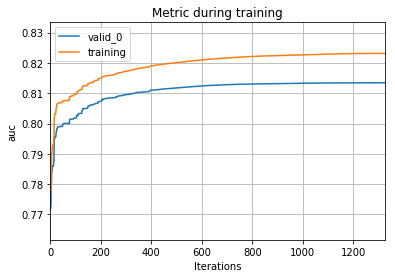

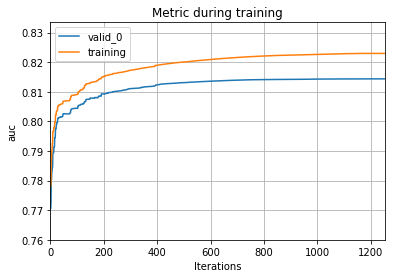

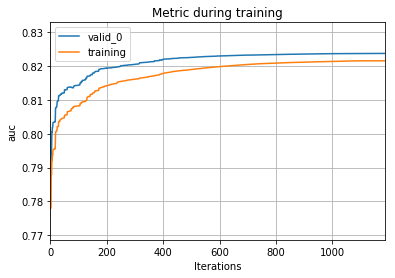

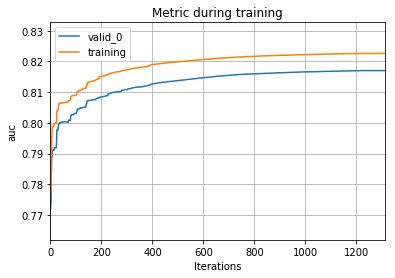

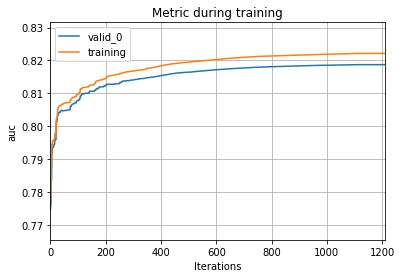

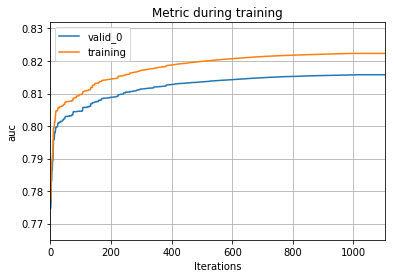

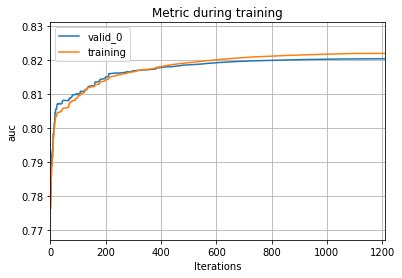

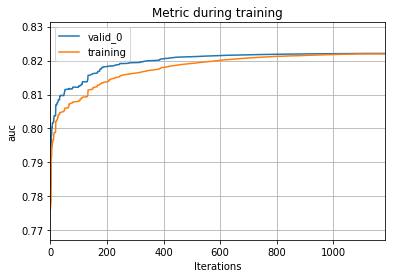

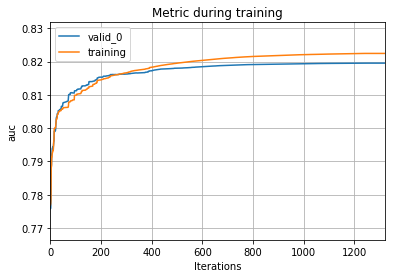

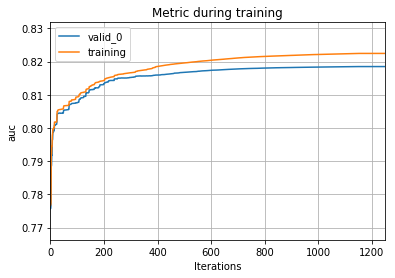

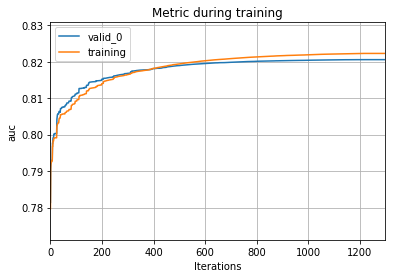

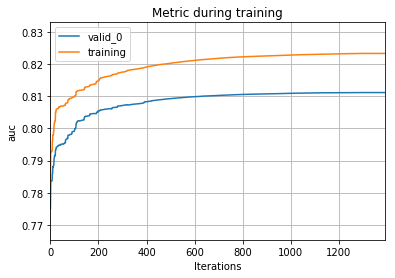

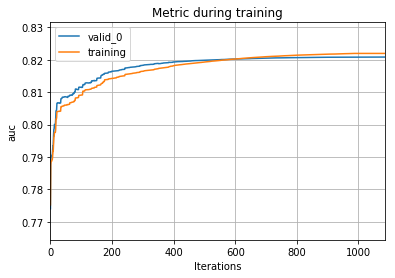

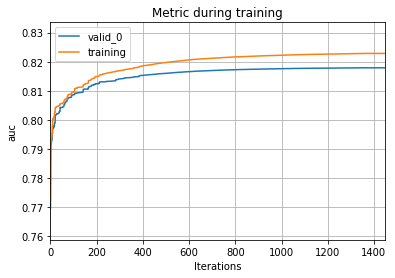

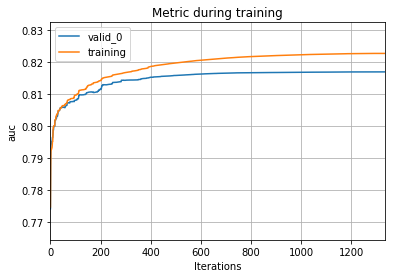

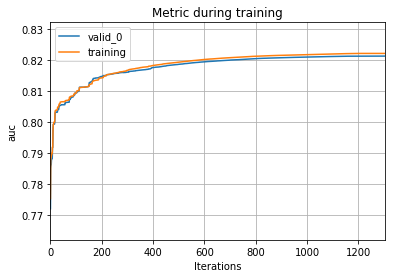

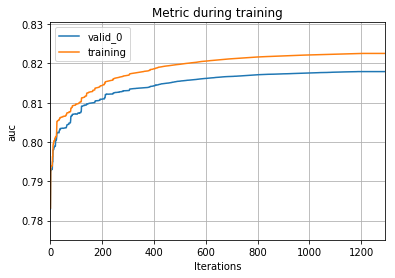

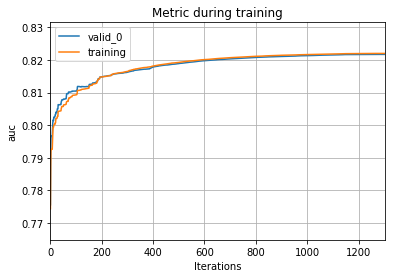

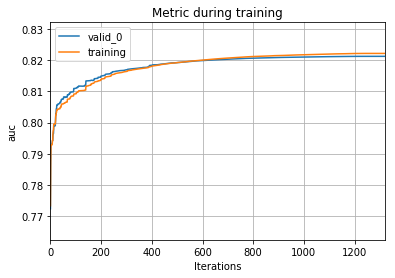

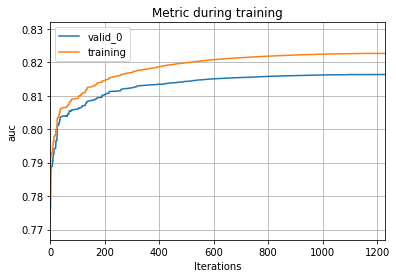

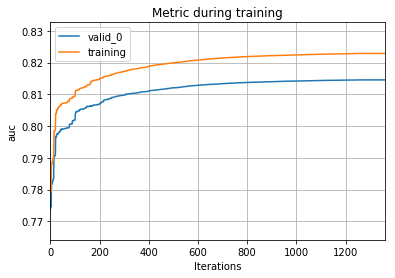

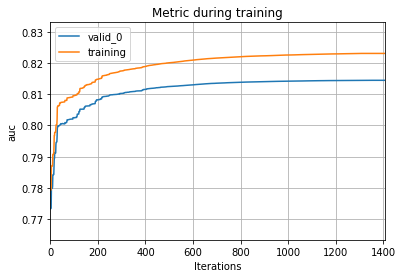

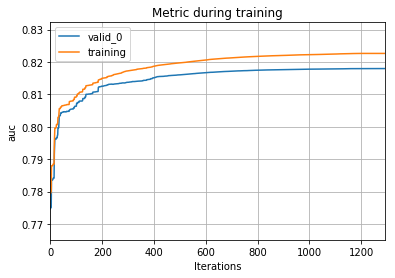

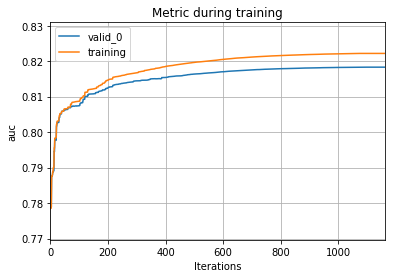

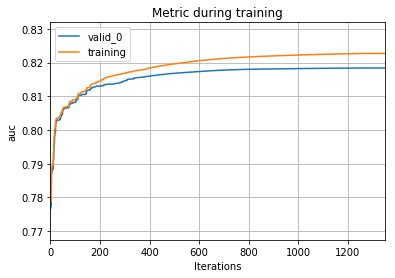

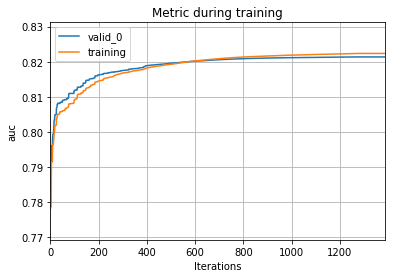

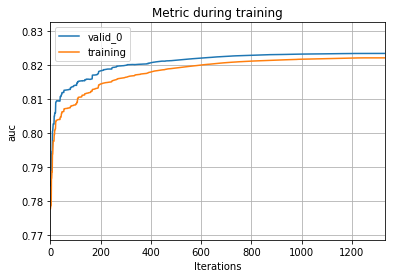

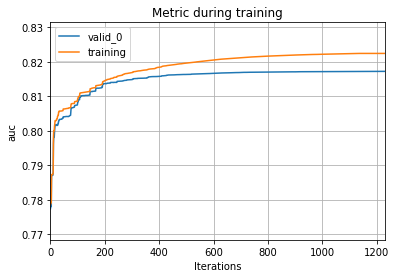

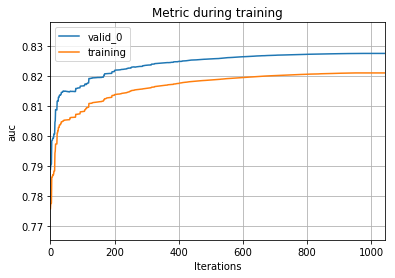

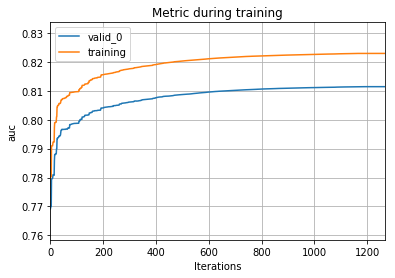

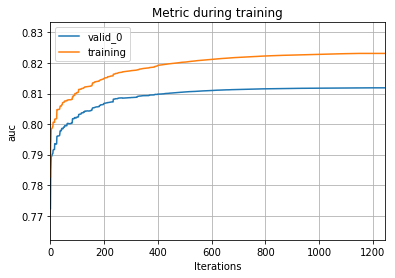

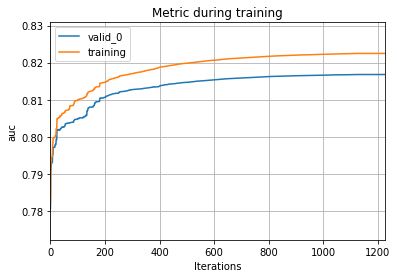

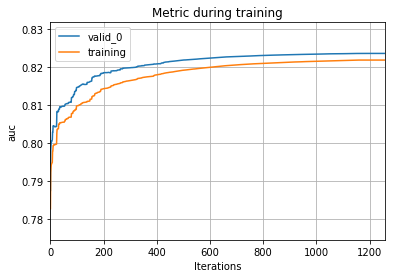

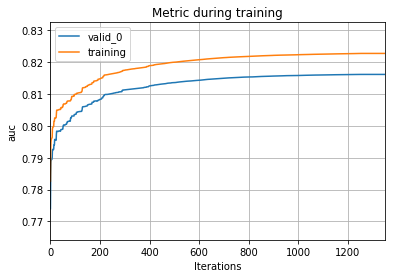

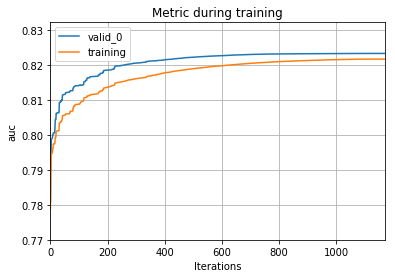

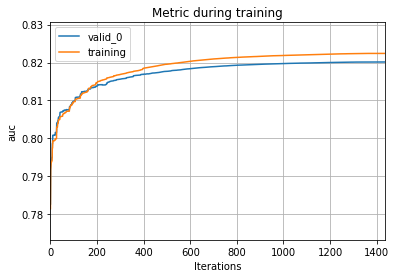

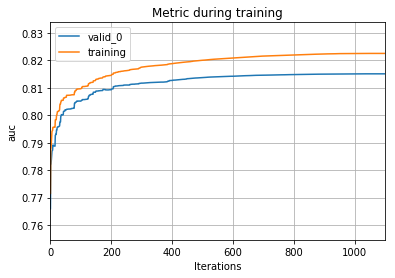

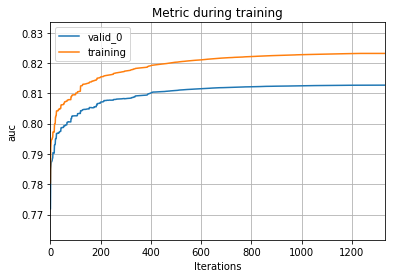

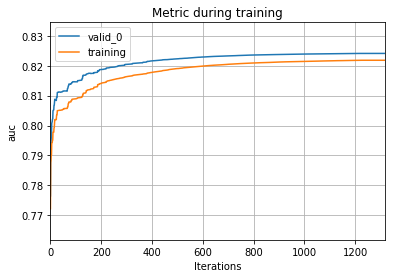

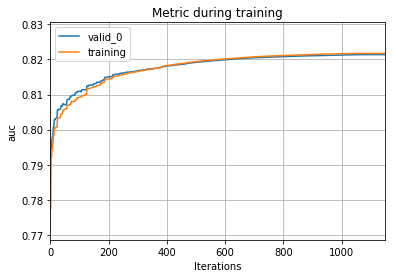

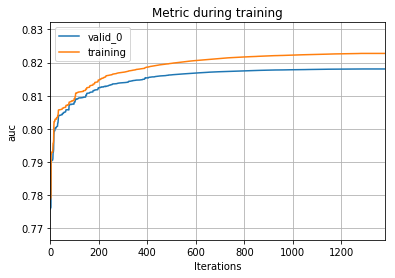

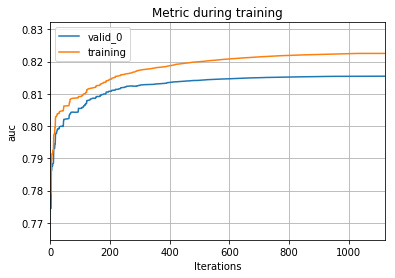

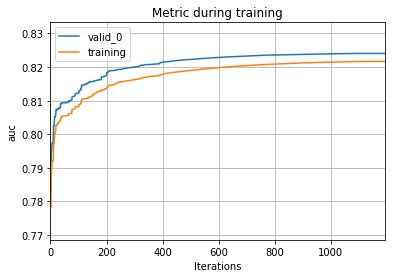

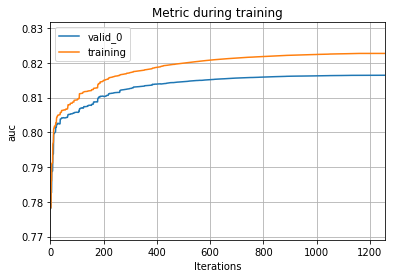

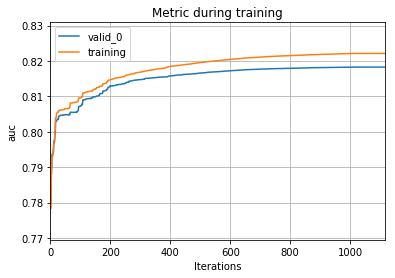

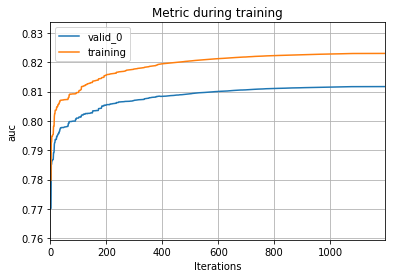

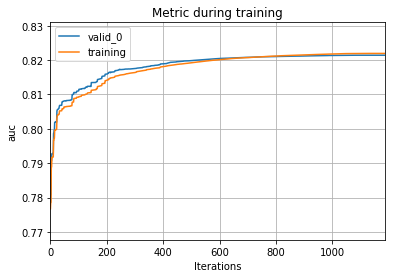

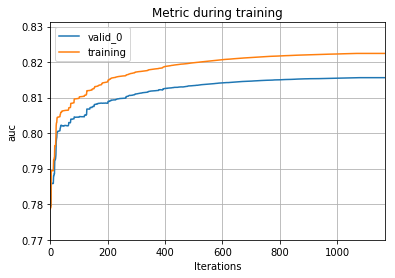

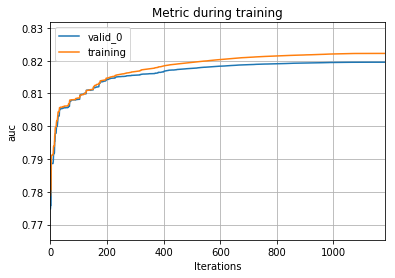

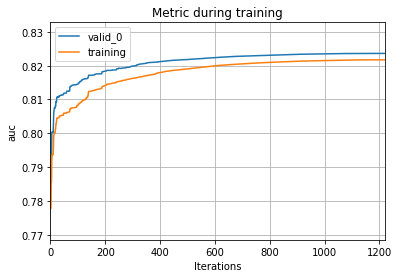

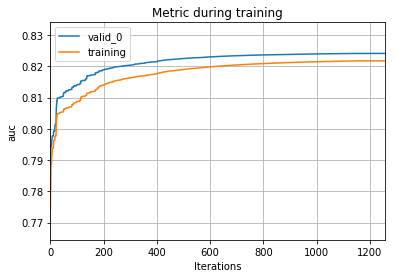

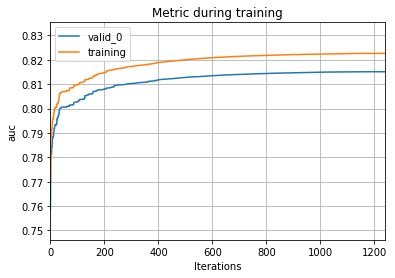

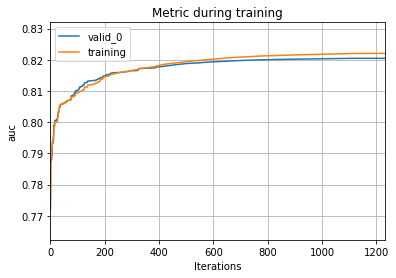

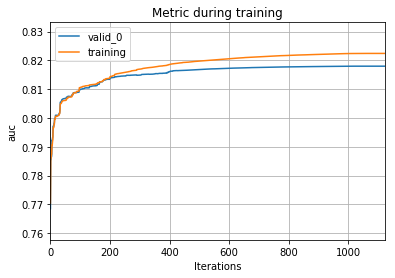

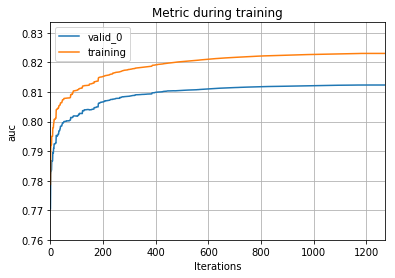

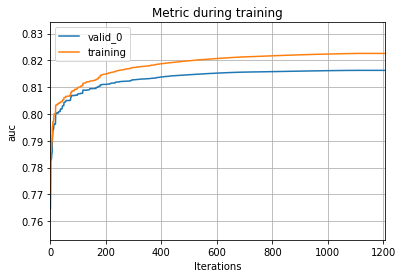

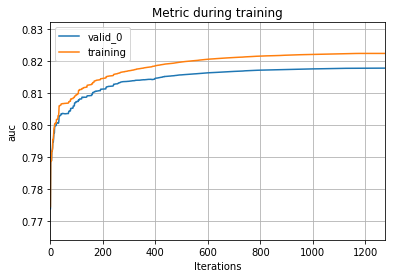

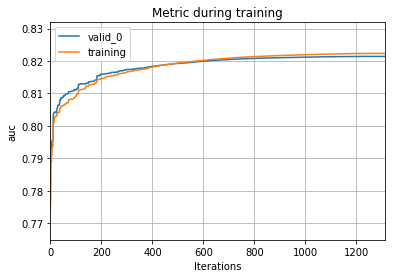

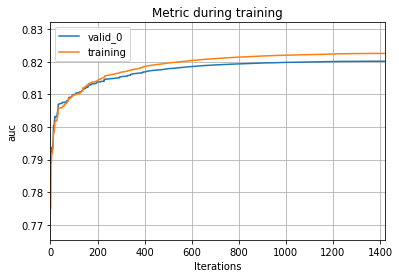

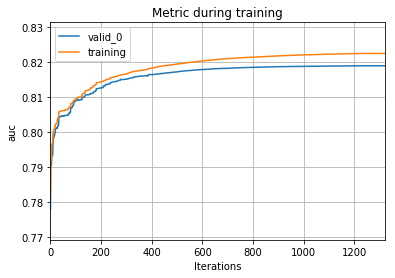

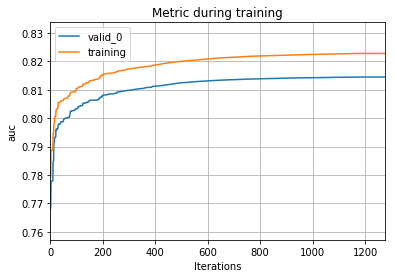

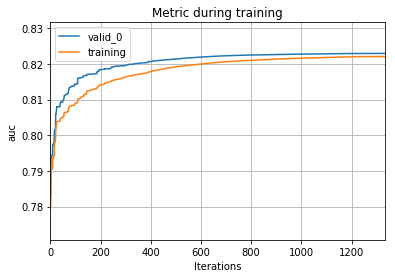

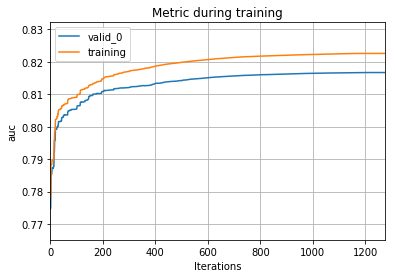

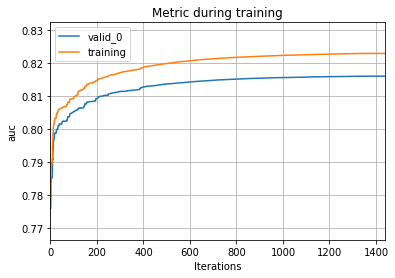

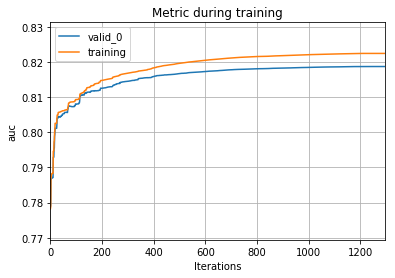

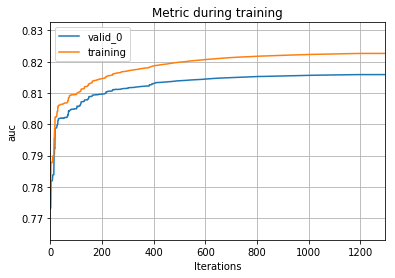

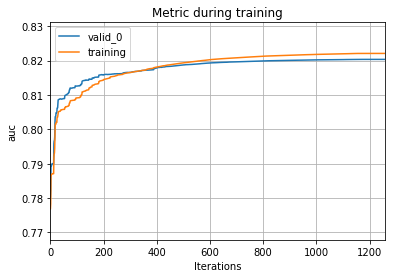

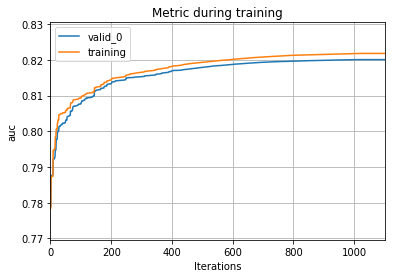

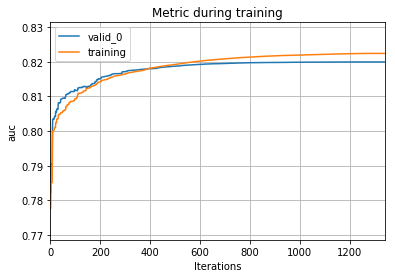

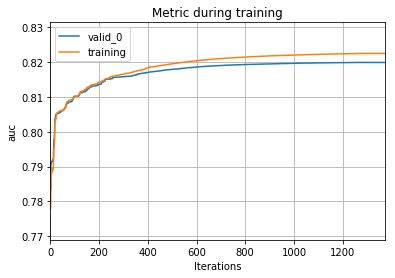

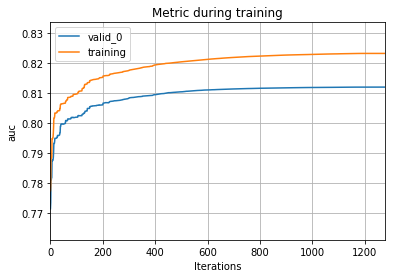

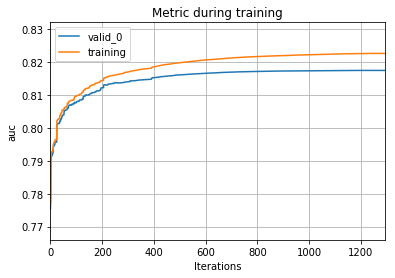

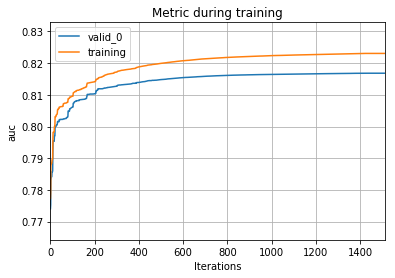

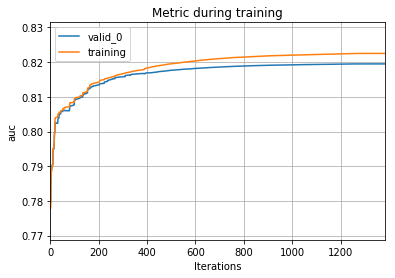

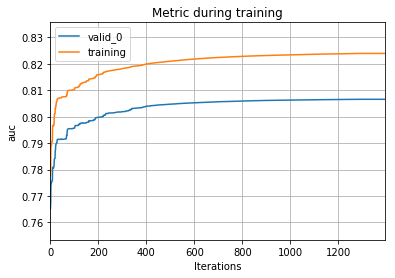

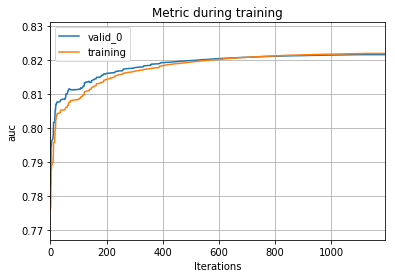

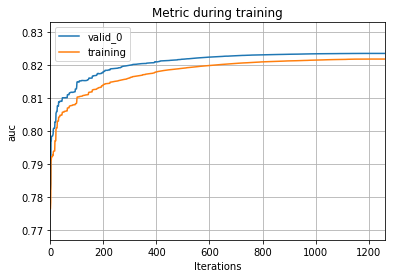

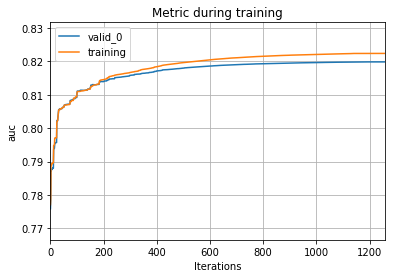

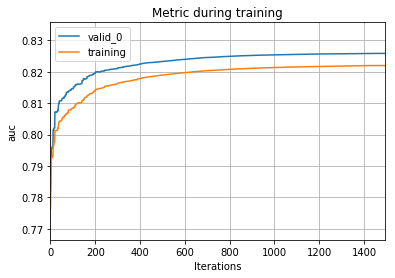

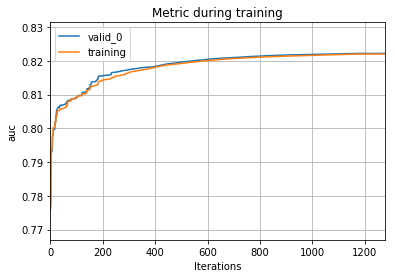

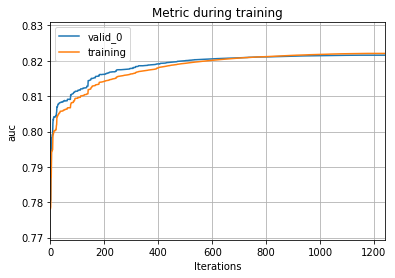

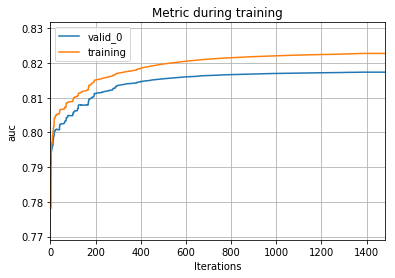

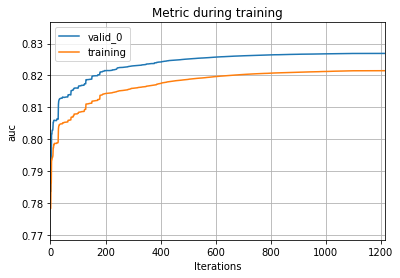

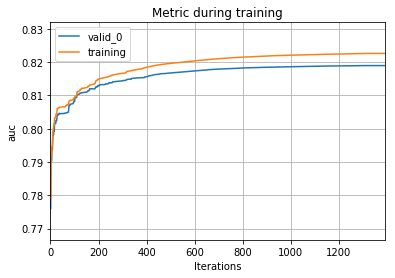

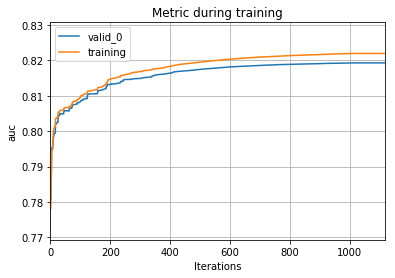

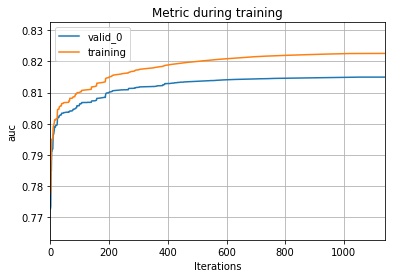

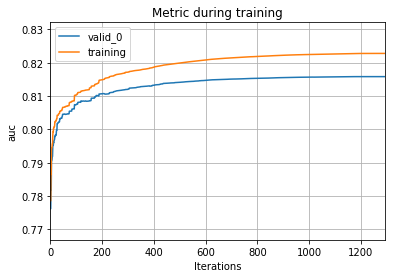

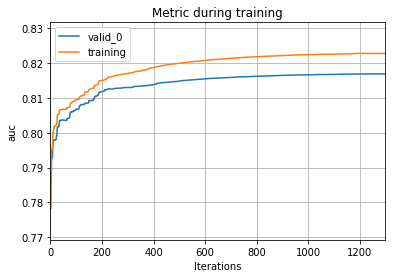

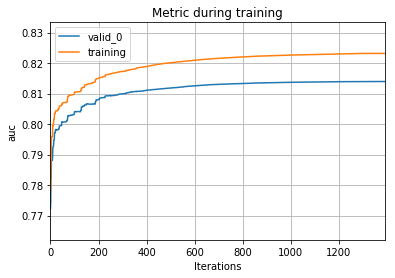

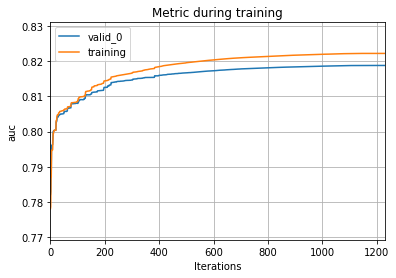

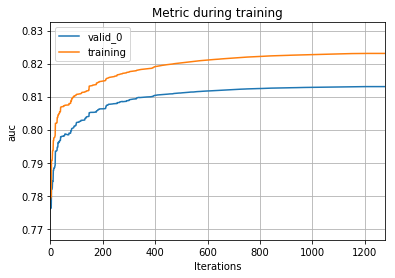

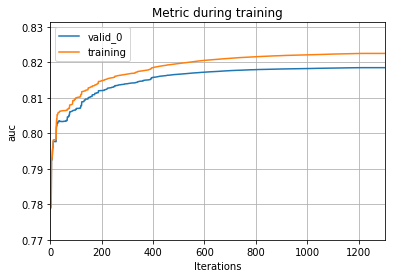

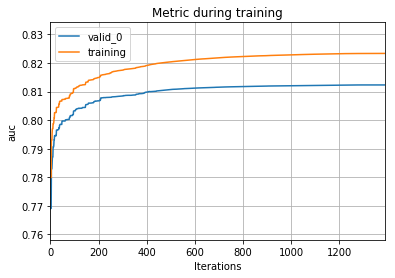

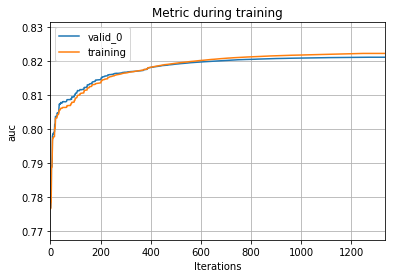

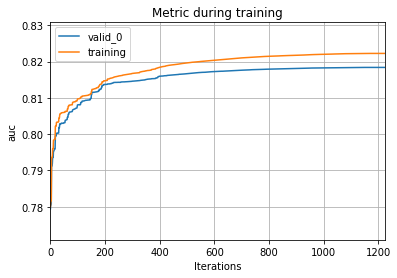

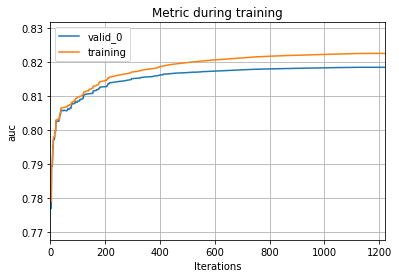

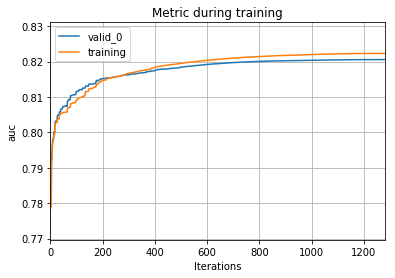

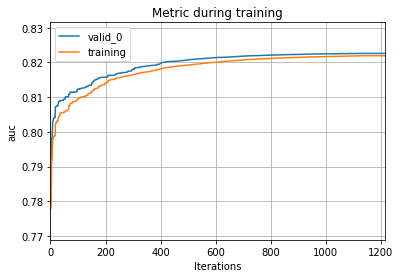

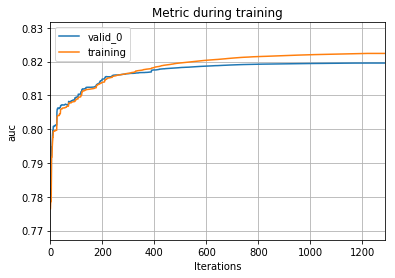

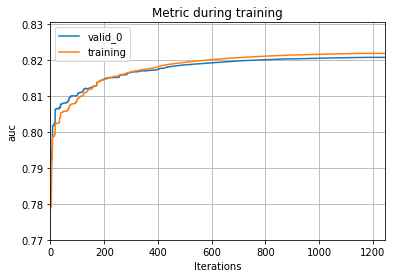

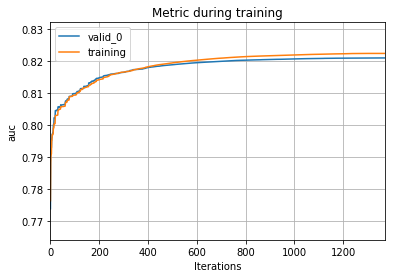

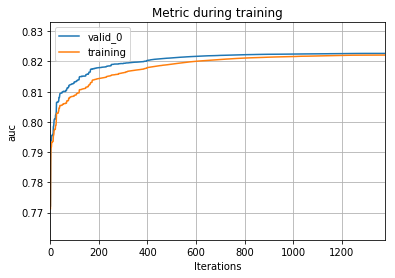

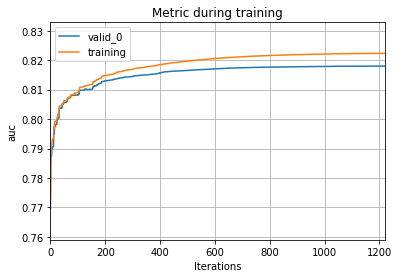

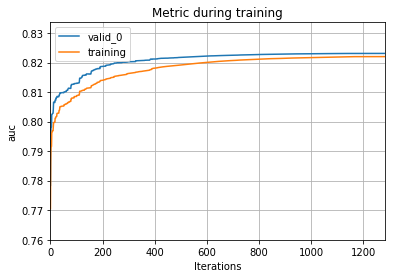

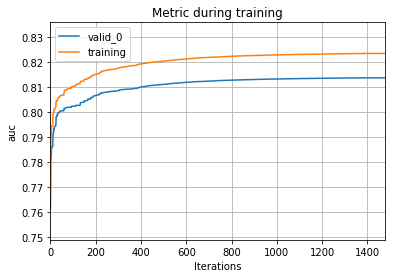

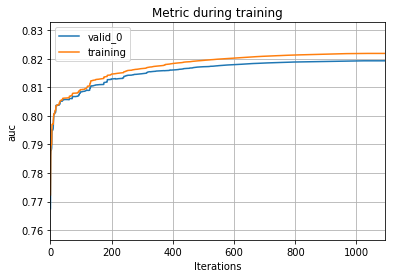

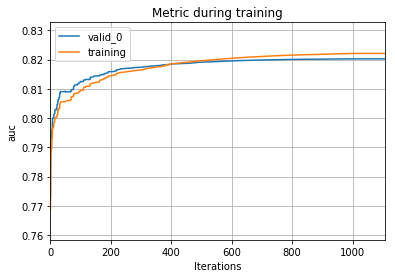

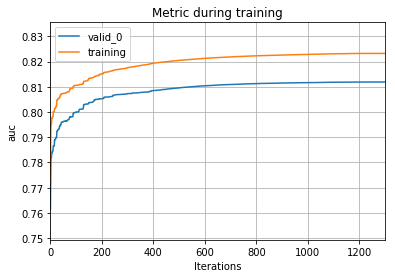

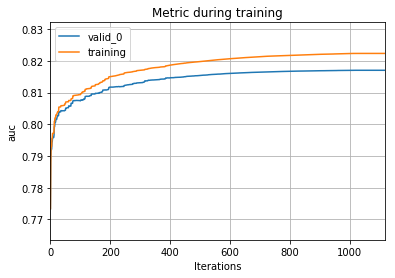

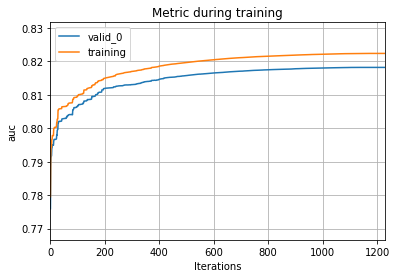

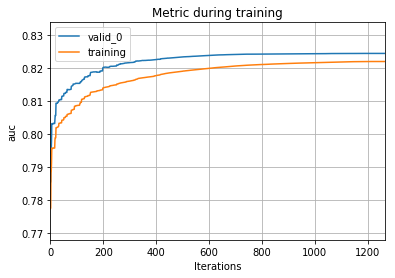

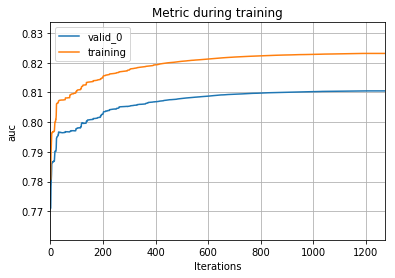

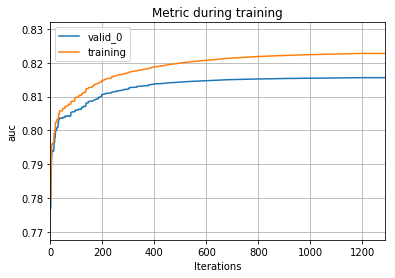

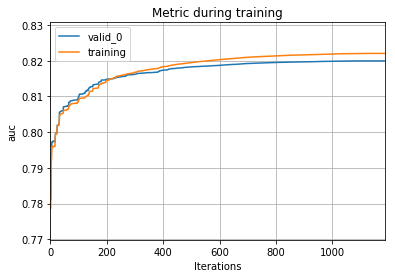

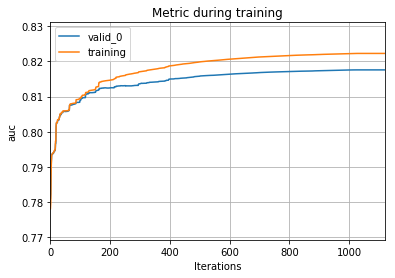

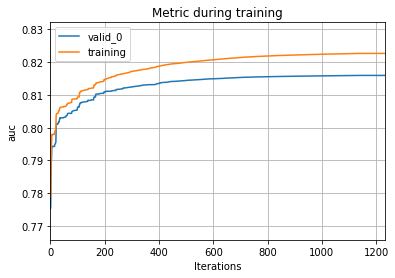

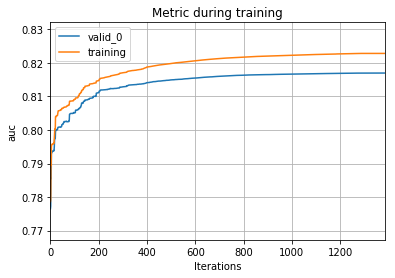

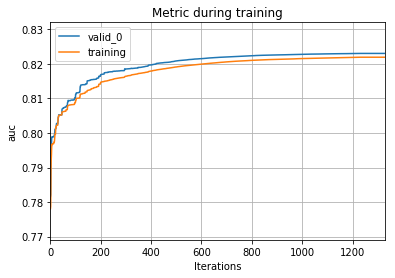

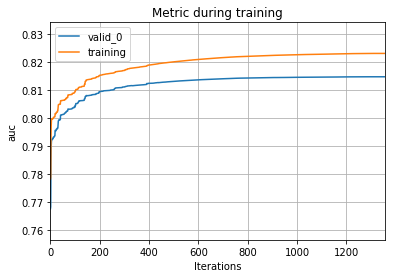

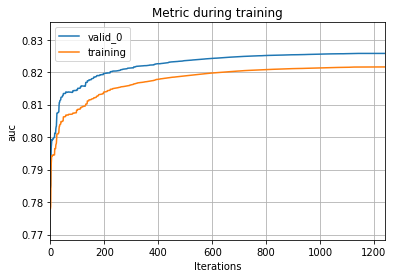

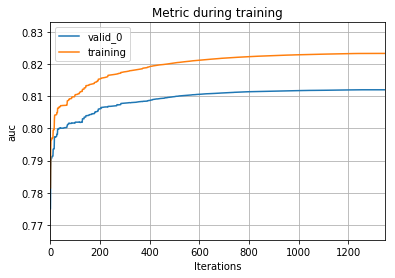

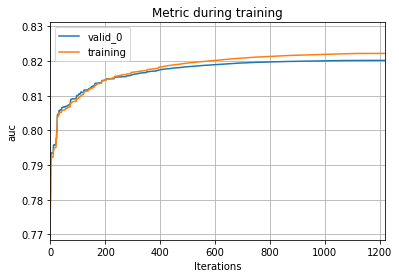

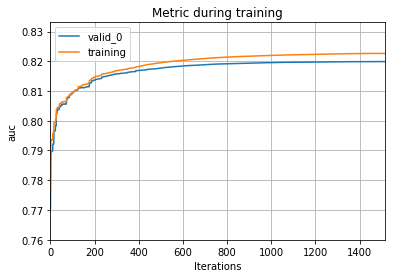

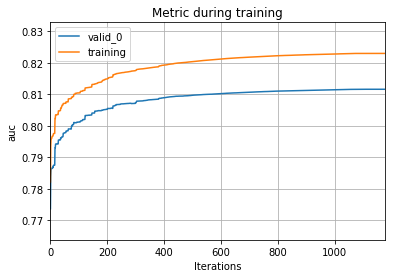

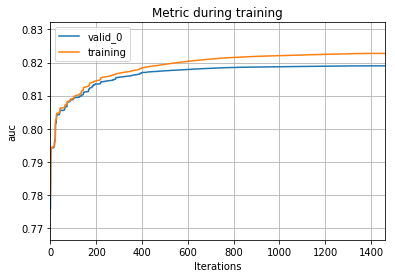

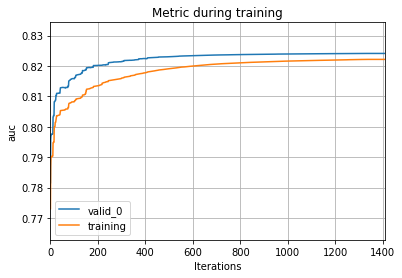

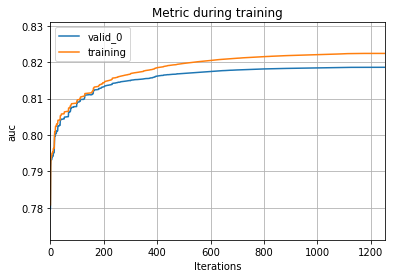

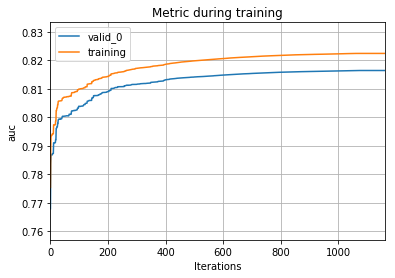

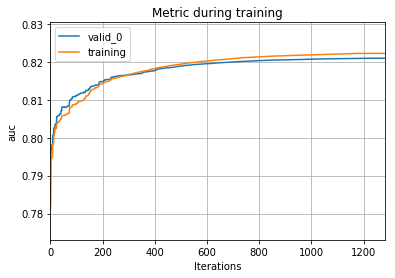

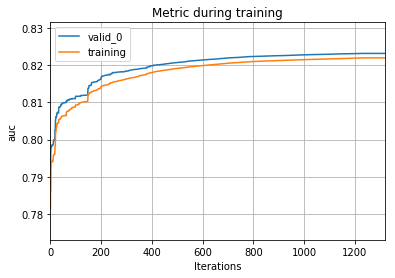

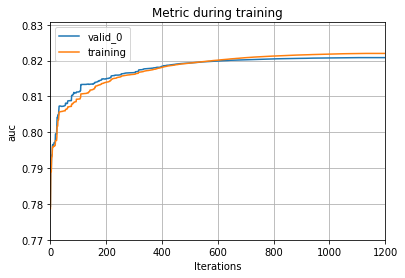

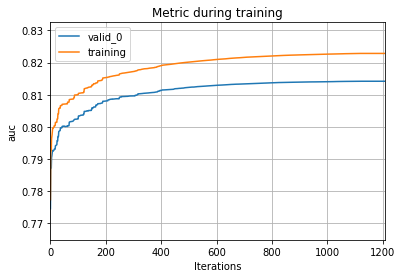

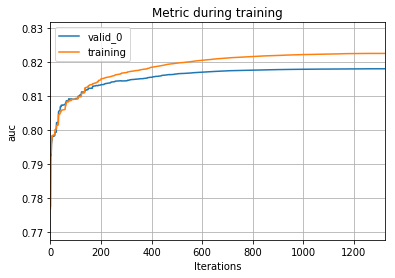

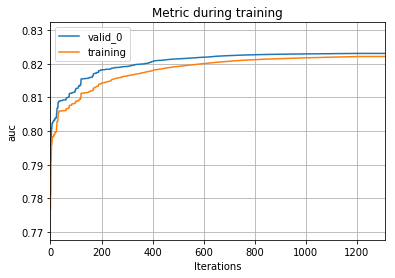

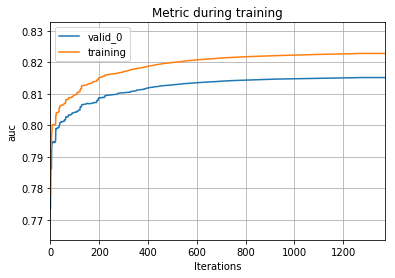

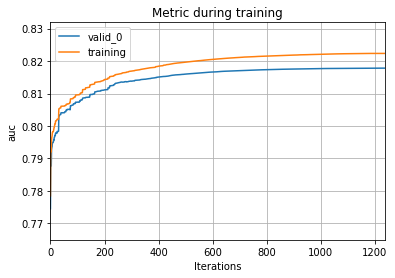

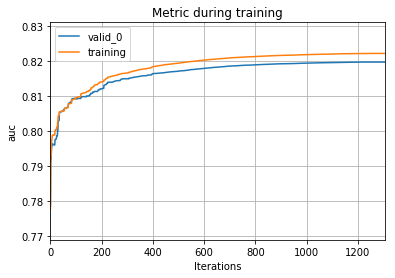

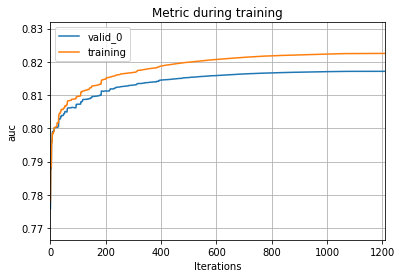

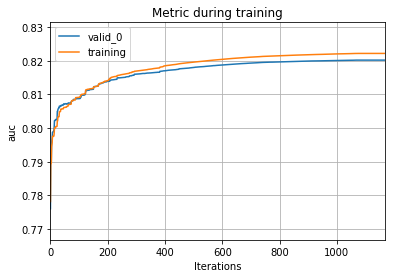

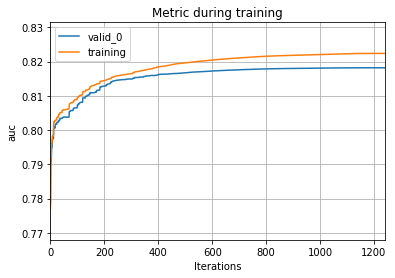

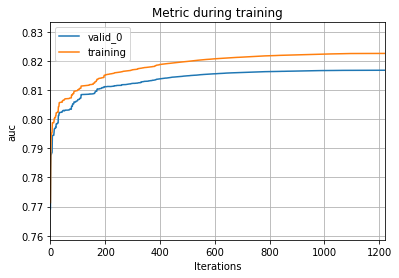

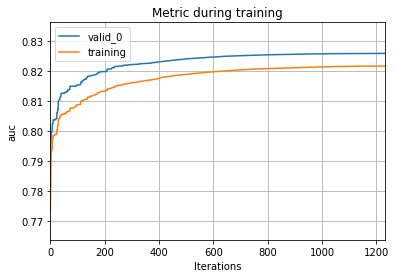

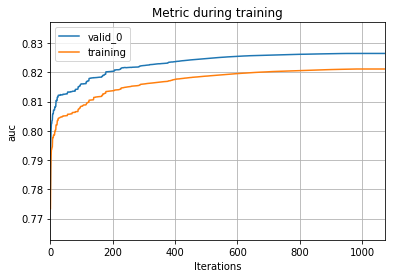

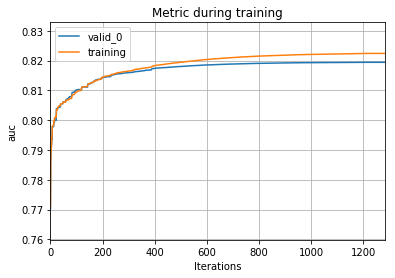

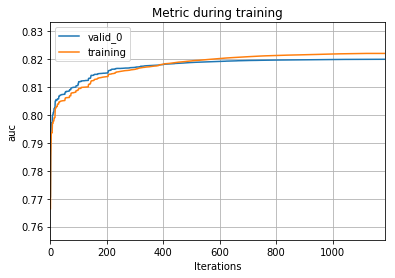

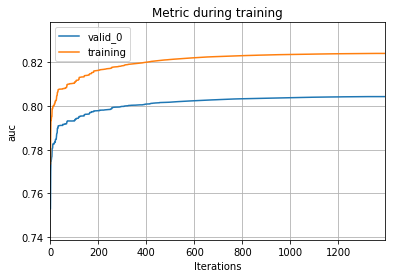

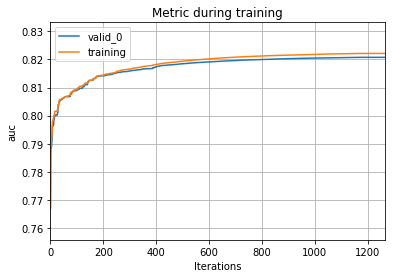

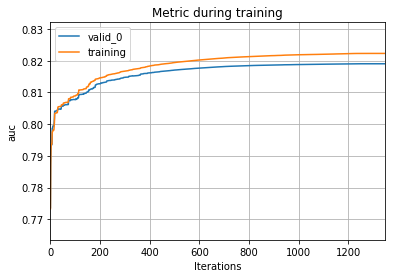

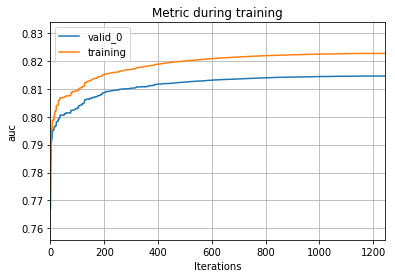

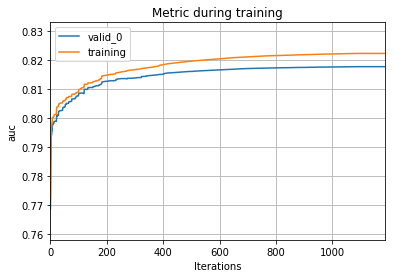

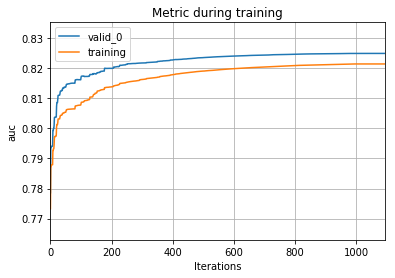

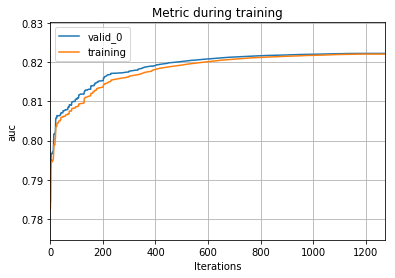

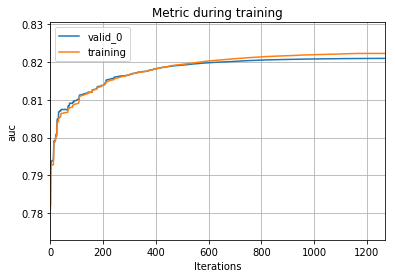

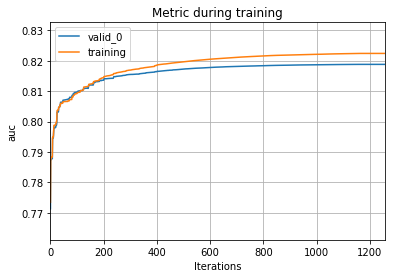

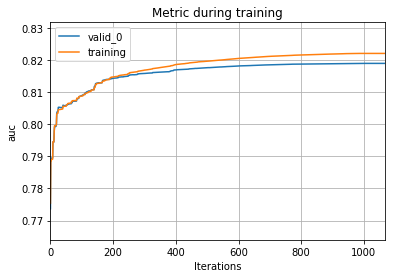

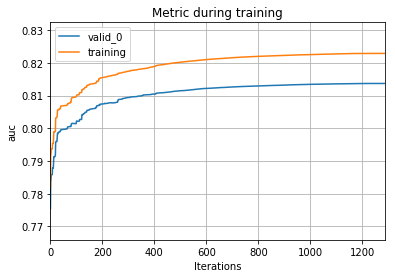

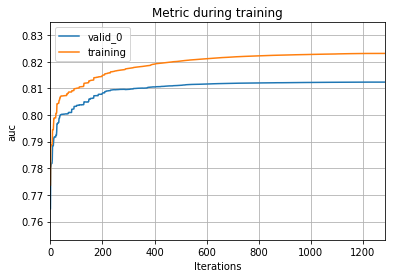

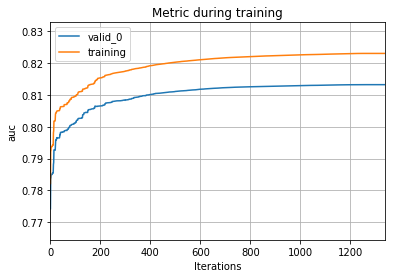

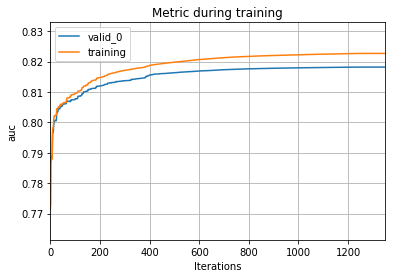

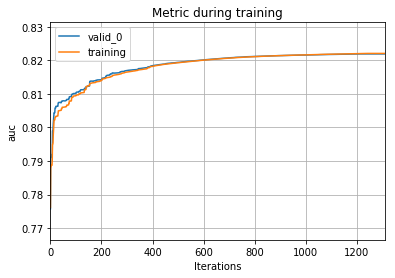

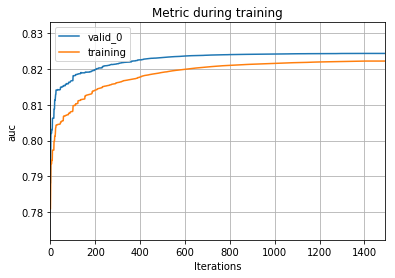

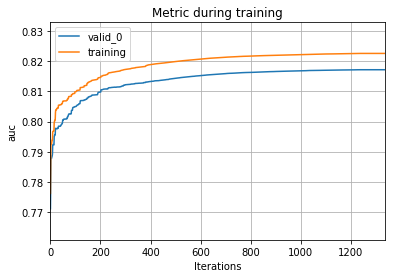

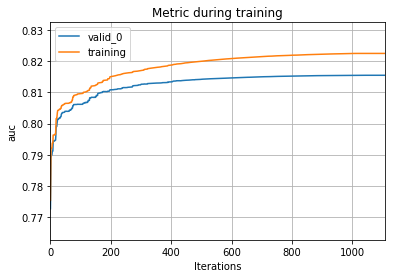

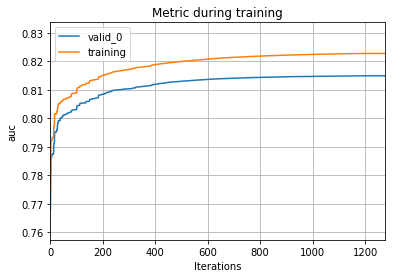

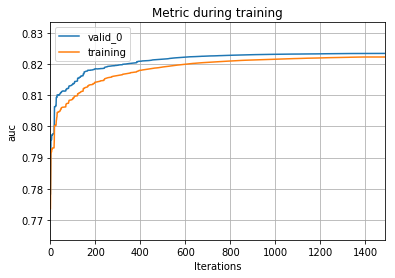

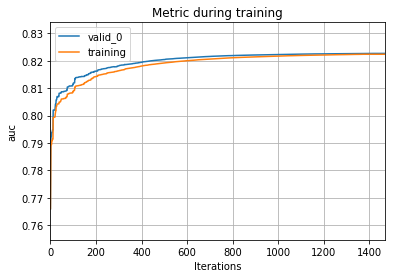

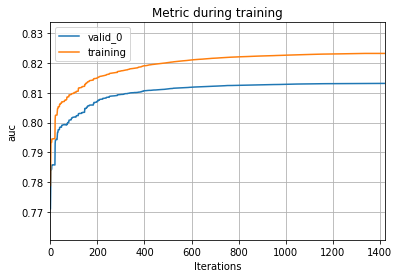

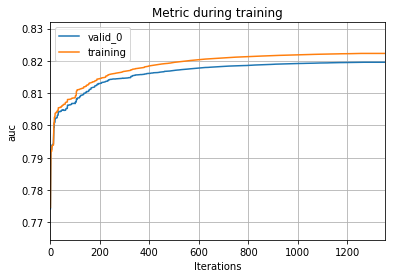

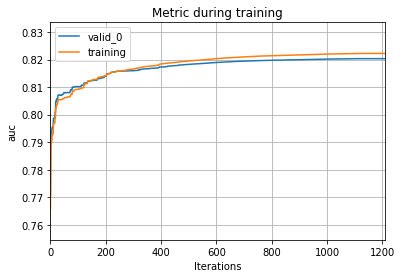

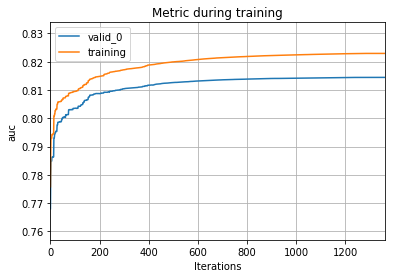

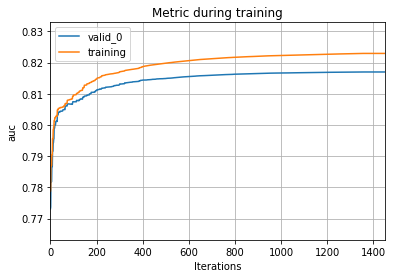

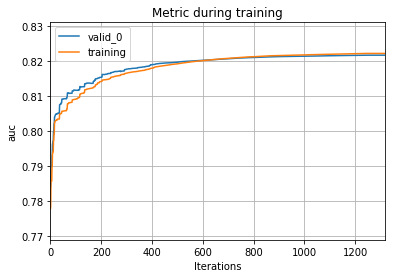

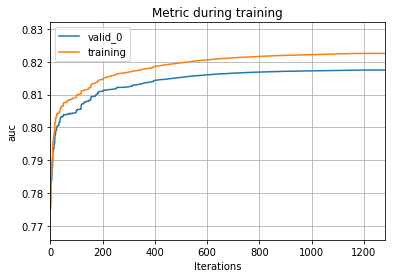

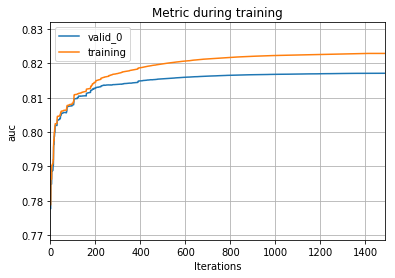

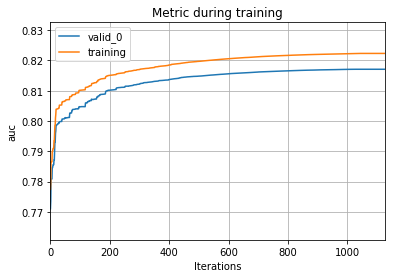

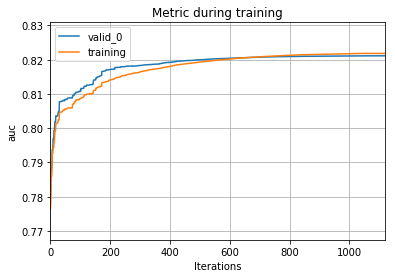

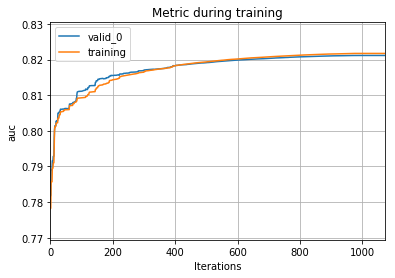

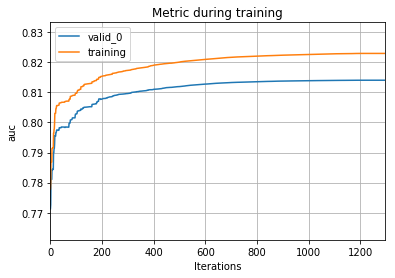

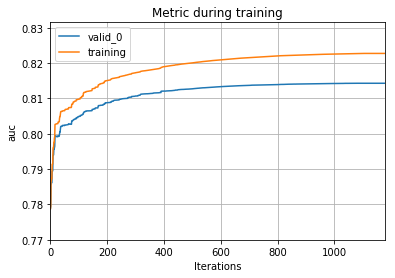

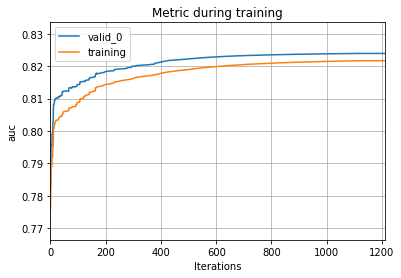

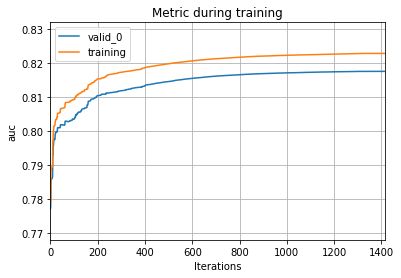

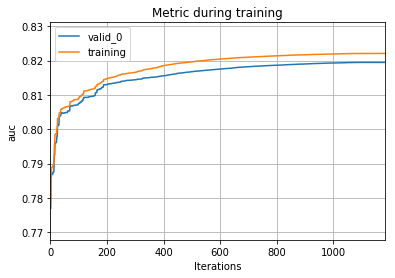

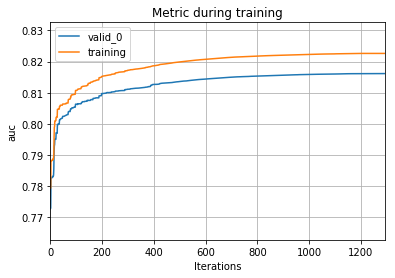

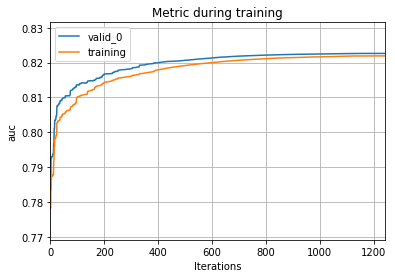

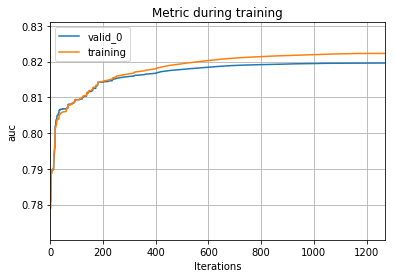

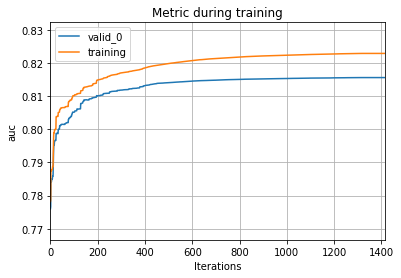

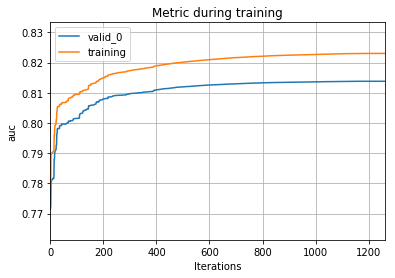

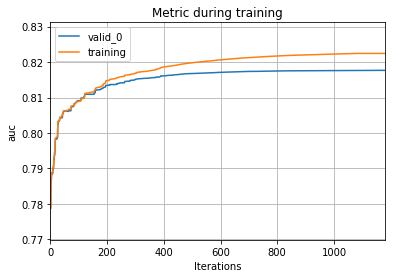

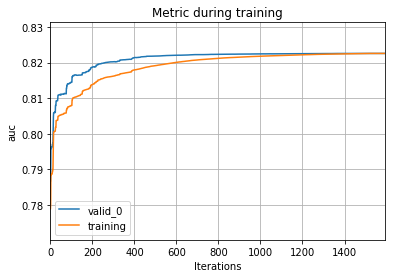

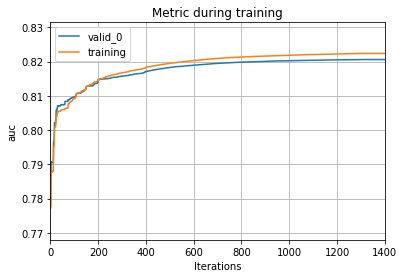

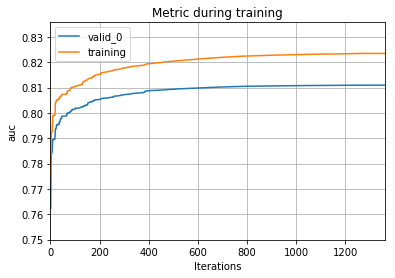

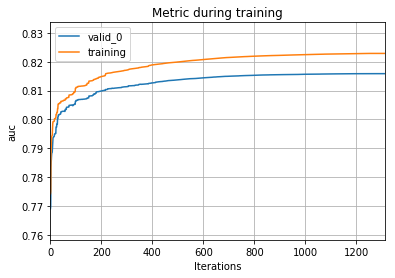

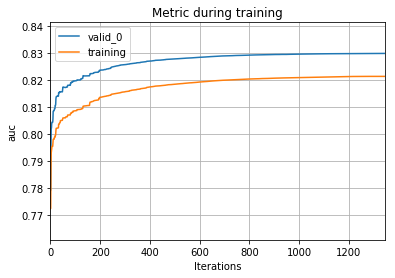

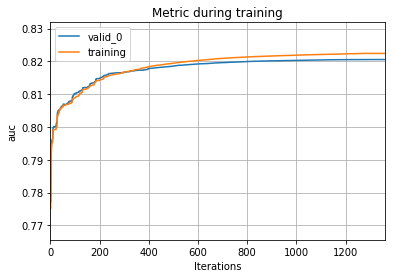

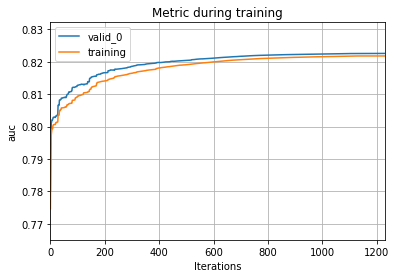

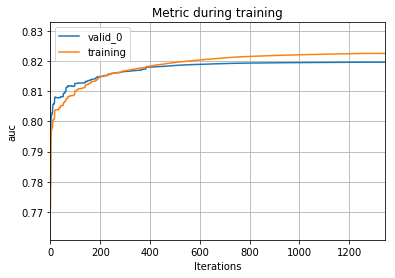

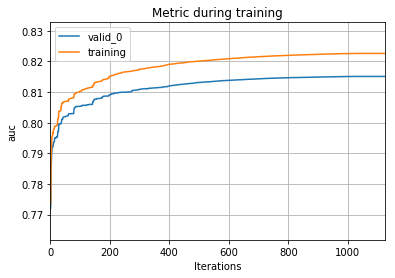

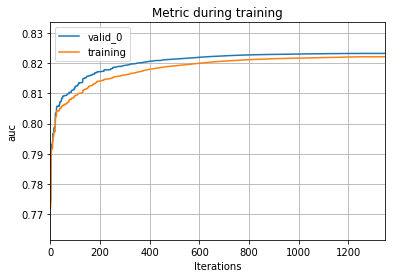

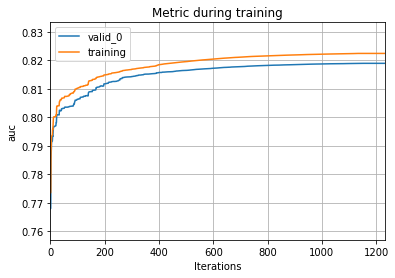

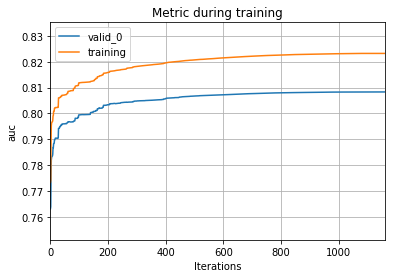

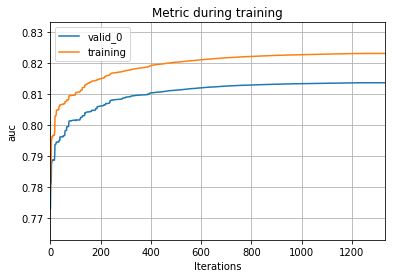

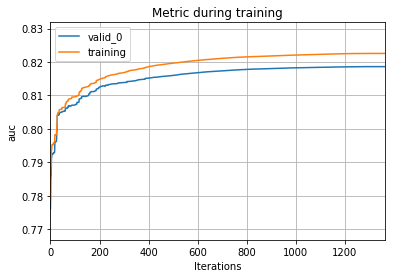

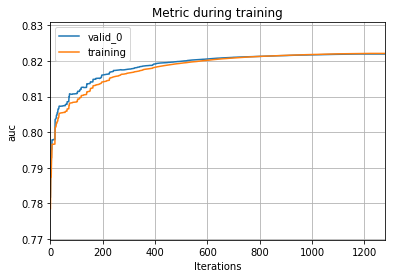

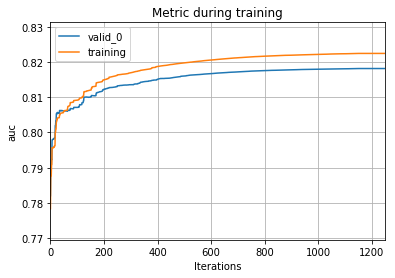

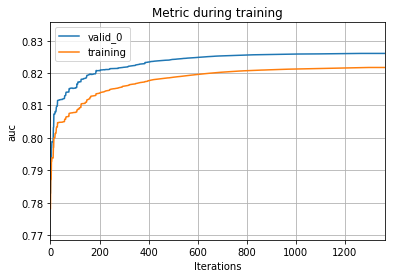

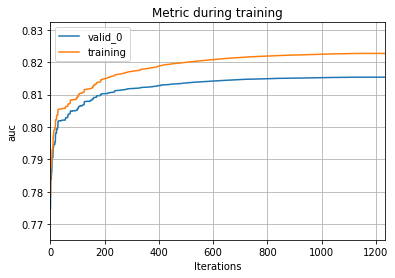

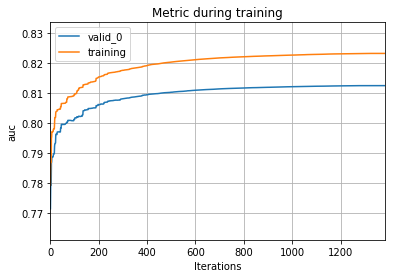

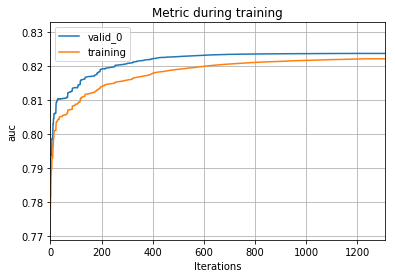

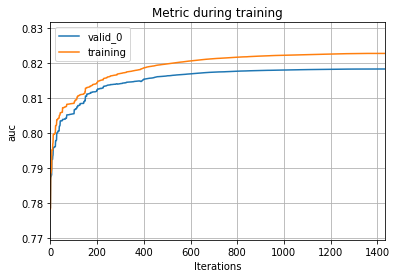

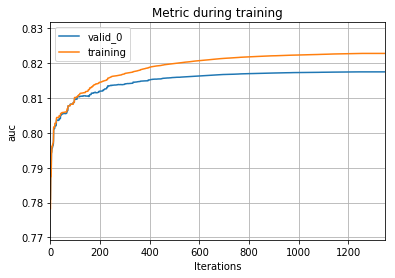

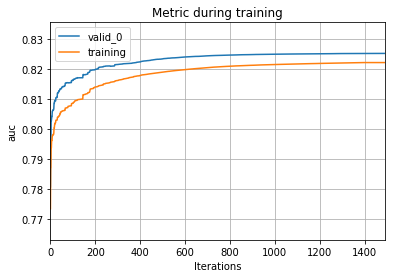

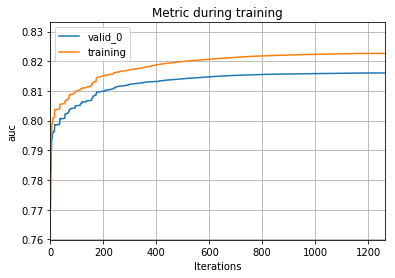

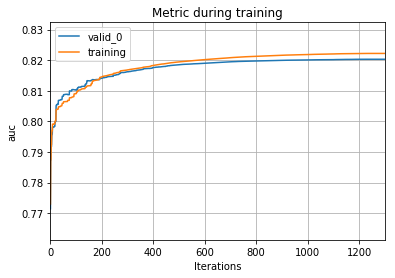

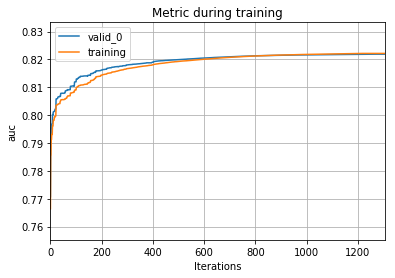

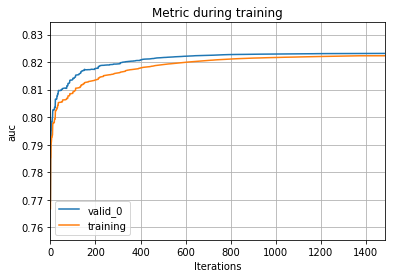

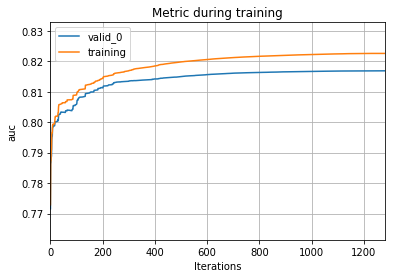

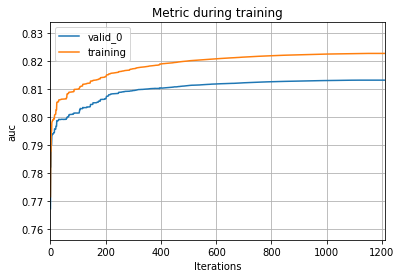

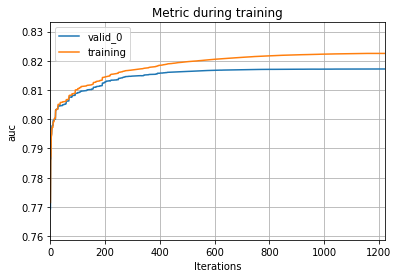

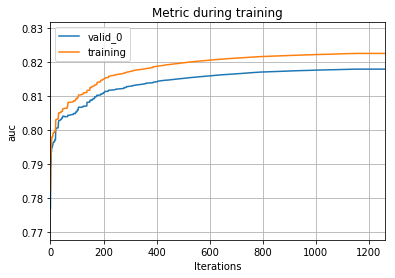

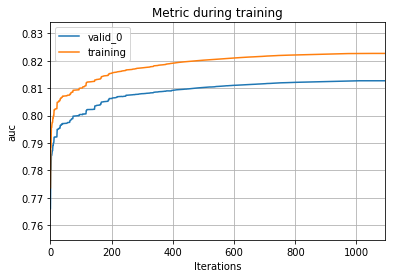

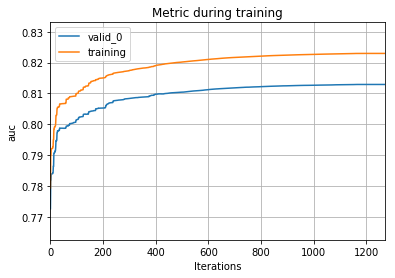

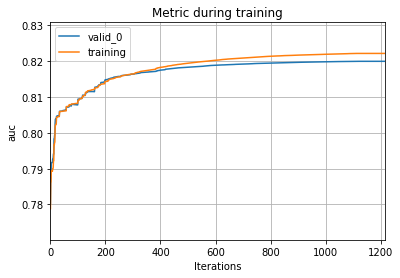

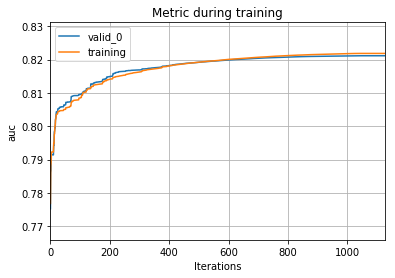

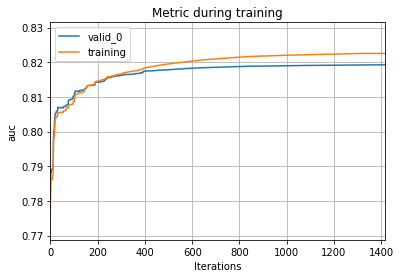

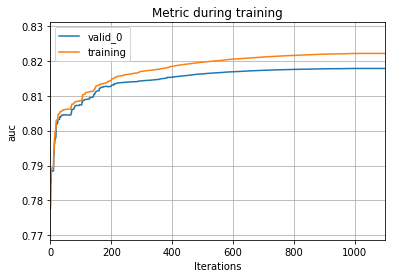

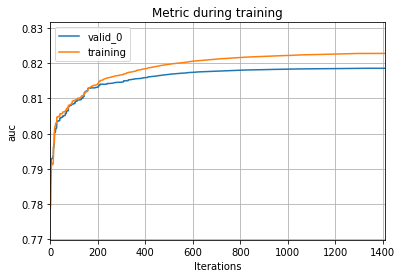

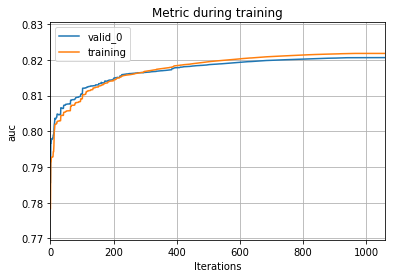

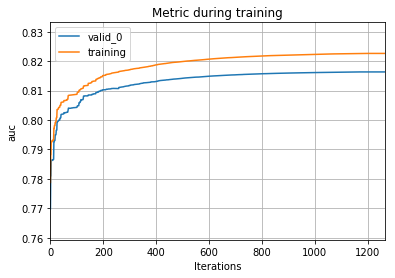

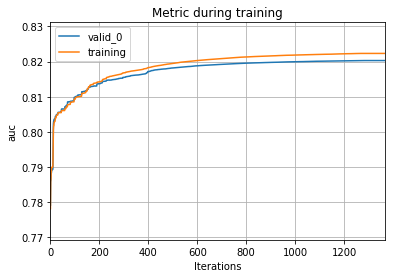

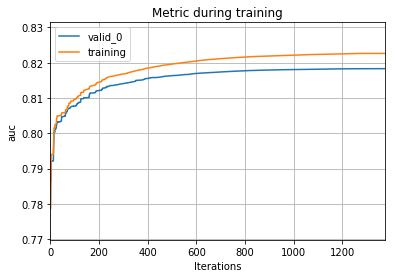

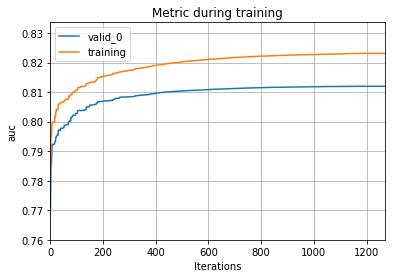

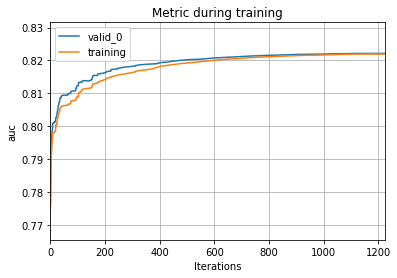

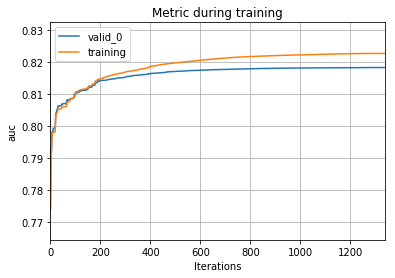

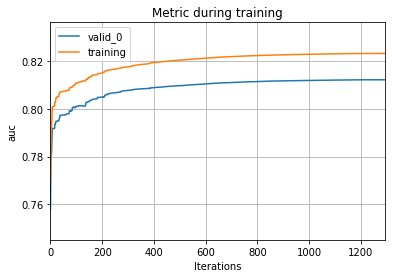

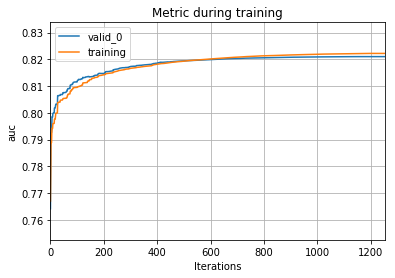

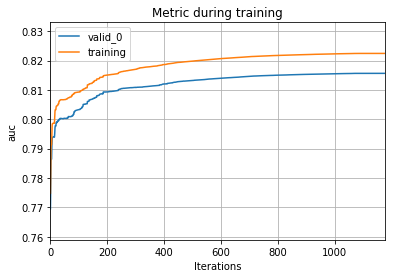

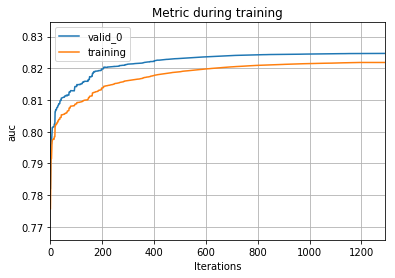

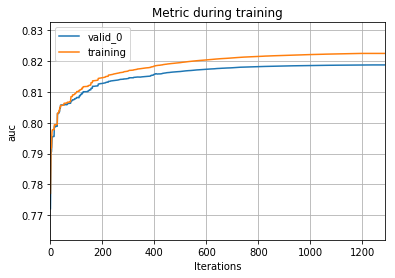

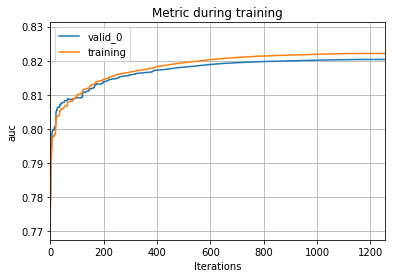

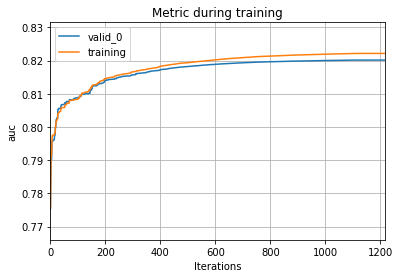

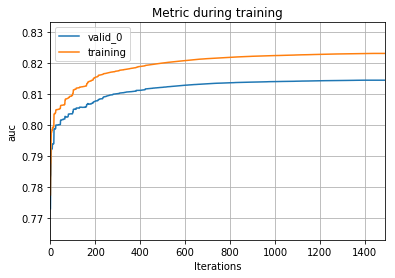

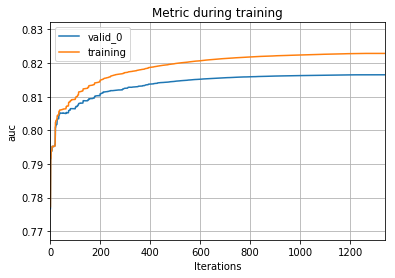

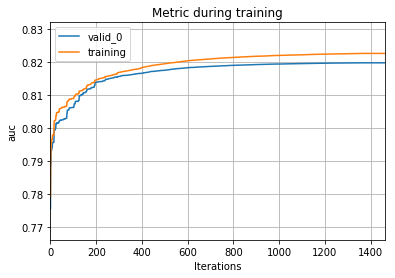

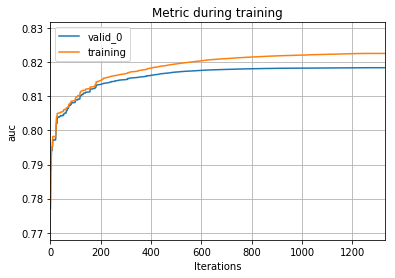

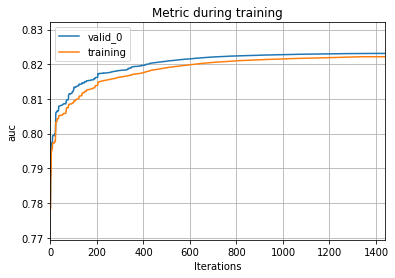

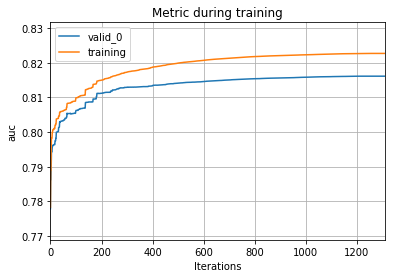

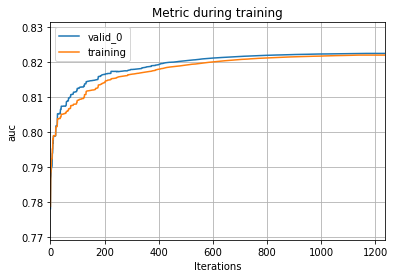

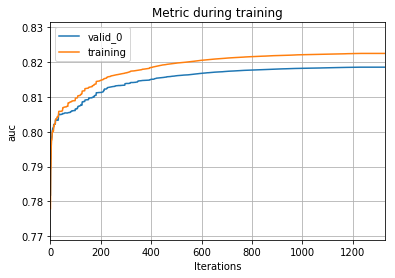

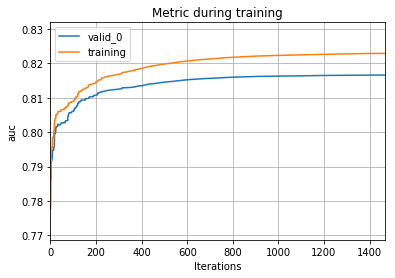

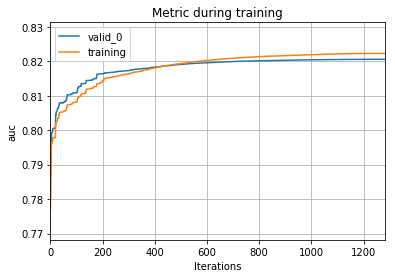

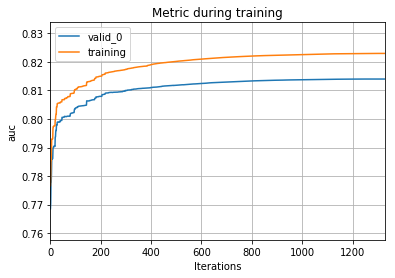

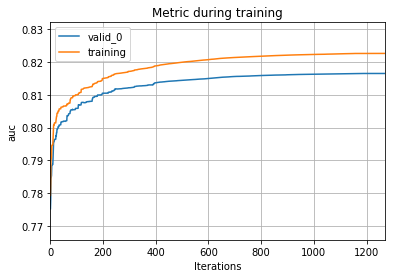

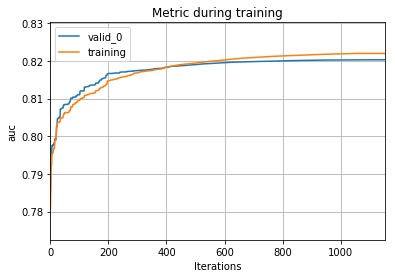

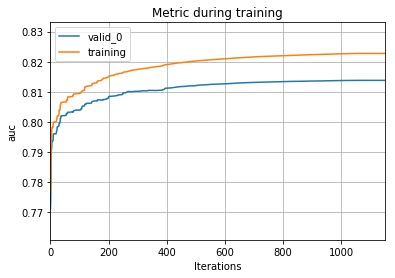

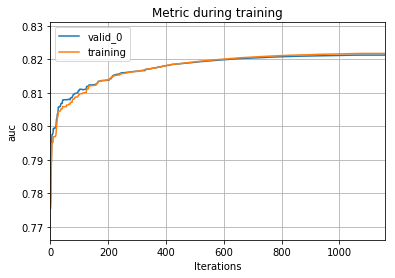

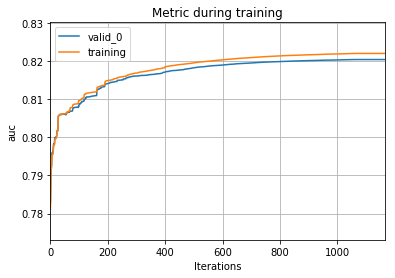

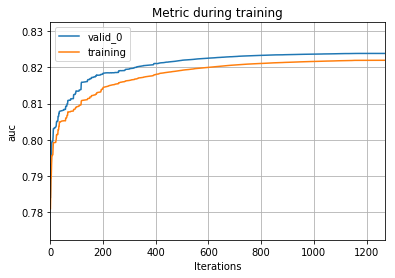

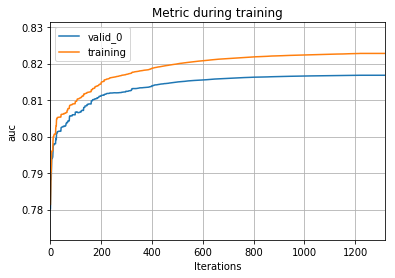

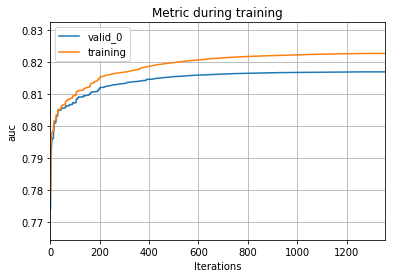

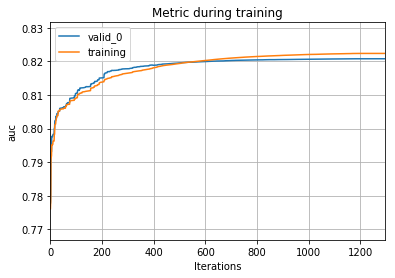

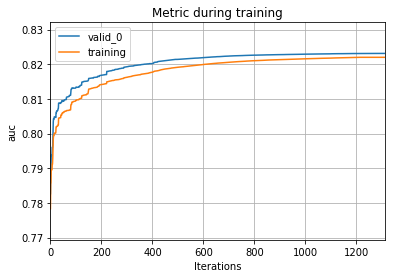

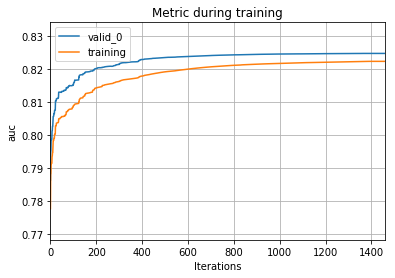

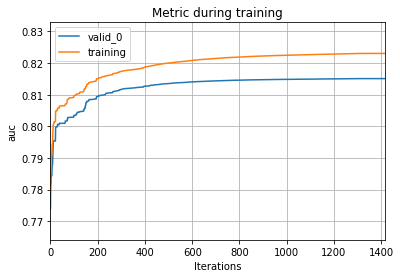

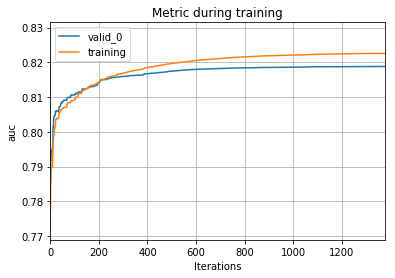

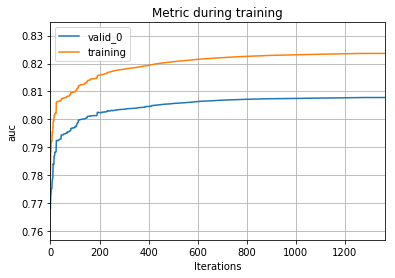

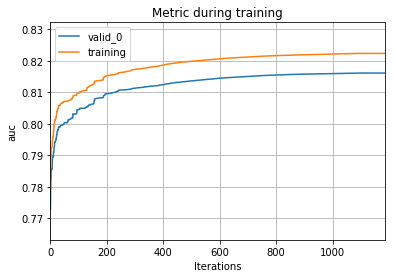

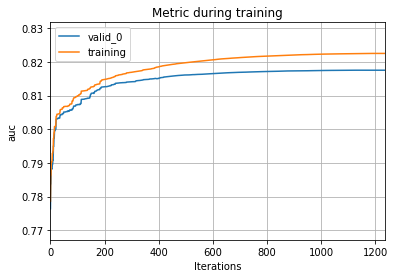

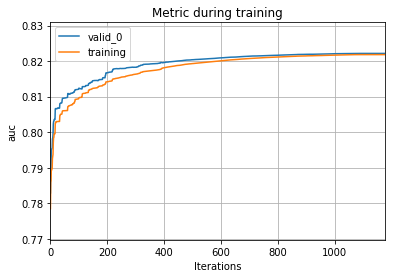

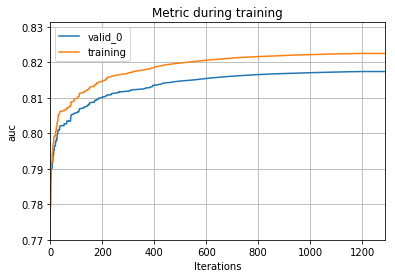

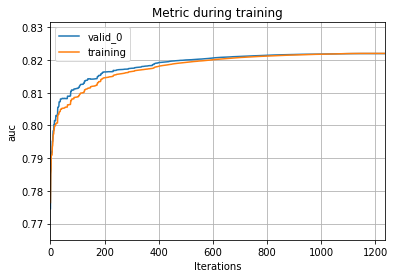

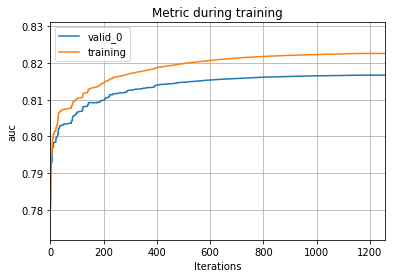

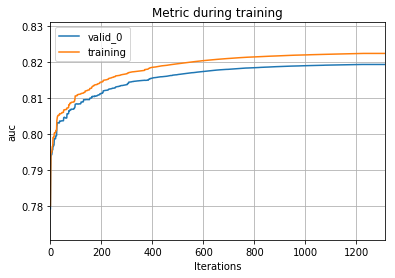

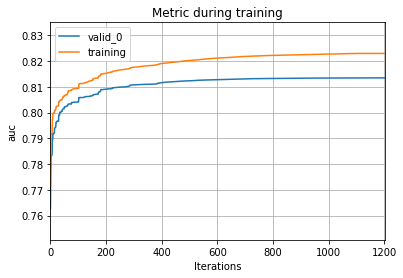

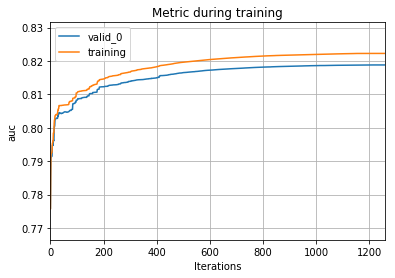

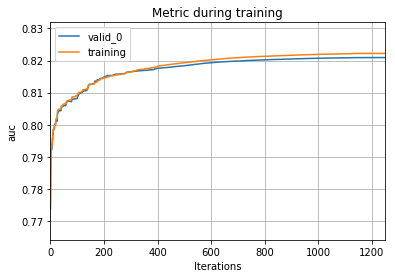

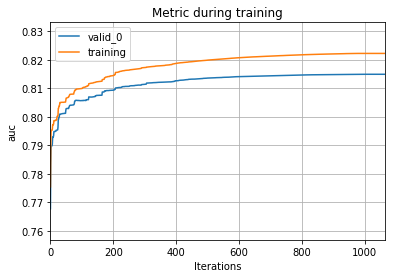

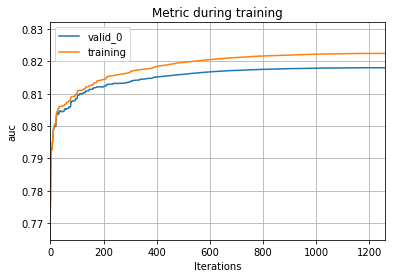

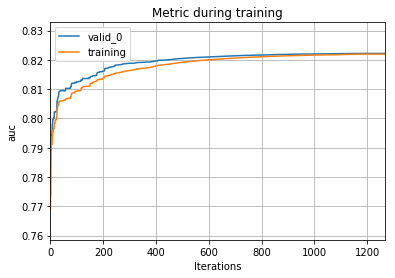

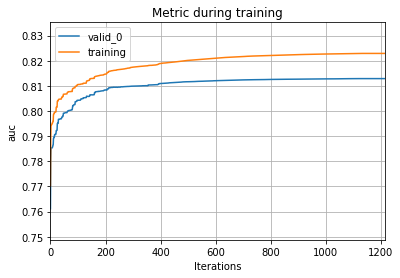

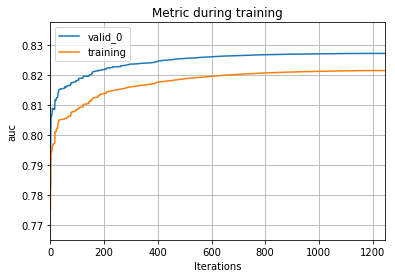

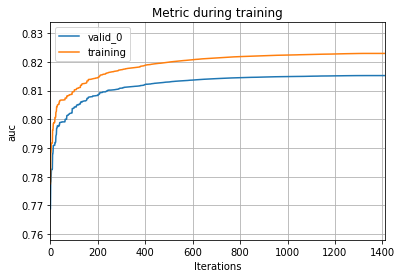

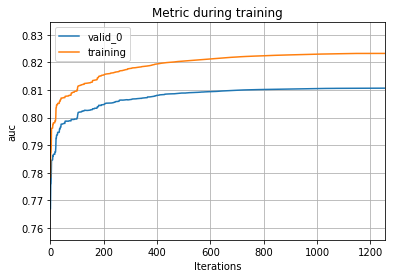

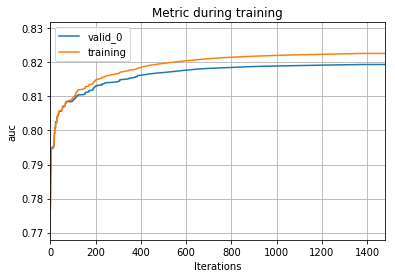

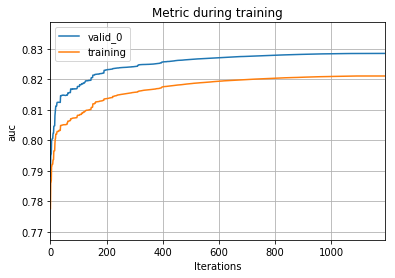

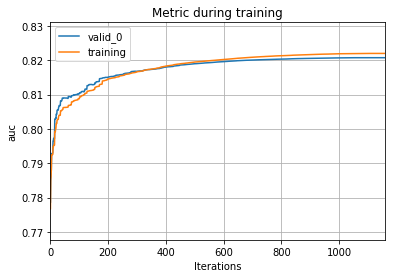

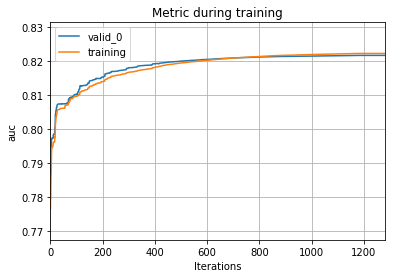

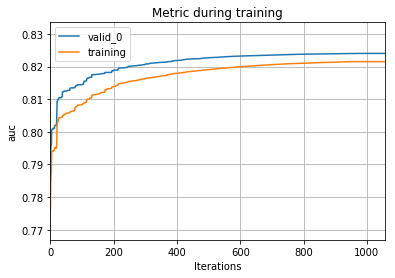

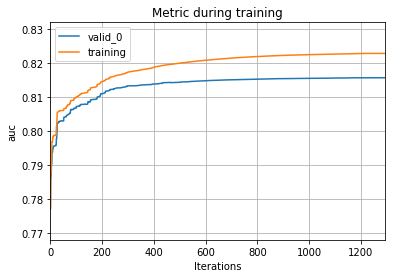

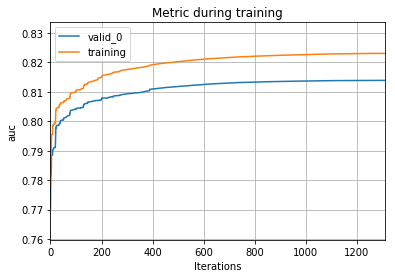

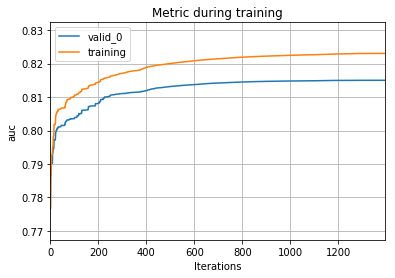

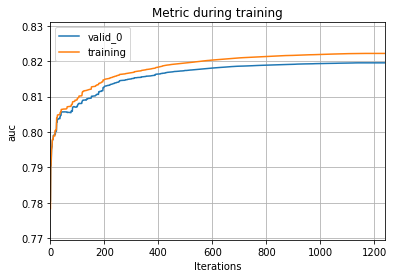

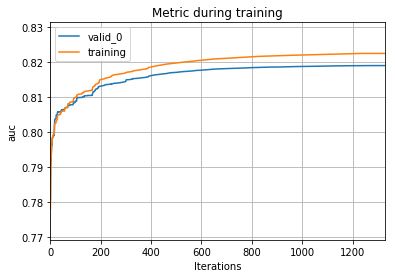

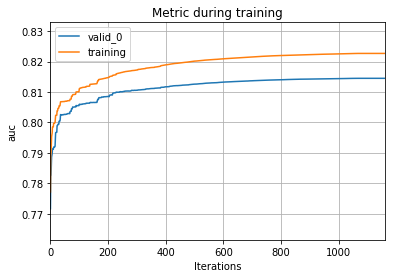

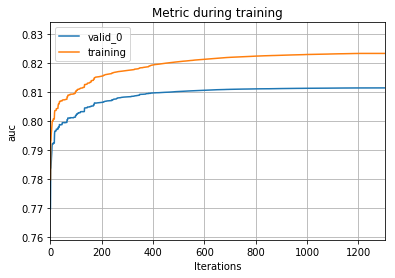

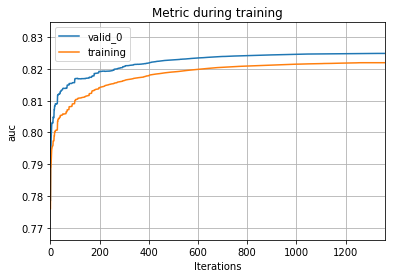

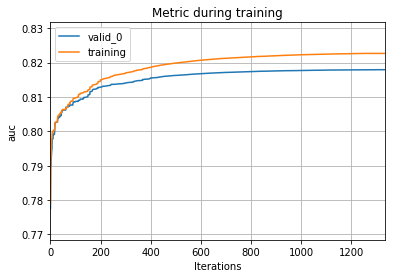

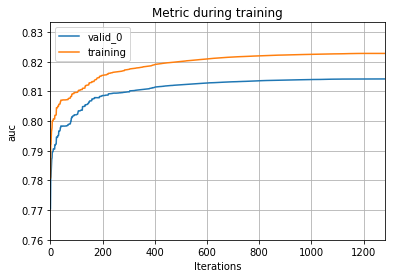

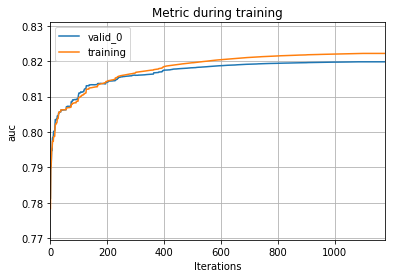

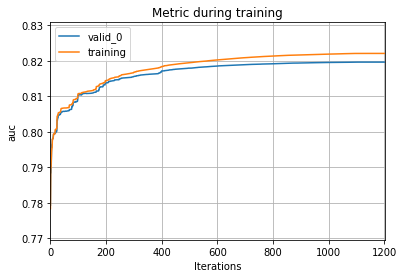

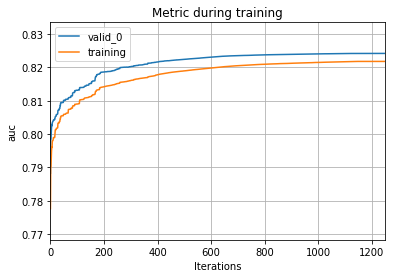

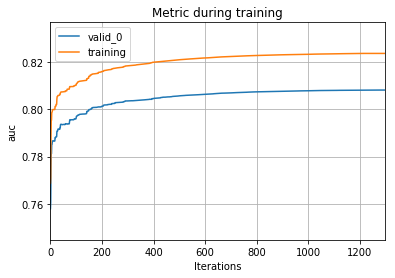

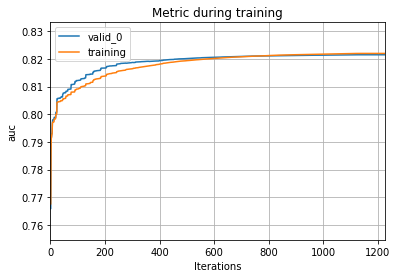

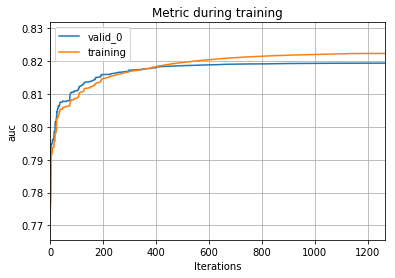

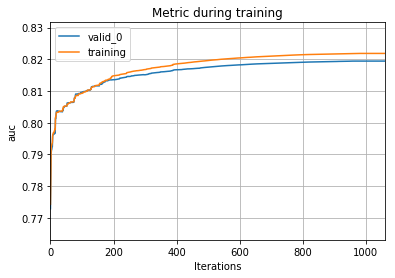

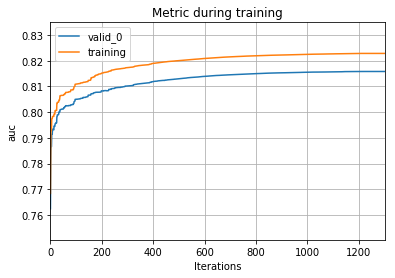

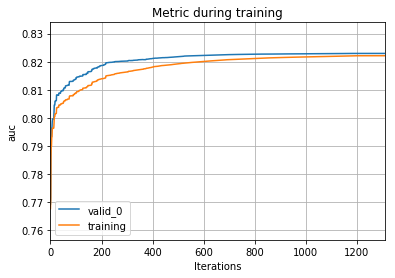

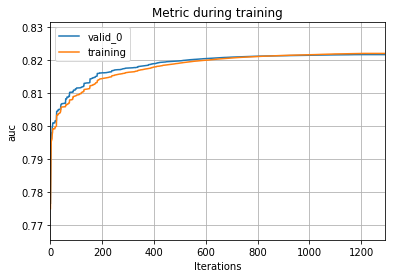

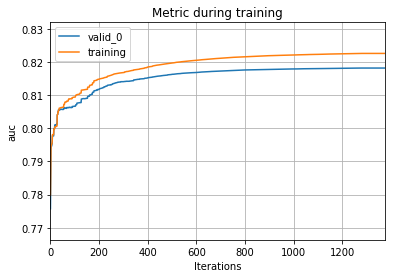

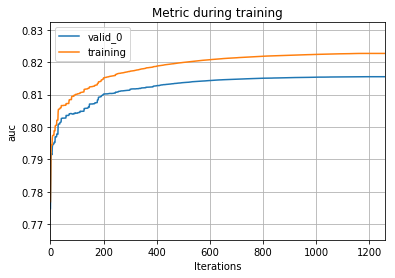

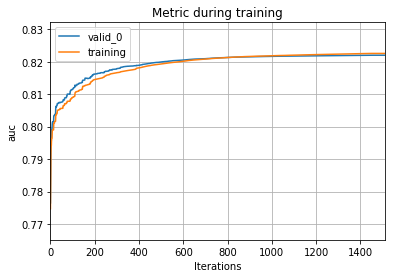

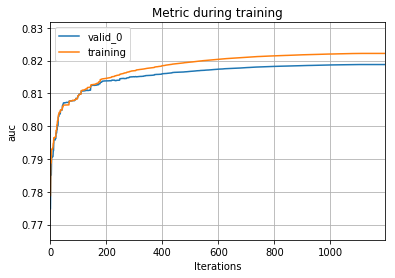

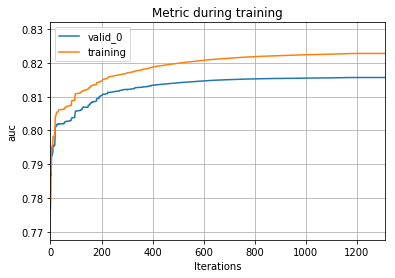

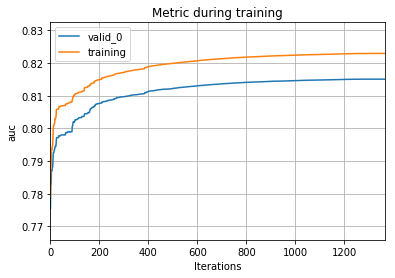

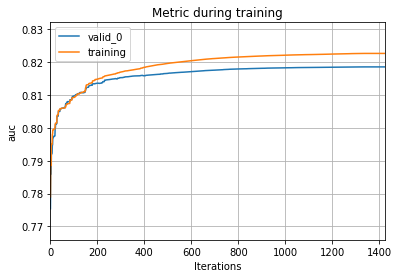

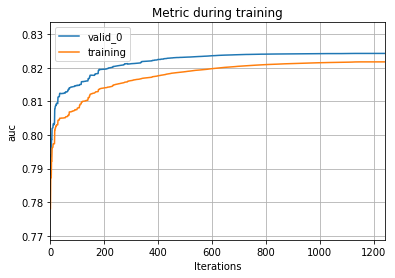

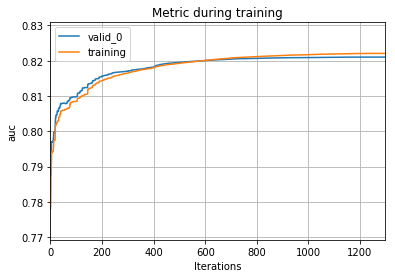

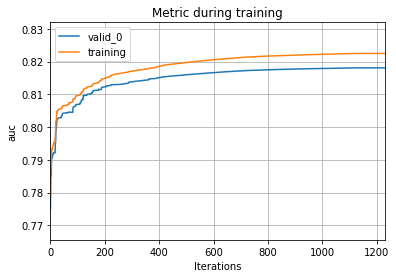

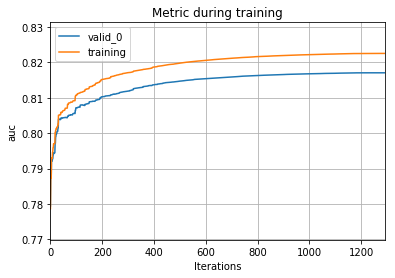

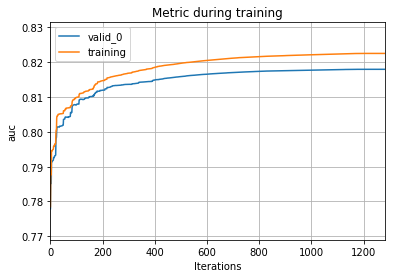

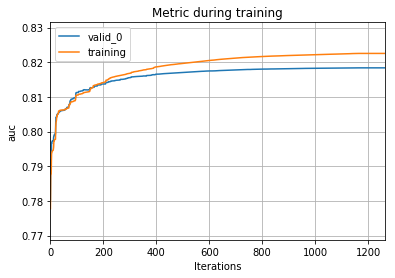

In [124]:
final_cv_train = np.zeros(len(labels_train))
final_cv_pred = np.zeros(len( test_ids ))

NFOLDS = 10 

M = 32
x_score = []
fold_scores_lgb = []
for s in range( M ):
    
    params['seed'] = s
    
    cv_train = np.zeros( len( labels_train ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=s)
    kf  = kfold.split(  new_train , labels_train )
    
    fold_scores = []
    
    for i, (train_fold, validate) in enumerate(kf):
        evals_result = {}
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]
        
    #X_train, X_validate, label_train, label_validate = X[train_fold, :], X[validate, :], labels_train[train_fold], labels_train[validate]
        dtrain = lgb.Dataset( X_train , label_train  )
    
        dvalid = lgb.Dataset(  X_validate  , label_validate , reference=dtrain )
        bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid , dtrain ] , verbose_eval = 100 , evals_result=evals_result, early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        cv_pred +=  bst.predict(  new_test , num_iteration = bst.best_iteration )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( X_validate )
        score = roc_auc_score( label_validate , cv_train[validate])
        print("fold {}  - {} ".format( i ,  score ) )
        fold_scores_lgb.append( score )
        
        # save graphic
        ax = lgb.plot_metric(evals_result, metric='auc' )
        print("SAVING FIGURE") 
        plt.savefig( "../data/graphics/lgb/lc_s{}_f{}.png".format( s , i ) , format = "png" )
        #plt.show()
        
    cv_pred /= NFOLDS
    
    final_cv_train += cv_train
    final_cv_pred += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train / (s + 1.)), s+1)
    
    x_score.append(roc_auc_score( labels_train , cv_train))
    
    

0.817345685997514


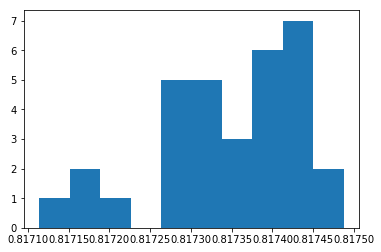

In [56]:
print( np.array(x_score).mean())
plt.hist( x_score )
plt.show()

In [100]:
final_pred_lgb = final_cv_pred/M

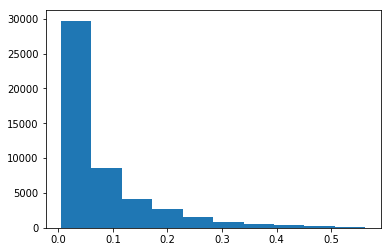

In [101]:
plt.hist( final_pred_lgb)
plt.show()

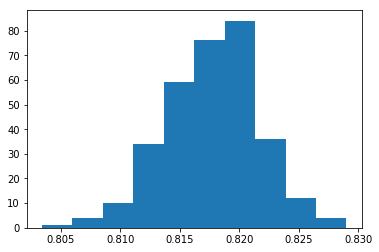

In [94]:
plt.hist( fold_scores_lgb ) 
plt.show()

# XGboost model with oof_preds

In [88]:
learning_rate = 0.01
num_leaves = 30
min_data_in_leaf = 2000
feature_fraction = 0.9
num_boost_round = 5000
params = {"booster": "gbtree",
         "eta" : learning_rate , 
          "max_depth" : 5 , 
          "colsample_bytree" : feature_fraction , 
          "lambda" : 100 , 
          "gamma" : 20 , 
          "alpha" : 100 , 
           "tree_method" : "hist" , 
          "max_bin" : 256 , 
          "rate_drop": 0.01 , 
          'objective': 'binary:logistic' , 
          "eval_metric" : "auc"
}

In [89]:
final_cv_train_xgbst = np.zeros(len(labels_train))
final_cv_pred_xgbst = np.zeros(len( test_ids ))

NFOLDS = 10

M = 32
x_score_xgbst = []
dtest = xgb.DMatrix( new_test )
fold_scores_xgb = []
for s in range( M ):
    
    params['seed'] = 2*s
    
    cv_train = np.zeros( len( labels_train ))
    cv_pred = np.zeros( len( test_ids ) )
    kfold = StratifiedKFold(n_splits=NFOLDS, shuffle=True, random_state=2*s)
    kf  = kfold.split(  new_train , labels_train )
    
    for i, (train_fold, validate) in enumerate(kf):
        
        X_train, X_validate, label_train, label_validate = new_train[train_fold, :], new_train[validate, :], labels_train[train_fold], labels_train[validate]

        dtrain = xgb.DMatrix( X_train , label=label_train )
        dvalid = xgb.DMatrix( X_validate , label = label_validate )
        evallist = [ (dvalid, 'eval') ]
        bst = xgb.train(params, dtrain, num_boost_round, evals =  evallist , early_stopping_rounds=100 , verbose_eval=100 )
        #bst = lgb.train(params, dtrain , num_boost_round , valid_sets=[dvalid ] , verbose_eval = 100 , early_stopping_rounds = 100 )
    #best_trees.append(bst.best_iteration)    
        #cv_pred +=  bst.predict(  new_test , num_iteration = bst.best_iteration )
        
        cv_pred += bst.predict( dtest, ntree_limit=bst.best_ntree_limit )
    #cv_eval_total += bst.predict( x_val , num_iteration = bst.best_iteration )          
        cv_train[validate] += bst.predict( dvalid , ntree_limit=bst.best_ntree_limit )
        score = roc_auc_score( label_validate , cv_train[validate] )
        fold_scores_xgb.append( score )
        print( "fold {} - {}".format(i , score ))
    
    cv_pred /= NFOLDS
    
    final_cv_train_xgbst += cv_train
    final_cv_pred_xgbst += cv_pred
    
    print("cv score - on train:")
    print( roc_auc_score(labels_train, cv_train))
    print( "current score in fold:", roc_auc_score( labels_train , final_cv_train_xgbst / (s + 1.)), s+1)
    
    x_score_xgbst.append(roc_auc_score( labels_train , cv_train))

[0]	eval-auc:0.773623
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.802357
[200]	eval-auc:0.808022
[300]	eval-auc:0.81059
[400]	eval-auc:0.811442
[500]	eval-auc:0.81199
[600]	eval-auc:0.81222
[700]	eval-auc:0.812309
[800]	eval-auc:0.812322
[900]	eval-auc:0.812361
[1000]	eval-auc:0.812383
Stopping. Best iteration:
[958]	eval-auc:0.812383

fold 0 - 0.812382612035
[0]	eval-auc:0.772279
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.80515
[200]	eval-auc:0.809367
[300]	eval-auc:0.811598
[400]	eval-auc:0.812611
[500]	eval-auc:0.813309
[600]	eval-auc:0.813384
[700]	eval-auc:0.813381
[800]	eval-auc:0.813404
[900]	eval-auc:0.813407
[1000]	eval-auc:0.813423
Stopping. Best iteration:
[984]	eval-auc:0.813423

fold 1 - 0.813423365624
[0]	eval-auc:0.787589
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.814536
[200]	eval-auc:0.818891
[300]	eval-auc:0.821009
[400]	eval-auc:0.821791
[500]	eval-auc:0.822303
[600]	eval-auc:

Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.81286
[200]	eval-auc:0.818208
[300]	eval-auc:0.820663
[400]	eval-auc:0.821669
[500]	eval-auc:0.822434
[600]	eval-auc:0.822779
[700]	eval-auc:0.822914
[800]	eval-auc:0.822924
[900]	eval-auc:0.822934
Stopping. Best iteration:
[829]	eval-auc:0.822934

fold 2 - 0.82293420296
[0]	eval-auc:0.768242
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.806563
[200]	eval-auc:0.810642
[300]	eval-auc:0.813001
[400]	eval-auc:0.813768
[500]	eval-auc:0.814538
[600]	eval-auc:0.814844
[700]	eval-auc:0.814946
[800]	eval-auc:0.814947
Stopping. Best iteration:
[726]	eval-auc:0.814947

fold 3 - 0.814947458274
[0]	eval-auc:0.77332
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.807521
[200]	eval-auc:0.813185
[300]	eval-auc:0.814934
[400]	eval-auc:0.815729
[500]	eval-auc:0.816522
[600]	eval-auc:0.816712
[700]	eval-auc:0.816773
Stopping. Best iteration:
[688]	eval-auc:0.816773

fold 4 - 0.

[200]	eval-auc:0.813399
[300]	eval-auc:0.815625
[400]	eval-auc:0.816587
[500]	eval-auc:0.81746
[600]	eval-auc:0.817739
[700]	eval-auc:0.817818
[800]	eval-auc:0.81787
Stopping. Best iteration:
[763]	eval-auc:0.81787

fold 4 - 0.817870244537
[0]	eval-auc:0.773783
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804501
[200]	eval-auc:0.810222
[300]	eval-auc:0.81164
[400]	eval-auc:0.812656
[500]	eval-auc:0.813284
[600]	eval-auc:0.813726
[700]	eval-auc:0.813773
Stopping. Best iteration:
[675]	eval-auc:0.813773

fold 5 - 0.813772658489
[0]	eval-auc:0.777402
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.806866
[200]	eval-auc:0.810417
[300]	eval-auc:0.81222
[400]	eval-auc:0.813191
[500]	eval-auc:0.813732
[600]	eval-auc:0.814022
[700]	eval-auc:0.814061
[800]	eval-auc:0.814075
[900]	eval-auc:0.814081
Stopping. Best iteration:
[873]	eval-auc:0.814081

fold 6 - 0.814080795909
[0]	eval-auc:0.777673
Will train until eval-auc hasn't improved in 100

Stopping. Best iteration:
[1212]	eval-auc:0.816664

fold 6 - 0.816663734371
[0]	eval-auc:0.773583
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804039
[200]	eval-auc:0.809117
[300]	eval-auc:0.811747
[400]	eval-auc:0.81327
[500]	eval-auc:0.814404
[600]	eval-auc:0.814687
[700]	eval-auc:0.814714
[800]	eval-auc:0.81474
[900]	eval-auc:0.814755
[1000]	eval-auc:0.814779
[1100]	eval-auc:0.814791
[1200]	eval-auc:0.814801
Stopping. Best iteration:
[1152]	eval-auc:0.814801

fold 7 - 0.814801180071
[0]	eval-auc:0.78372
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.811024
[200]	eval-auc:0.815238
[300]	eval-auc:0.817065
[400]	eval-auc:0.818458
[500]	eval-auc:0.819153
[600]	eval-auc:0.819464
[700]	eval-auc:0.819501
[800]	eval-auc:0.819515
[900]	eval-auc:0.819522
[1000]	eval-auc:0.819545
[1100]	eval-auc:0.819563
[1200]	eval-auc:0.819572
Stopping. Best iteration:
[1119]	eval-auc:0.819572

fold 8 - 0.819572458421
[0]	eval-auc:0.782134
Will train un

[1000]	eval-auc:0.819224
Stopping. Best iteration:
[977]	eval-auc:0.819224

fold 8 - 0.819223996473
[0]	eval-auc:0.773286
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804415
[200]	eval-auc:0.809162
[300]	eval-auc:0.810829
[400]	eval-auc:0.812246
[500]	eval-auc:0.812808
[600]	eval-auc:0.812961
[700]	eval-auc:0.813023
[800]	eval-auc:0.813026
Stopping. Best iteration:
[786]	eval-auc:0.813026

fold 9 - 0.813026224076
cv score - on train:
0.8168464202332283
('current score in fold:', 0.8170816695623174, 9)
[0]	eval-auc:0.777198
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804581
[200]	eval-auc:0.810192
[300]	eval-auc:0.812124
[400]	eval-auc:0.813816
[500]	eval-auc:0.814893
[600]	eval-auc:0.815216
[700]	eval-auc:0.815361
[800]	eval-auc:0.815372
[900]	eval-auc:0.815412
Stopping. Best iteration:
[896]	eval-auc:0.815412

fold 0 - 0.815411585723
[0]	eval-auc:0.777809
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:

[800]	eval-auc:0.811464
[900]	eval-auc:0.811478
Stopping. Best iteration:
[834]	eval-auc:0.811478

fold 0 - 0.81147832713
[0]	eval-auc:0.779821
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.808848
[200]	eval-auc:0.814735
[300]	eval-auc:0.816706
[400]	eval-auc:0.817202
[500]	eval-auc:0.818069
[600]	eval-auc:0.818247
[700]	eval-auc:0.818407
[800]	eval-auc:0.818498
[900]	eval-auc:0.818519
Stopping. Best iteration:
[844]	eval-auc:0.818519

fold 1 - 0.818519393263
[0]	eval-auc:0.777119
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.810024
[200]	eval-auc:0.815179
[300]	eval-auc:0.817368
[400]	eval-auc:0.818463
[500]	eval-auc:0.819202
[600]	eval-auc:0.819387
Stopping. Best iteration:
[596]	eval-auc:0.819398

fold 2 - 0.819397777753
[0]	eval-auc:0.783136
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.811381
[200]	eval-auc:0.814675
[300]	eval-auc:0.816088
[400]	eval-auc:0.817117
[500]	eval-auc:0.817697
[600]	eval-

Stopping. Best iteration:
[683]	eval-auc:0.817537

fold 3 - 0.817536530946
[0]	eval-auc:0.768033
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.798881
[200]	eval-auc:0.802121
[300]	eval-auc:0.803595
[400]	eval-auc:0.804941
[500]	eval-auc:0.805565
[600]	eval-auc:0.805861
[700]	eval-auc:0.805865
Stopping. Best iteration:
[619]	eval-auc:0.805878

fold 4 - 0.805877490726
[0]	eval-auc:0.772592
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804585
[200]	eval-auc:0.809653
[300]	eval-auc:0.81207
[400]	eval-auc:0.813663
[500]	eval-auc:0.814473
[600]	eval-auc:0.81481
[700]	eval-auc:0.814877
[800]	eval-auc:0.814879
Stopping. Best iteration:
[709]	eval-auc:0.814881

fold 5 - 0.814880945916
[0]	eval-auc:0.776436
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.807085
[200]	eval-auc:0.812469
[300]	eval-auc:0.814456
[400]	eval-auc:0.815454
[500]	eval-auc:0.816412
[600]	eval-auc:0.816499
[700]	eval-auc:0.81654
[800]	eval-au

Stopping. Best iteration:
[920]	eval-auc:0.821952

fold 5 - 0.821951907068
[0]	eval-auc:0.780268
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.810752
[200]	eval-auc:0.81544
[300]	eval-auc:0.817723
[400]	eval-auc:0.818756
[500]	eval-auc:0.81941
[600]	eval-auc:0.819661
[700]	eval-auc:0.819698
[800]	eval-auc:0.81972
[900]	eval-auc:0.819728
[1000]	eval-auc:0.819739
[1100]	eval-auc:0.819746
Stopping. Best iteration:
[1038]	eval-auc:0.819746

fold 6 - 0.819746236865
[0]	eval-auc:0.778242
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.807684
[200]	eval-auc:0.812113
[300]	eval-auc:0.814076
[400]	eval-auc:0.815484
[500]	eval-auc:0.816368
[600]	eval-auc:0.816425
[700]	eval-auc:0.8164
Stopping. Best iteration:
[616]	eval-auc:0.816444

fold 7 - 0.816444474933
[0]	eval-auc:0.777151
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.803301
[200]	eval-auc:0.809402
[300]	eval-auc:0.811615
[400]	eval-auc:0.812967
[500]	eval-a

fold 8 - 0.819571211292
[0]	eval-auc:0.776167
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804525
[200]	eval-auc:0.807549
[300]	eval-auc:0.809909
[400]	eval-auc:0.810945
[500]	eval-auc:0.811845
[600]	eval-auc:0.812045
[700]	eval-auc:0.812109
Stopping. Best iteration:
[688]	eval-auc:0.81211

fold 9 - 0.812110454078
cv score - on train:
0.8169983221449134
('current score in fold:', 0.8170981462327874, 18)
[0]	eval-auc:0.780864
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.812549
[200]	eval-auc:0.815465
[300]	eval-auc:0.817079
[400]	eval-auc:0.818327
[500]	eval-auc:0.81913
[600]	eval-auc:0.819388
[700]	eval-auc:0.819413
[800]	eval-auc:0.819426
[900]	eval-auc:0.819429
Stopping. Best iteration:
[861]	eval-auc:0.819429

fold 0 - 0.819429170252
[0]	eval-auc:0.775035
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.805518
[200]	eval-auc:0.809488
[300]	eval-auc:0.812945
[400]	eval-auc:0.813838
[500]	eval-auc:0.814

[0]	eval-auc:0.772164
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.80337
[200]	eval-auc:0.806587
[300]	eval-auc:0.809412
[400]	eval-auc:0.811276
[500]	eval-auc:0.812142
[600]	eval-auc:0.812504
[700]	eval-auc:0.812572
Stopping. Best iteration:
[682]	eval-auc:0.812577

fold 0 - 0.81257687939
[0]	eval-auc:0.776395
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.806978
[200]	eval-auc:0.813518
[300]	eval-auc:0.814894
[400]	eval-auc:0.815686
[500]	eval-auc:0.816127
[600]	eval-auc:0.816323
[700]	eval-auc:0.816376
Stopping. Best iteration:
[618]	eval-auc:0.816377

fold 1 - 0.816376917534
[0]	eval-auc:0.776045
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.808862
[200]	eval-auc:0.813353
[300]	eval-auc:0.815592
[400]	eval-auc:0.816619
[500]	eval-auc:0.81711
[600]	eval-auc:0.817348
[700]	eval-auc:0.817376
[800]	eval-auc:0.81738
Stopping. Best iteration:
[715]	eval-auc:0.81738

fold 2 - 0.817380152564
[0]	eval-auc:0.

[1000]	eval-auc:0.815941
[1100]	eval-auc:0.815949
Stopping. Best iteration:
[1032]	eval-auc:0.815949

fold 2 - 0.815948677403
[0]	eval-auc:0.78346
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.810966
[200]	eval-auc:0.816285
[300]	eval-auc:0.817492
[400]	eval-auc:0.818583
[500]	eval-auc:0.81944
[600]	eval-auc:0.819727
[700]	eval-auc:0.819722
Stopping. Best iteration:
[646]	eval-auc:0.81975

fold 3 - 0.819749563223
[0]	eval-auc:0.78222
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.812312
[200]	eval-auc:0.816855
[300]	eval-auc:0.817811
[400]	eval-auc:0.819408
[500]	eval-auc:0.819954
[600]	eval-auc:0.820096
[700]	eval-auc:0.82019
Stopping. Best iteration:
[696]	eval-auc:0.82019

fold 4 - 0.820189977118
[0]	eval-auc:0.774829
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.802334
[200]	eval-auc:0.807992
[300]	eval-auc:0.810488
[400]	eval-auc:0.811937
[500]	eval-auc:0.81257
[600]	eval-auc:0.812722
[700]	eval-auc

[400]	eval-auc:0.813327
[500]	eval-auc:0.814156
[600]	eval-auc:0.814286
[700]	eval-auc:0.814374
[800]	eval-auc:0.814395
[900]	eval-auc:0.814414
[1000]	eval-auc:0.814422
Stopping. Best iteration:
[942]	eval-auc:0.814422

fold 5 - 0.814422132894
[0]	eval-auc:0.785181
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.814383
[200]	eval-auc:0.819416
[300]	eval-auc:0.821647
[400]	eval-auc:0.822456
[500]	eval-auc:0.82277
[600]	eval-auc:0.822783
Stopping. Best iteration:
[562]	eval-auc:0.82281

fold 6 - 0.822809939788
[0]	eval-auc:0.777
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.805331
[200]	eval-auc:0.810449
[300]	eval-auc:0.812301
[400]	eval-auc:0.813376
[500]	eval-auc:0.814308
[600]	eval-auc:0.814527
[700]	eval-auc:0.814535
Stopping. Best iteration:
[615]	eval-auc:0.814543

fold 7 - 0.814542853444
[0]	eval-auc:0.770548
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.804622
[200]	eval-auc:0.808319
[300]	eval-auc

Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.802379
[200]	eval-auc:0.807441
[300]	eval-auc:0.809906
[400]	eval-auc:0.810958
[500]	eval-auc:0.811611
[600]	eval-auc:0.811834
[700]	eval-auc:0.811846
Stopping. Best iteration:
[617]	eval-auc:0.811865

fold 8 - 0.811864826781
[0]	eval-auc:0.775859
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.805546
[200]	eval-auc:0.811161
[300]	eval-auc:0.812719
[400]	eval-auc:0.813988
[500]	eval-auc:0.814854
[600]	eval-auc:0.815079
[700]	eval-auc:0.815125
[800]	eval-auc:0.815131
[900]	eval-auc:0.815134
[1000]	eval-auc:0.815148
[1100]	eval-auc:0.815149
Stopping. Best iteration:
[1046]	eval-auc:0.815149

fold 9 - 0.815149506616
cv score - on train:
0.8170146727765777
('current score in fold:', 0.8171013144450967, 27)
[0]	eval-auc:0.786791
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.81687
[200]	eval-auc:0.821459
[300]	eval-auc:0.823053
[400]	eval-auc:0.824418
[500]	eval-auc

[400]	eval-auc:0.814773
[500]	eval-auc:0.815414
[600]	eval-auc:0.81552
[700]	eval-auc:0.815536
Stopping. Best iteration:
[675]	eval-auc:0.815536

fold 0 - 0.815535631327
[0]	eval-auc:0.764245
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.7972
[200]	eval-auc:0.80103
[300]	eval-auc:0.804431
[400]	eval-auc:0.805605
[500]	eval-auc:0.806535
[600]	eval-auc:0.806845
[700]	eval-auc:0.806888
Stopping. Best iteration:
[633]	eval-auc:0.806908

fold 1 - 0.806907815766
[0]	eval-auc:0.784907
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.814829
[200]	eval-auc:0.817836
[300]	eval-auc:0.81959
[400]	eval-auc:0.82048
[500]	eval-auc:0.821159
[600]	eval-auc:0.82131
[700]	eval-auc:0.821356
[800]	eval-auc:0.821364
Stopping. Best iteration:
[799]	eval-auc:0.821364

fold 2 - 0.821364442666
[0]	eval-auc:0.77925
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.808873
[200]	eval-auc:0.813207
[300]	eval-auc:0.815909
[400]	eval-auc:0.8

[300]	eval-auc:0.81612
[400]	eval-auc:0.817337
[500]	eval-auc:0.818003
[600]	eval-auc:0.818222
[700]	eval-auc:0.818297
Stopping. Best iteration:
[662]	eval-auc:0.818299

fold 3 - 0.818298812341
[0]	eval-auc:0.776446
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.803283
[200]	eval-auc:0.809169
[300]	eval-auc:0.811983
[400]	eval-auc:0.812998
[500]	eval-auc:0.814013
[600]	eval-auc:0.81442
[700]	eval-auc:0.81452
[800]	eval-auc:0.814551
[900]	eval-auc:0.814575
[1000]	eval-auc:0.814587
[1100]	eval-auc:0.8146
[1200]	eval-auc:0.814608
Stopping. Best iteration:
[1114]	eval-auc:0.814608

fold 4 - 0.814607597253
[0]	eval-auc:0.781795
Will train until eval-auc hasn't improved in 100 rounds.
[100]	eval-auc:0.812163
[200]	eval-auc:0.815318
[300]	eval-auc:0.817653
[400]	eval-auc:0.819133
[500]	eval-auc:0.820139
[600]	eval-auc:0.820549
[700]	eval-auc:0.820658
Stopping. Best iteration:
[644]	eval-auc:0.820659

fold 5 - 0.820658751857
[0]	eval-auc:0.781372
Will train until eva

In [91]:
np.array( x_score_xgbst).mean()

0.8169864005722789

In [72]:
np.array( x_score_xgbst).

7.968120993222278e-05

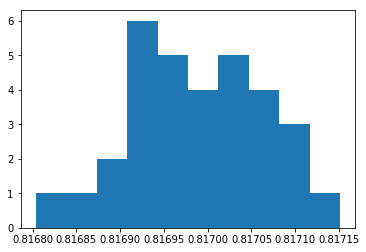

In [95]:
plt.hist( x_score_xgbst )
plt.show()


In [102]:
final_xgb = final_cv_pred_xgbst/M

In [103]:
final_xgb

array([0.03161012, 0.11100603, 0.01604727, ..., 0.01432699, 0.03582011,
       0.2561009 ])

In [104]:
final = final_cv_pred/M

In [105]:
final_train = final_cv_train_xgbst/M
final_train_lgb = final_cv_train/M

In [106]:
final_pos = final_train[ labels_train == 1  ]
final_neg = final_train[labels_train == 0 ]
final_pos_lgb = final_train_lgb[ labels_train == 1  ]
final_neg_lgb = final_train_lgb[labels_train == 0 ]

In [107]:
print( np.array( x_score).mean() )

0.8177096477679208


In [108]:
roc_auc_score( labels_train , final_cv_train/M ) 

0.8177907443613184

In [109]:
a = len(final_pos)

In [110]:
b = len(final_neg)

In [111]:
final_mean = ( final_xgb +  final_pred_lgb)/2.0

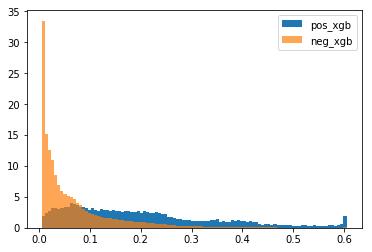

In [116]:
plt.hist( final_pos , density = True , bins = 100 , label = "pos_xgb" )
plt.hist(  final_neg  , density = True , bins = 100 , alpha = 0.7 , label = "neg_xgb")
#plt.hist( final_pos_lgb , density = True , bins = 100 , label = "pos_lgb" )
#plt.hist(  final_neg_lgb , density = True , bins = 100 , alpha = 0.7 , label = "neg_lgb")

plt.legend()
plt.show()

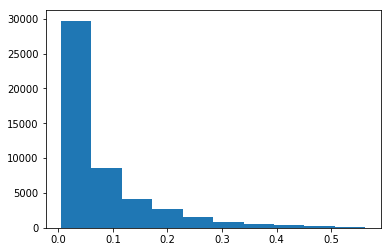

In [117]:
#plt.hist( final_xgb)
#plt.hist( final_mean )
plt.hist( final_pred_lgb )
plt.show()

In [111]:
final_logi.shape

(307511,)

In [43]:
x_score

[0.8169483052586347,
 0.8190930615893933,
 0.8182237024787657,
 0.8180733051241529,
 0.816361926066463,
 0.8186181301271797,
 0.8174379841161038,
 0.8168223110545245,
 0.816578728843284,
 0.8182051318826529,
 0.8168356163064975,
 0.8175523110027269,
 0.8172393537268681,
 0.8182943858105127,
 0.8162965355095738,
 0.8186261278558308]

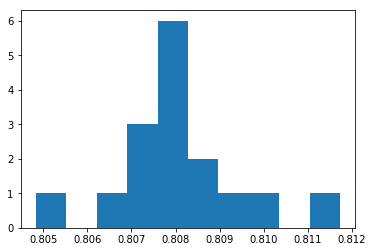

In [98]:
plt.hist( x_score_xgb )
plt.show()

In [48]:
np.array( x_score_xgb ).std()

0.001428089557675824

In [49]:
np.array( x_score ).std()

0.0008594220828512764

In [99]:
pd.DataFrame({'SK_ID_CURR': test_ids, 'TARGET': final_mean }).to_csv('../data/pred_mean_oof.csv', index=False)

Plot feature importances...


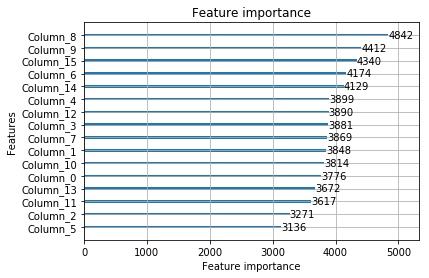

In [48]:
print('Plot feature importances...')
ax = lgb.plot_importance( bst , max_num_features=20)
plt.show()